## 1.1 Import package

In [34]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import expanduser
home = expanduser("~")
import sys
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor,RandomForestRegressor,AdaBoostRegressor
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from skopt.space import Real, Integer, Categorical
from xgboost import XGBRegressor
from skopt.utils import use_named_args
from skopt import gp_minimize
import joblib
import pickle
import csv
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR, NuSVR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

In [61]:
filename='featuresXeM'
data_file_name=filename+".csv" # diversity selection filename

 
diverse_ratio=0.8 # training set ratio, 
remaining_ratio=1-diverse_ratio # test set ratio


## 2.2 Load divided data set

In [62]:
diverse_set=[]
remaining_set=[]

txt = open("divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt",'r').read()
print(" Load file name : divided_set_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+"Xe-M.txt")
s1=txt.find("[",0)
s2=txt.find("]",s1)
diverse_set=txt[s1+1:s2].split(", ")
diverse_set=[int(i) for i in diverse_set]
s3=txt.find("[",s2)
s4=txt.find("]",s3)
remaining_set=txt[s3+1:s4].split(", ")
remaining_set=[int(i) for i in remaining_set]
print("# of diverse set, remaining set :",len(diverse_set),len(remaining_set))


with open(data_file_name) as f:
        data_file = csv.reader(f)
        temp = next(data_file)
        N_samples = int(temp[0])
        N_features = int(temp[1])
        N_targets = int(temp[2])
        number = np.empty((N_samples,))
        structure = np.empty((N_samples,))
        data = np.empty((N_samples, N_features))
        target = np.empty((N_samples,N_targets))
        temp = next(data_file)  # names of features
        structure = []
        feature_names=temp[2:2+N_features]
        for i, d in enumerate(data_file):
            number[i] = np.asarray(d[0],dtype=np.int)
            structure.append(d[1])
            data[i] = np.asarray(d[2:2+N_features], dtype=np.float64)
            target[i] = np.asarray(d[-N_targets:], dtype=np.float64)
N_materials = data.shape[0]

diverse_set_total=[]
remaining_set_total=[]
for i,diverse in enumerate(diverse_set):
    arridx = np.where(number == diverse)
    for j,element_div in enumerate(arridx[0]):
        diverse_set_total.append(element_div)
for i,remaining in enumerate(remaining_set):
    arridx = np.where(number == remaining)
    for j,element_rem in enumerate(arridx[0]):
        remaining_set_total.append(element_rem)        

X_train = data[diverse_set_total]
y_train = target[diverse_set_total]
X_test = data[remaining_set_total]
y_test = target[remaining_set_total]

 Load file name : divided_set_0.8_0.2_Xe-M.txt
# of diverse set, remaining set : 994 249


<ipython-input-62-dd663689e4d9>:31: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  number[i] = np.asarray(d[0],dtype=np.int)


## 2.3 Plot feature distribution 

D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
D:\Anaconda\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel

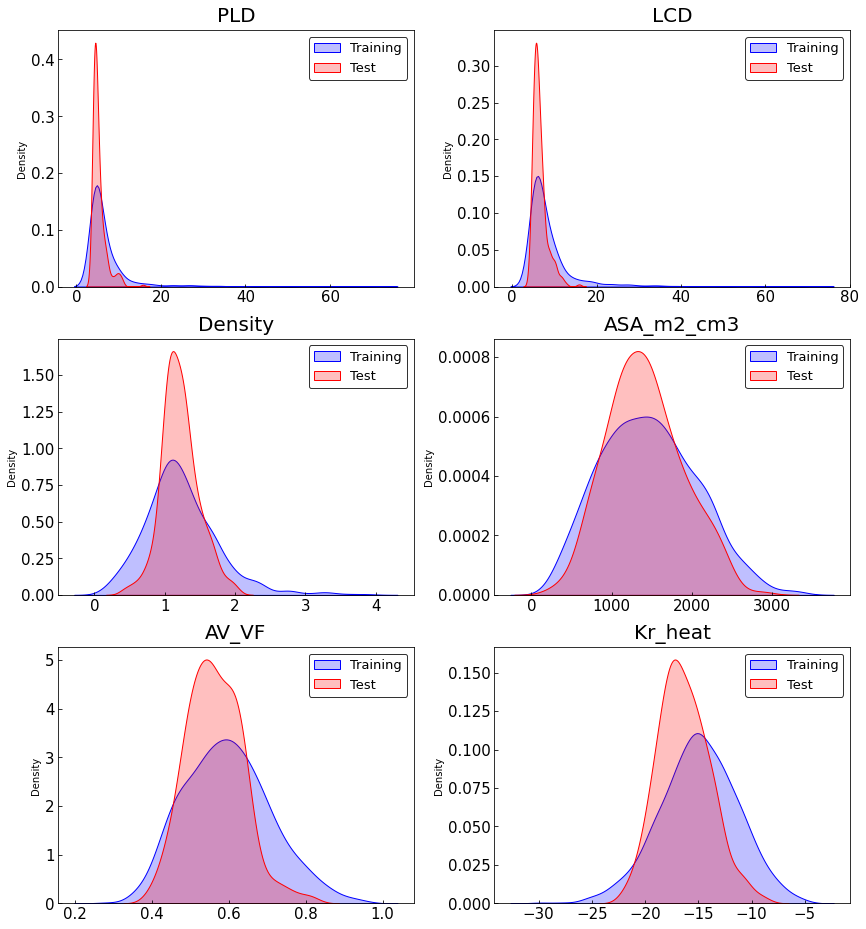

In [37]:
fig=plt.figure(figsize=(12,2*len(feature_names)+1))
for i in range(len(feature_names)):
    ax=plt.subplot(math.ceil(len(feature_names)/2),2,i+1)
    ax.set_title(feature_names[i],fontsize=20,position=(.5,1.01))
    ax.tick_params(axis='both', which='both', direction='in', labelsize=15)
    sns.distplot(list(X_train.T[i]),ax=ax, color='b',label="Training",hist=False,bins='scott',norm_hist=True, kde_kws={"shade": True})
    sns.distplot(list(X_test.T[i]),ax=ax, color='r',label="Test",hist=False,bins='scott',norm_hist=True, kde_kws={"shade": True})
    plt.legend(frameon=True,fontsize=13,edgecolor='k')
plt.tight_layout()
# plt.savefig("feature_distribution"+"_"+str(N_features)+"_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+filename+".png",dpi=400)

## 3.1 Train model and Save training model

### Random Forest Regression

In [41]:
reg = RandomForestRegressor()
space  = [Integer(1, 500, name='n_estimators'),
          Integer(1, 50, name='max_depth'),
         Integer(1, 50, name='min_samples_split'),
         Integer(1, 50, name='min_samples_leaf')]
@use_named_args(space)

def objective(**params):
    reg.set_params(**params)
    result=-np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=-1,
                                        scoring="neg_mean_squared_error"))
    
    print(result)
    return result

res_gp = gp_minimize(objective, space, n_calls=10)

print("Best score=%.4f" % res_gp.fun)
print("""Best parameters:
    - n_estimator=%d
    - max_depth=%d
    - min_samples_split=%d
    - min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1],
                                res_gp.x[2], res_gp.x[3]))
reg_opt = RandomForestRegressor(n_estimators=res_gp.x[0],
                                        max_depth=res_gp.x[1],
                                       min_samples_split=res_gp.x[2],
                                       min_samples_leaf=res_gp.x[3],
                                       random_state=445,
                                       max_features='sqrt')
reg_opt.fit(X_train, y_train.ravel())

print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))

90.48939183938481
105.6487605846128
104.89291288659997
90.31184052204313
106.55562956362118
115.20750197164355
116.49410940437585
114.38129012030386
120.65261901360262
109.54565852833557
Best score=90.3118
Best parameters:
    - n_estimator=118
    - max_depth=8
    - min_samples_split=7
    - min_samples_leaf=12
R^2 Training Score: 0.665 
R^2 Testing Score: 0.927
RMSE Training Score: 8.013 
RMSE Testing Score: 1.181
MAE Training Score: 1.683 
MAE Testing Score: 0.659


In [42]:
save_model = joblib.dump(reg_opt,"RF"+"_Kr_M_Langmuir.pkl")
print([feature+" : "+str(reg_opt.feature_importances_[i]) for i,feature in enumerate(feature_names)])

['PLD : 0.048019024967866974', 'LCD : 0.08997190272211383', 'Density : 0.32815566153098946', 'ASA_m2_cm3 : 0.020955392697177302', 'AV_VF : 0.31533969861550853', 'Kr_heat : 0.19755831946634395']


### GBR

In [57]:
reg = XGBRegressor()
space  = [Integer(1,500, name='n_estimators'),
            Integer(1, 50, name='max_depth'),
            Integer(1, 50, name='num_parallel_tree'),
            Integer(1, 50, name='min_child_weight'),
            Real(0.001,1,"log-uniform",name='learning_rate'),
            Real(0.01,1,name='subsample'),
            Real(0.001,50,"log-uniform",name='gamma'),
            Real(0, 1, name='alpha')
         ]
@use_named_args(space)

def objective(**params):
    reg.set_params(**params)
    result=-np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=8,
                                        scoring="neg_mean_squared_error"))
    
    print(result)
    return result

res_gp = gp_minimize(objective, space, n_calls=100)

print("Best score=%.4f" % res_gp.fun)
print("""Best parameters:
    - n_estimator=%d
    - max_depth=%d
    - num_parallel_tree=%d
    - min_child_weight=%d
    - learning_rate=%f
    - subsample=%f
    - gamma=%f
    - alpha=%f""" % (res_gp.x[0],res_gp.x[1],
                        res_gp.x[2],res_gp.x[3],
                        res_gp.x[4],res_gp.x[5],
                        res_gp.x[6],res_gp.x[7]
                         ))
reg_opt = XGBRegressor(n_estimators=res_gp.x[0],
                                    max_depth=res_gp.x[1],
                                    num_parallel_tree=res_gp.x[2],
                                    min_child_weight=res_gp.x[3],
                                    learning_rate=res_gp.x[4],
                                    subsample=res_gp.x[5],
                                    gamma=res_gp.x[6],
                                   alpha=res_gp.x[7]
                                  )
reg_opt.fit(X_train, y_train)

print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))

106.23738418786186
78.96255456337252
188.5252826618554
133.78332466989292
95.29991287347141
133.44497458020692
256.51248032420665
77.27066510260285
81.69139078419673
120.91225333229663
69.52230876378646
68.03464548668954
197.73948351389402
67.90164544360543
68.3968719892264
68.51237819283719
86.71799161675638
67.81945755496784
68.30887264951107
66.48446246906295
69.57899501454571
250.7229975718521
66.47139902422299
65.67731146705488
66.44767878278653
65.32077025635243
108.3820623305965
70.54919406850863
65.39561416922488
65.13807519084966
66.39164099013648
65.40448739181197
66.34457652415871
66.6328476751325
77.95366675624766
64.75877961753493
72.47111970943935
65.40813006844213
64.54098988771827
67.6620594200504
69.4180144440596
70.20173105656089
67.95258199983112
66.07876012951905
66.19664413556532
66.59159304473275
128.03233960310217
66.97626798108305
67.60390656607335
65.572791499705
66.27416233544983
64.43413582829588
64.91402620994043
65.55600020895616
65.73597689010555
66.512184

In [40]:
save_model = joblib.dump(reg_opt,"GBR"+"_Kr_M_Langmuir.pkl")
print([feature+" : "+str(reg_opt.feature_importances_[i]) for i,feature in enumerate(feature_names)])

['PLD : 0.014369392', 'LCD : 0.006216315', 'Density : 0.3924986', 'ASA_m2_cm3 : 0.004258436', 'AV_VF : 0.4315661', 'Kr_heat : 0.15109113']


In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

xgb = XGBRegressor(use_rmm=True,validate_parameters=True,disable_default_eval_metric=False)

parameters = {
             'booster':['dart'],#'gbtree','gblinear',
            'nthread':[4], 
               'objective':['reg:squarederror'],
                'eta': [0.1,0.3,0.5], 
                'max_depth': [1,5,10],# 0
                'min_child_weight': [0.5,1],
                 'subsample': [0.5,1],
# #               'colsample_bytree': [1],
# #               'colsample_bylevel': [1],
# #               'colsample_bynode': [1],
              'n_estimators': [100,200,300],
              'gamma': [0,0.5],
               'lambda':[1,2],
               'alpha':[0,0.5],
# #              'max_delta_step': [0],
           'tree_method':['exact'],# ,'approx','auto','hist'
# #           'predictor':['auto'],# ,'cpu_predictor','gpu_predictor'
# #             'sampling_method':['uniform'],#,'gradient_based'
# #              'process_type':['default'],#,'update'
               'num_parallel_tree':[1,5,10],
#              'scale_pos_weight': [0.1,1,2,3],
#                'updater':['grow_quantile_histmaker'],#,'grow_colmaker','grow_histmaker','grow_local_histmaker','grow_gpu_hist','sync','refresh','prune'
              
#                'refresh_leaf': [0],
# # #             'grow_policy':['depthwise','lossguide'],
#                 'max_bin':[128],
#                  'max_leaves':[32],
#                 'sketch_eps': [0.001],
#               'monotone_constraints':[],
#               interaction_constraints:[]
             }

reg_opt = GridSearchCV(xgb,
                        parameters,
                        cv = 5,
                        n_jobs = 5,
                       scoring='r2',
                        verbose=True)

reg_opt.fit(X_train,y_train)
# reg_opt.fit(X_train, np.ravel(y_train))
print(reg_opt.best_params_)
# save_model = joblib.dump(reg_opt,'jolsul'+"_"+str(N_features)+"_"+str(diverse_ratio)+"_"+str("%.1f"%remaining_ratio)+"_"+ML_algorithm+"_Xe_K1_langmuir.pkl")
print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
# print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
# print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))

Fitting 5 folds for each of 2592 candidates, totalling 12960 fits


## NN

In [43]:
mlp = MLPRegressor(batch_size='auto',
    verbose=False, warm_start=False, 
    early_stopping=False,
    alpha=0.0001,
    learning_rate_init=0.001, shuffle=True,
    random_state=1, tol=0.00001,
    beta_1=0.9, beta_2=0.999, epsilon=1e-08,n_iter_no_change=10000)
# space  = [Integer(100,1000, name='hidden_neurons'),
#         Integer(5, 10, name='layers'),
#          Integer(5, 10, name='max_iter')]
parameter_space = {
    'hidden_layer_sizes': [(60,60),(60,)],
    'activation': ['relu'],
    'solver': [ 'adam','lbfgs'],
    'learning_rate': ['constant','adaptive'],
    'max_iter': [1000,10000,20000,30000,40000,80000],
}

clf = GridSearchCV(mlp, parameter_space, n_jobs=4, cv=3)
clf.fit(X_train, y_train.ravel())

print('Best parameters found:\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'hidden_layer_sizes': (60,), 'learning_rate': 'constant', 'max_iter': 80000, 'solver': 'adam'}
0.272 (+/-0.268) for {'activation': 'relu', 'hidden_layer_sizes': (60, 60), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'adam'}
0.560 (+/-0.115) for {'activation': 'relu', 'hidden_layer_sizes': (60, 60), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'lbfgs'}
0.792 (+/-0.395) for {'activation': 'relu', 'hidden_layer_sizes': (60, 60), 'learning_rate': 'constant', 'max_iter': 10000, 'solver': 'adam'}
0.560 (+/-0.115) for {'activation': 'relu', 'hidden_layer_sizes': (60, 60), 'learning_rate': 'constant', 'max_iter': 10000, 'solver': 'lbfgs'}
0.435 (+/-1.384) for {'activation': 'relu', 'hidden_layer_sizes': (60, 60), 'learning_rate': 'constant', 'max_iter': 20000, 'solver': 'adam'}
0.560 (+/-0.115) for {'activation': 'relu', 'hidden_layer_sizes': (60, 60), 'learning_rate': 'constant', 'max_iter': 20000, 'solver': 'lbfgs'}
0.323

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [44]:
reg_opt = MLPRegressor(
    activation=clf.best_params_['activation'], 

    hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
    learning_rate=clf.best_params_['learning_rate'],
    max_iter=clf.best_params_['max_iter'],
    solver=clf.best_params_['solver'],
    batch_size='auto',
    verbose=True, warm_start=False, 
    early_stopping=False,
    alpha=0.0001,
    learning_rate_init=0.001, shuffle=True,
    random_state=1, tol=0.00001,
    beta_1=0.9, beta_2=0.999, epsilon=1e-08,n_iter_no_change=10000)

reg_opt.fit(X_train, y_train)

print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))

Iteration 1, loss = 115818.04782963
Iteration 2, loss = 78082.96873483
Iteration 3, loss = 47985.99651525
Iteration 4, loss = 26939.90790045
Iteration 5, loss = 12726.35626829
Iteration 6, loss = 4780.63692433
Iteration 7, loss = 1163.38493834
Iteration 8, loss = 158.71794514
Iteration 9, loss = 244.03697640
Iteration 10, loss = 522.92037547
Iteration 11, loss = 619.51859987
Iteration 12, loss = 517.20563353
Iteration 13, loss = 337.47493410
Iteration 14, loss = 189.45360260
Iteration 15, loss = 111.80064033
Iteration 16, loss = 90.36336552
Iteration 17, loss = 95.44008195
Iteration 18, loss = 101.78910991
Iteration 19, loss = 101.68086111
Iteration 20, loss = 97.40070101
Iteration 21, loss = 93.02573352
Iteration 22, loss = 90.81444491
Iteration 23, loss = 90.19386232
Iteration 24, loss = 90.29042520
Iteration 25, loss = 90.37393268
Iteration 26, loss = 90.20633907
Iteration 27, loss = 89.96330632
Iteration 28, loss = 89.75343899
Iteration 29, loss = 89.66416624
Iteration 30, loss = 8

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Iteration 57, loss = 85.35975093
Iteration 58, loss = 84.84530045
Iteration 59, loss = 84.58543937
Iteration 60, loss = 83.91437577
Iteration 61, loss = 83.75581311
Iteration 62, loss = 83.06881843
Iteration 63, loss = 82.76932029
Iteration 64, loss = 82.35368830
Iteration 65, loss = 81.75697010
Iteration 66, loss = 81.12706105
Iteration 67, loss = 80.62519801
Iteration 68, loss = 80.23357135
Iteration 69, loss = 79.51190769
Iteration 70, loss = 78.65971702
Iteration 71, loss = 78.33419279
Iteration 72, loss = 77.43140756
Iteration 73, loss = 76.81421478
Iteration 74, loss = 76.32049093
Iteration 75, loss = 75.66340578
Iteration 76, loss = 74.73899585
Iteration 77, loss = 74.26591838
Iteration 78, loss = 73.51905254
Iteration 79, loss = 72.83872985
Iteration 80, loss = 72.43660775
Iteration 81, loss = 72.25994730
Iteration 82, loss = 71.69916730
Iteration 83, loss = 71.41620825
Iteration 84, loss = 70.67671913
Iteration 85, loss = 69.46731143
Iteration 86, loss = 69.07620605
Iteration

Iteration 326, loss = 53.32136264
Iteration 327, loss = 53.35251752
Iteration 328, loss = 53.13808097
Iteration 329, loss = 53.11257048
Iteration 330, loss = 53.10562472
Iteration 331, loss = 53.05879659
Iteration 332, loss = 53.00785844
Iteration 333, loss = 52.99297264
Iteration 334, loss = 52.97108860
Iteration 335, loss = 52.98129396
Iteration 336, loss = 52.98361641
Iteration 337, loss = 52.84846371
Iteration 338, loss = 52.93751004
Iteration 339, loss = 52.81799310
Iteration 340, loss = 52.87000759
Iteration 341, loss = 52.83124236
Iteration 342, loss = 52.85108632
Iteration 343, loss = 52.80848590
Iteration 344, loss = 52.96234102
Iteration 345, loss = 52.68952006
Iteration 346, loss = 52.72981083
Iteration 347, loss = 52.78467284
Iteration 348, loss = 52.65842647
Iteration 349, loss = 52.71722805
Iteration 350, loss = 52.68773205
Iteration 351, loss = 52.67013407
Iteration 352, loss = 52.73721602
Iteration 353, loss = 52.66364315
Iteration 354, loss = 52.58787331
Iteration 355,

Iteration 595, loss = 48.78324345
Iteration 596, loss = 49.23815348
Iteration 597, loss = 48.75925630
Iteration 598, loss = 48.78530837
Iteration 599, loss = 48.74861936
Iteration 600, loss = 48.72186949
Iteration 601, loss = 48.61828415
Iteration 602, loss = 48.62346406
Iteration 603, loss = 48.57871969
Iteration 604, loss = 48.63922448
Iteration 605, loss = 48.58671973
Iteration 606, loss = 48.62596795
Iteration 607, loss = 48.69664203
Iteration 608, loss = 48.63259914
Iteration 609, loss = 48.44947699
Iteration 610, loss = 48.57220197
Iteration 611, loss = 48.48169979
Iteration 612, loss = 48.50284377
Iteration 613, loss = 48.47591589
Iteration 614, loss = 48.42775168
Iteration 615, loss = 48.45840850
Iteration 616, loss = 48.39805208
Iteration 617, loss = 48.44905066
Iteration 618, loss = 48.45935136
Iteration 619, loss = 48.40844281
Iteration 620, loss = 48.39015206
Iteration 621, loss = 48.37539444
Iteration 622, loss = 48.29994843
Iteration 623, loss = 48.55442551
Iteration 624,

Iteration 867, loss = 45.15009846
Iteration 868, loss = 45.28212014
Iteration 869, loss = 45.49696234
Iteration 870, loss = 45.19837532
Iteration 871, loss = 45.07960906
Iteration 872, loss = 45.16047799
Iteration 873, loss = 44.92077455
Iteration 874, loss = 45.11694312
Iteration 875, loss = 45.20259827
Iteration 876, loss = 45.25255638
Iteration 877, loss = 45.17532141
Iteration 878, loss = 45.54691102
Iteration 879, loss = 46.00681676
Iteration 880, loss = 45.55137824
Iteration 881, loss = 44.73320911
Iteration 882, loss = 45.32334446
Iteration 883, loss = 45.21829067
Iteration 884, loss = 45.03462940
Iteration 885, loss = 45.39247474
Iteration 886, loss = 45.20518911
Iteration 887, loss = 45.40086327
Iteration 888, loss = 45.17953145
Iteration 889, loss = 45.28870311
Iteration 890, loss = 45.64926990
Iteration 891, loss = 44.82220018
Iteration 892, loss = 44.75500950
Iteration 893, loss = 45.09032427
Iteration 894, loss = 44.84773409
Iteration 895, loss = 44.70089265
Iteration 896,

Iteration 1139, loss = 43.53551684
Iteration 1140, loss = 42.61201429
Iteration 1141, loss = 42.05356584
Iteration 1142, loss = 41.95302722
Iteration 1143, loss = 41.87946953
Iteration 1144, loss = 43.09168453
Iteration 1145, loss = 42.58918713
Iteration 1146, loss = 42.75753215
Iteration 1147, loss = 42.40943558
Iteration 1148, loss = 42.03689448
Iteration 1149, loss = 41.82680373
Iteration 1150, loss = 42.24262814
Iteration 1151, loss = 42.47306879
Iteration 1152, loss = 41.83300279
Iteration 1153, loss = 42.94507139
Iteration 1154, loss = 43.17981855
Iteration 1155, loss = 42.54914914
Iteration 1156, loss = 42.18268528
Iteration 1157, loss = 42.24258469
Iteration 1158, loss = 41.82278761
Iteration 1159, loss = 42.13342030
Iteration 1160, loss = 41.85716588
Iteration 1161, loss = 42.35509379
Iteration 1162, loss = 43.49827004
Iteration 1163, loss = 42.21169031
Iteration 1164, loss = 42.54938101
Iteration 1165, loss = 41.75555684
Iteration 1166, loss = 41.79579943
Iteration 1167, loss

Iteration 1411, loss = 39.76782618
Iteration 1412, loss = 39.86920538
Iteration 1413, loss = 39.39592316
Iteration 1414, loss = 39.90962169
Iteration 1415, loss = 40.07772469
Iteration 1416, loss = 39.99868579
Iteration 1417, loss = 40.44025593
Iteration 1418, loss = 40.59875904
Iteration 1419, loss = 41.61694599
Iteration 1420, loss = 40.83503571
Iteration 1421, loss = 40.56149718
Iteration 1422, loss = 39.25079811
Iteration 1423, loss = 40.07185907
Iteration 1424, loss = 39.72299874
Iteration 1425, loss = 40.65784605
Iteration 1426, loss = 39.89303544
Iteration 1427, loss = 39.43147557
Iteration 1428, loss = 39.30815823
Iteration 1429, loss = 39.53763153
Iteration 1430, loss = 39.23055479
Iteration 1431, loss = 39.07067800
Iteration 1432, loss = 39.18123280
Iteration 1433, loss = 39.58469725
Iteration 1434, loss = 39.57574726
Iteration 1435, loss = 39.65401946
Iteration 1436, loss = 40.23310071
Iteration 1437, loss = 39.06222917
Iteration 1438, loss = 39.67863684
Iteration 1439, loss

Iteration 1682, loss = 37.88239814
Iteration 1683, loss = 36.86185447
Iteration 1684, loss = 37.06765125
Iteration 1685, loss = 36.84051455
Iteration 1686, loss = 36.87803293
Iteration 1687, loss = 36.77862953
Iteration 1688, loss = 37.62636086
Iteration 1689, loss = 39.74998507
Iteration 1690, loss = 38.92579226
Iteration 1691, loss = 36.93436502
Iteration 1692, loss = 36.57929520
Iteration 1693, loss = 37.15059182
Iteration 1694, loss = 36.72853242
Iteration 1695, loss = 38.68777599
Iteration 1696, loss = 39.36420019
Iteration 1697, loss = 37.23331042
Iteration 1698, loss = 37.37628334
Iteration 1699, loss = 37.18575957
Iteration 1700, loss = 36.92518256
Iteration 1701, loss = 36.94337683
Iteration 1702, loss = 38.12580249
Iteration 1703, loss = 39.43053088
Iteration 1704, loss = 37.45682048
Iteration 1705, loss = 36.99919124
Iteration 1706, loss = 37.07982558
Iteration 1707, loss = 36.85588812
Iteration 1708, loss = 36.69275998
Iteration 1709, loss = 37.74105964
Iteration 1710, loss

Iteration 1955, loss = 34.46234293
Iteration 1956, loss = 35.30080449
Iteration 1957, loss = 34.53874231
Iteration 1958, loss = 34.32154947
Iteration 1959, loss = 34.79228618
Iteration 1960, loss = 34.24074527
Iteration 1961, loss = 34.14988342
Iteration 1962, loss = 35.37654698
Iteration 1963, loss = 35.38283192
Iteration 1964, loss = 35.68347651
Iteration 1965, loss = 35.92681498
Iteration 1966, loss = 34.86509285
Iteration 1967, loss = 34.14480656
Iteration 1968, loss = 34.42884354
Iteration 1969, loss = 34.07221046
Iteration 1970, loss = 34.03613857
Iteration 1971, loss = 34.68171596
Iteration 1972, loss = 34.66616689
Iteration 1973, loss = 34.31011288
Iteration 1974, loss = 33.78037063
Iteration 1975, loss = 35.91193219
Iteration 1976, loss = 34.40430059
Iteration 1977, loss = 34.49479787
Iteration 1978, loss = 34.33882490
Iteration 1979, loss = 35.16597752
Iteration 1980, loss = 36.68694423
Iteration 1981, loss = 34.65501371
Iteration 1982, loss = 34.74543746
Iteration 1983, loss

Iteration 2222, loss = 36.27969049
Iteration 2223, loss = 36.37981186
Iteration 2224, loss = 35.99091275
Iteration 2225, loss = 34.37006662
Iteration 2226, loss = 34.37958294
Iteration 2227, loss = 35.19620706
Iteration 2228, loss = 33.74934369
Iteration 2229, loss = 34.59758968
Iteration 2230, loss = 33.74057071
Iteration 2231, loss = 32.74194892
Iteration 2232, loss = 32.06669857
Iteration 2233, loss = 31.84348455
Iteration 2234, loss = 31.67359389
Iteration 2235, loss = 31.75620160
Iteration 2236, loss = 31.59071084
Iteration 2237, loss = 31.85396823
Iteration 2238, loss = 31.67664386
Iteration 2239, loss = 32.63459693
Iteration 2240, loss = 32.63063181
Iteration 2241, loss = 31.71227640
Iteration 2242, loss = 31.41377506
Iteration 2243, loss = 31.61552089
Iteration 2244, loss = 31.88647001
Iteration 2245, loss = 31.53227602
Iteration 2246, loss = 31.51917597
Iteration 2247, loss = 32.00785535
Iteration 2248, loss = 31.39366754
Iteration 2249, loss = 31.71608699
Iteration 2250, loss

Iteration 2492, loss = 29.55126340
Iteration 2493, loss = 29.95410944
Iteration 2494, loss = 30.13478283
Iteration 2495, loss = 29.62040637
Iteration 2496, loss = 29.94766587
Iteration 2497, loss = 30.35115259
Iteration 2498, loss = 31.53425722
Iteration 2499, loss = 31.26885506
Iteration 2500, loss = 31.10777482
Iteration 2501, loss = 32.31215313
Iteration 2502, loss = 29.76247546
Iteration 2503, loss = 29.58554949
Iteration 2504, loss = 29.61521661
Iteration 2505, loss = 31.19524401
Iteration 2506, loss = 32.18628952
Iteration 2507, loss = 31.29169983
Iteration 2508, loss = 30.97855859
Iteration 2509, loss = 32.72780620
Iteration 2510, loss = 31.30942500
Iteration 2511, loss = 30.30835761
Iteration 2512, loss = 30.49368448
Iteration 2513, loss = 29.04680953
Iteration 2514, loss = 29.11078873
Iteration 2515, loss = 29.01657244
Iteration 2516, loss = 29.01853808
Iteration 2517, loss = 29.13098096
Iteration 2518, loss = 29.15067690
Iteration 2519, loss = 29.39052054
Iteration 2520, loss

Iteration 2760, loss = 27.67708719
Iteration 2761, loss = 27.58182048
Iteration 2762, loss = 28.59416806
Iteration 2763, loss = 29.22066451
Iteration 2764, loss = 29.90310453
Iteration 2765, loss = 29.22098914
Iteration 2766, loss = 27.93844439
Iteration 2767, loss = 26.92602577
Iteration 2768, loss = 27.62779815
Iteration 2769, loss = 27.45703274
Iteration 2770, loss = 27.99724491
Iteration 2771, loss = 28.35699547
Iteration 2772, loss = 28.94041989
Iteration 2773, loss = 28.35121869
Iteration 2774, loss = 28.39970721
Iteration 2775, loss = 28.16760187
Iteration 2776, loss = 27.96311015
Iteration 2777, loss = 27.65251387
Iteration 2778, loss = 27.59736243
Iteration 2779, loss = 27.90847671
Iteration 2780, loss = 28.23456941
Iteration 2781, loss = 27.33590184
Iteration 2782, loss = 27.27391758
Iteration 2783, loss = 27.94175707
Iteration 2784, loss = 27.30052354
Iteration 2785, loss = 28.40625633
Iteration 2786, loss = 29.44845665
Iteration 2787, loss = 29.46011280
Iteration 2788, loss

Iteration 3010, loss = 27.21507051
Iteration 3011, loss = 26.30436585
Iteration 3012, loss = 25.37196912
Iteration 3013, loss = 25.24757982
Iteration 3014, loss = 25.64298190
Iteration 3015, loss = 25.79448934
Iteration 3016, loss = 26.72015592
Iteration 3017, loss = 25.64829118
Iteration 3018, loss = 25.58515726
Iteration 3019, loss = 25.60586077
Iteration 3020, loss = 25.99966187
Iteration 3021, loss = 26.31859317
Iteration 3022, loss = 25.78277570
Iteration 3023, loss = 25.49378620
Iteration 3024, loss = 25.38241920
Iteration 3025, loss = 25.89126728
Iteration 3026, loss = 26.18941190
Iteration 3027, loss = 26.93494387
Iteration 3028, loss = 26.16122736
Iteration 3029, loss = 25.65883364
Iteration 3030, loss = 25.39547503
Iteration 3031, loss = 25.62020236
Iteration 3032, loss = 25.38841868
Iteration 3033, loss = 25.52835298
Iteration 3034, loss = 25.12870436
Iteration 3035, loss = 25.18231905
Iteration 3036, loss = 25.43042341
Iteration 3037, loss = 25.87157361
Iteration 3038, loss

Iteration 3513, loss = 22.79173502
Iteration 3514, loss = 21.70753098
Iteration 3515, loss = 21.28595156
Iteration 3516, loss = 21.18494953
Iteration 3517, loss = 21.43305589
Iteration 3518, loss = 21.01995053
Iteration 3519, loss = 21.28049657
Iteration 3520, loss = 21.60148054
Iteration 3521, loss = 21.57226370
Iteration 3522, loss = 21.26823953
Iteration 3523, loss = 20.88263985
Iteration 3524, loss = 21.11845375
Iteration 3525, loss = 20.88638601
Iteration 3526, loss = 20.94664478
Iteration 3527, loss = 21.16393502
Iteration 3528, loss = 22.08118684
Iteration 3529, loss = 21.43889335
Iteration 3530, loss = 21.38335513
Iteration 3531, loss = 21.86532959
Iteration 3532, loss = 21.15515973
Iteration 3533, loss = 20.61178483
Iteration 3534, loss = 20.60560729
Iteration 3535, loss = 20.97090140
Iteration 3536, loss = 20.80711995
Iteration 3537, loss = 21.53200488
Iteration 3538, loss = 20.92261141
Iteration 3539, loss = 20.92312205
Iteration 3540, loss = 20.73137081
Iteration 3541, loss

Iteration 3786, loss = 19.20004574
Iteration 3787, loss = 18.94493374
Iteration 3788, loss = 18.88304220
Iteration 3789, loss = 18.87497714
Iteration 3790, loss = 18.96360539
Iteration 3791, loss = 19.00208376
Iteration 3792, loss = 19.70946076
Iteration 3793, loss = 19.40896600
Iteration 3794, loss = 19.02272800
Iteration 3795, loss = 19.23371520
Iteration 3796, loss = 19.56834707
Iteration 3797, loss = 20.71283558
Iteration 3798, loss = 21.53421840
Iteration 3799, loss = 22.02093293
Iteration 3800, loss = 23.52050301
Iteration 3801, loss = 21.86808182
Iteration 3802, loss = 19.22245540
Iteration 3803, loss = 19.78588761
Iteration 3804, loss = 20.07874167
Iteration 3805, loss = 20.29194925
Iteration 3806, loss = 20.11827185
Iteration 3807, loss = 19.64381236
Iteration 3808, loss = 18.76535729
Iteration 3809, loss = 18.83096871
Iteration 3810, loss = 18.90112561
Iteration 3811, loss = 19.03505200
Iteration 3812, loss = 19.14068862
Iteration 3813, loss = 19.11417055
Iteration 3814, loss

Iteration 4060, loss = 17.51458866
Iteration 4061, loss = 17.86597505
Iteration 4062, loss = 18.04875780
Iteration 4063, loss = 18.71313910
Iteration 4064, loss = 18.68009554
Iteration 4065, loss = 17.79683149
Iteration 4066, loss = 17.71925984
Iteration 4067, loss = 18.08534752
Iteration 4068, loss = 17.72717701
Iteration 4069, loss = 17.70514445
Iteration 4070, loss = 18.48356265
Iteration 4071, loss = 19.77104368
Iteration 4072, loss = 17.87351474
Iteration 4073, loss = 17.71049894
Iteration 4074, loss = 18.08549809
Iteration 4075, loss = 17.56323427
Iteration 4076, loss = 17.74462298
Iteration 4077, loss = 18.16183791
Iteration 4078, loss = 18.69228830
Iteration 4079, loss = 18.06169507
Iteration 4080, loss = 17.78677989
Iteration 4081, loss = 18.79706345
Iteration 4082, loss = 19.31314677
Iteration 4083, loss = 21.77489039
Iteration 4084, loss = 21.21439768
Iteration 4085, loss = 20.44591363
Iteration 4086, loss = 18.83654876
Iteration 4087, loss = 18.23534304
Iteration 4088, loss

Iteration 4332, loss = 17.72483063
Iteration 4333, loss = 17.14165188
Iteration 4334, loss = 17.50473137
Iteration 4335, loss = 19.14374797
Iteration 4336, loss = 16.21395275
Iteration 4337, loss = 16.15627761
Iteration 4338, loss = 16.42863274
Iteration 4339, loss = 16.28243582
Iteration 4340, loss = 16.16350296
Iteration 4341, loss = 16.28184850
Iteration 4342, loss = 16.23123306
Iteration 4343, loss = 16.22886016
Iteration 4344, loss = 16.02879899
Iteration 4345, loss = 16.46507989
Iteration 4346, loss = 16.19257359
Iteration 4347, loss = 16.09871742
Iteration 4348, loss = 17.00620401
Iteration 4349, loss = 16.76128981
Iteration 4350, loss = 17.10396370
Iteration 4351, loss = 17.79210767
Iteration 4352, loss = 18.15134551
Iteration 4353, loss = 16.80216467
Iteration 4354, loss = 17.62180905
Iteration 4355, loss = 17.36656562
Iteration 4356, loss = 16.56121434
Iteration 4357, loss = 16.35056259
Iteration 4358, loss = 17.17434295
Iteration 4359, loss = 16.94768553
Iteration 4360, loss

Iteration 4603, loss = 15.47088982
Iteration 4604, loss = 16.64559426
Iteration 4605, loss = 17.61613606
Iteration 4606, loss = 17.50377229
Iteration 4607, loss = 19.08475393
Iteration 4608, loss = 16.09507525
Iteration 4609, loss = 16.43038653
Iteration 4610, loss = 16.00223421
Iteration 4611, loss = 15.39453904
Iteration 4612, loss = 15.55862388
Iteration 4613, loss = 15.86997780
Iteration 4614, loss = 15.52509187
Iteration 4615, loss = 15.26044751
Iteration 4616, loss = 14.94848484
Iteration 4617, loss = 15.34254666
Iteration 4618, loss = 15.44174327
Iteration 4619, loss = 15.43902000
Iteration 4620, loss = 16.18863589
Iteration 4621, loss = 15.01708787
Iteration 4622, loss = 16.12087760
Iteration 4623, loss = 15.96562489
Iteration 4624, loss = 16.43624848
Iteration 4625, loss = 15.98782051
Iteration 4626, loss = 15.39774584
Iteration 4627, loss = 15.25715897
Iteration 4628, loss = 15.18233938
Iteration 4629, loss = 15.68687755
Iteration 4630, loss = 17.16747040
Iteration 4631, loss

Iteration 4874, loss = 14.15415761
Iteration 4875, loss = 14.25250353
Iteration 4876, loss = 14.09921997
Iteration 4877, loss = 14.11566951
Iteration 4878, loss = 14.28705092
Iteration 4879, loss = 14.22603591
Iteration 4880, loss = 14.54548842
Iteration 4881, loss = 14.04568817
Iteration 4882, loss = 14.48319956
Iteration 4883, loss = 14.25049079
Iteration 4884, loss = 14.13871582
Iteration 4885, loss = 14.03968620
Iteration 4886, loss = 13.95201150
Iteration 4887, loss = 14.09563832
Iteration 4888, loss = 14.49114514
Iteration 4889, loss = 14.05900181
Iteration 4890, loss = 15.11416312
Iteration 4891, loss = 14.74845782
Iteration 4892, loss = 15.36752664
Iteration 4893, loss = 14.98302353
Iteration 4894, loss = 16.65612847
Iteration 4895, loss = 14.94706678
Iteration 4896, loss = 14.07678278
Iteration 4897, loss = 14.66297019
Iteration 4898, loss = 14.05555241
Iteration 4899, loss = 14.58691705
Iteration 4900, loss = 14.23243905
Iteration 4901, loss = 14.20098692
Iteration 4902, loss

Iteration 5146, loss = 13.84929394
Iteration 5147, loss = 13.45570842
Iteration 5148, loss = 14.17731525
Iteration 5149, loss = 14.42025264
Iteration 5150, loss = 14.18573347
Iteration 5151, loss = 13.78148121
Iteration 5152, loss = 13.69294593
Iteration 5153, loss = 13.55564406
Iteration 5154, loss = 13.55142133
Iteration 5155, loss = 13.72313936
Iteration 5156, loss = 14.27420641
Iteration 5157, loss = 14.43517200
Iteration 5158, loss = 13.56684655
Iteration 5159, loss = 13.70611610
Iteration 5160, loss = 13.51229960
Iteration 5161, loss = 13.52302630
Iteration 5162, loss = 13.22142536
Iteration 5163, loss = 13.30568790
Iteration 5164, loss = 13.44352955
Iteration 5165, loss = 13.69854937
Iteration 5166, loss = 13.67104858
Iteration 5167, loss = 13.57468849
Iteration 5168, loss = 13.36075064
Iteration 5169, loss = 13.28664728
Iteration 5170, loss = 13.55282250
Iteration 5171, loss = 14.32794780
Iteration 5172, loss = 14.34728602
Iteration 5173, loss = 13.61711877
Iteration 5174, loss

Iteration 5415, loss = 12.98975356
Iteration 5416, loss = 13.11115690
Iteration 5417, loss = 13.09502654
Iteration 5418, loss = 13.05780406
Iteration 5419, loss = 13.04419764
Iteration 5420, loss = 13.20028802
Iteration 5421, loss = 12.76307700
Iteration 5422, loss = 13.63119923
Iteration 5423, loss = 13.33315631
Iteration 5424, loss = 12.88331821
Iteration 5425, loss = 12.74380678
Iteration 5426, loss = 13.56458531
Iteration 5427, loss = 13.01009078
Iteration 5428, loss = 12.88193523
Iteration 5429, loss = 12.82265144
Iteration 5430, loss = 13.02260417
Iteration 5431, loss = 12.94430680
Iteration 5432, loss = 13.33374969
Iteration 5433, loss = 13.45560356
Iteration 5434, loss = 13.16293642
Iteration 5435, loss = 12.98628072
Iteration 5436, loss = 13.36221023
Iteration 5437, loss = 13.03705866
Iteration 5438, loss = 12.70069583
Iteration 5439, loss = 12.68861606
Iteration 5440, loss = 12.73325630
Iteration 5441, loss = 13.25995974
Iteration 5442, loss = 13.60568203
Iteration 5443, loss

Iteration 5687, loss = 12.47612217
Iteration 5688, loss = 13.42542934
Iteration 5689, loss = 12.89018734
Iteration 5690, loss = 12.84111060
Iteration 5691, loss = 13.09804359
Iteration 5692, loss = 12.99268816
Iteration 5693, loss = 14.46355599
Iteration 5694, loss = 14.15326845
Iteration 5695, loss = 14.91507485
Iteration 5696, loss = 13.74060657
Iteration 5697, loss = 14.59465346
Iteration 5698, loss = 14.15436956
Iteration 5699, loss = 13.88550933
Iteration 5700, loss = 13.02890831
Iteration 5701, loss = 12.51921733
Iteration 5702, loss = 12.18916585
Iteration 5703, loss = 12.22786501
Iteration 5704, loss = 12.37129100
Iteration 5705, loss = 12.26450782
Iteration 5706, loss = 13.01360830
Iteration 5707, loss = 14.48324540
Iteration 5708, loss = 13.96270903
Iteration 5709, loss = 13.61387784
Iteration 5710, loss = 13.35032001
Iteration 5711, loss = 13.07837599
Iteration 5712, loss = 14.50866911
Iteration 5713, loss = 14.04291438
Iteration 5714, loss = 13.44073181
Iteration 5715, loss

Iteration 5956, loss = 12.14764829
Iteration 5957, loss = 12.19548570
Iteration 5958, loss = 12.08577925
Iteration 5959, loss = 12.24860352
Iteration 5960, loss = 12.71750083
Iteration 5961, loss = 13.35556512
Iteration 5962, loss = 12.02109373
Iteration 5963, loss = 12.52648180
Iteration 5964, loss = 12.07170086
Iteration 5965, loss = 12.32163154
Iteration 5966, loss = 11.85835432
Iteration 5967, loss = 11.98203910
Iteration 5968, loss = 11.99155263
Iteration 5969, loss = 11.92360652
Iteration 5970, loss = 11.87225724
Iteration 5971, loss = 11.89478413
Iteration 5972, loss = 12.15133061
Iteration 5973, loss = 12.07205630
Iteration 5974, loss = 12.37095882
Iteration 5975, loss = 12.04384482
Iteration 5976, loss = 12.29409641
Iteration 5977, loss = 12.10357452
Iteration 5978, loss = 11.84446400
Iteration 5979, loss = 12.41144307
Iteration 5980, loss = 12.22305982
Iteration 5981, loss = 12.16819060
Iteration 5982, loss = 12.60224634
Iteration 5983, loss = 12.52592316
Iteration 5984, loss

Iteration 6224, loss = 11.60813564
Iteration 6225, loss = 11.75278385
Iteration 6226, loss = 12.21463063
Iteration 6227, loss = 12.16786954
Iteration 6228, loss = 11.45475424
Iteration 6229, loss = 11.88321816
Iteration 6230, loss = 11.88844289
Iteration 6231, loss = 12.34637991
Iteration 6232, loss = 11.83889803
Iteration 6233, loss = 12.18588128
Iteration 6234, loss = 11.97255926
Iteration 6235, loss = 12.23671387
Iteration 6236, loss = 12.04928131
Iteration 6237, loss = 11.57609768
Iteration 6238, loss = 11.92556603
Iteration 6239, loss = 11.61322620
Iteration 6240, loss = 11.67520668
Iteration 6241, loss = 12.59530711
Iteration 6242, loss = 13.41862445
Iteration 6243, loss = 13.68815094
Iteration 6244, loss = 12.19326330
Iteration 6245, loss = 12.43544915
Iteration 6246, loss = 12.58541707
Iteration 6247, loss = 11.91497897
Iteration 6248, loss = 11.78050756
Iteration 6249, loss = 12.02051938
Iteration 6250, loss = 12.14822101
Iteration 6251, loss = 11.81662175
Iteration 6252, loss

Iteration 6494, loss = 12.52170593
Iteration 6495, loss = 12.08916167
Iteration 6496, loss = 11.99849783
Iteration 6497, loss = 11.36064380
Iteration 6498, loss = 11.37614749
Iteration 6499, loss = 11.46057934
Iteration 6500, loss = 11.72395506
Iteration 6501, loss = 11.36932872
Iteration 6502, loss = 11.70443668
Iteration 6503, loss = 11.53291196
Iteration 6504, loss = 11.42835359
Iteration 6505, loss = 11.58168640
Iteration 6506, loss = 11.42682787
Iteration 6507, loss = 11.24908665
Iteration 6508, loss = 11.83843221
Iteration 6509, loss = 11.43651790
Iteration 6510, loss = 11.45217854
Iteration 6511, loss = 11.28504224
Iteration 6512, loss = 11.61550110
Iteration 6513, loss = 11.72516515
Iteration 6514, loss = 11.99635047
Iteration 6515, loss = 12.64396535
Iteration 6516, loss = 11.54247410
Iteration 6517, loss = 12.02895320
Iteration 6518, loss = 12.35196404
Iteration 6519, loss = 11.92132948
Iteration 6520, loss = 12.16264120
Iteration 6521, loss = 12.71603435
Iteration 6522, loss

Iteration 6759, loss = 11.00755642
Iteration 6760, loss = 12.15569377
Iteration 6761, loss = 12.54480371
Iteration 6762, loss = 12.67800954
Iteration 6763, loss = 11.86157292
Iteration 6764, loss = 11.44594453
Iteration 6765, loss = 11.75674925
Iteration 6766, loss = 11.45509124
Iteration 6767, loss = 11.77307842
Iteration 6768, loss = 11.74934440
Iteration 6769, loss = 11.98707163
Iteration 6770, loss = 12.05771629
Iteration 6771, loss = 12.73006091
Iteration 6772, loss = 11.19598247
Iteration 6773, loss = 11.51925240
Iteration 6774, loss = 10.97491970
Iteration 6775, loss = 11.58658773
Iteration 6776, loss = 11.99120845
Iteration 6777, loss = 11.66735121
Iteration 6778, loss = 11.57952752
Iteration 6779, loss = 11.48645868
Iteration 6780, loss = 11.10659340
Iteration 6781, loss = 10.90752292
Iteration 6782, loss = 11.66386998
Iteration 6783, loss = 11.93172932
Iteration 6784, loss = 13.18398459
Iteration 6785, loss = 11.99010868
Iteration 6786, loss = 11.23015565
Iteration 6787, loss

Iteration 7023, loss = 11.03623500
Iteration 7024, loss = 11.26731556
Iteration 7025, loss = 10.69264574
Iteration 7026, loss = 11.14450393
Iteration 7027, loss = 10.90946848
Iteration 7028, loss = 10.80422996
Iteration 7029, loss = 10.82219144
Iteration 7030, loss = 10.87643879
Iteration 7031, loss = 11.35147099
Iteration 7032, loss = 12.57453784
Iteration 7033, loss = 12.86490585
Iteration 7034, loss = 12.74341737
Iteration 7035, loss = 12.42018475
Iteration 7036, loss = 11.39753679
Iteration 7037, loss = 11.77475396
Iteration 7038, loss = 11.74578602
Iteration 7039, loss = 11.14493846
Iteration 7040, loss = 11.53440971
Iteration 7041, loss = 11.78974819
Iteration 7042, loss = 11.00354174
Iteration 7043, loss = 11.25291143
Iteration 7044, loss = 11.50021034
Iteration 7045, loss = 10.92513490
Iteration 7046, loss = 11.76420121
Iteration 7047, loss = 12.00434154
Iteration 7048, loss = 11.44379714
Iteration 7049, loss = 11.41789965
Iteration 7050, loss = 12.67299951
Iteration 7051, loss

Iteration 7288, loss = 11.64474839
Iteration 7289, loss = 11.79910910
Iteration 7290, loss = 11.67199215
Iteration 7291, loss = 11.03899892
Iteration 7292, loss = 11.32345210
Iteration 7293, loss = 10.80641987
Iteration 7294, loss = 10.75459254
Iteration 7295, loss = 10.77734892
Iteration 7296, loss = 11.33858914
Iteration 7297, loss = 10.75293113
Iteration 7298, loss = 10.90831343
Iteration 7299, loss = 11.18469436
Iteration 7300, loss = 11.23466938
Iteration 7301, loss = 11.46681006
Iteration 7302, loss = 10.65722685
Iteration 7303, loss = 11.41831484
Iteration 7304, loss = 11.22709985
Iteration 7305, loss = 11.13268586
Iteration 7306, loss = 10.81338035
Iteration 7307, loss = 10.69881680
Iteration 7308, loss = 10.51503219
Iteration 7309, loss = 10.55112926
Iteration 7310, loss = 10.83967425
Iteration 7311, loss = 12.52429004
Iteration 7312, loss = 11.14863543
Iteration 7313, loss = 10.99301681
Iteration 7314, loss = 11.15159220
Iteration 7315, loss = 10.89274559
Iteration 7316, loss

Iteration 7552, loss = 10.91600256
Iteration 7553, loss = 11.15546408
Iteration 7554, loss = 10.49305206
Iteration 7555, loss = 11.42945839
Iteration 7556, loss = 10.73404970
Iteration 7557, loss = 10.88097833
Iteration 7558, loss = 10.78189683
Iteration 7559, loss = 10.70981032
Iteration 7560, loss = 11.00099752
Iteration 7561, loss = 10.42789434
Iteration 7562, loss = 10.74261184
Iteration 7563, loss = 11.01954392
Iteration 7564, loss = 11.00396357
Iteration 7565, loss = 10.64277425
Iteration 7566, loss = 10.72360698
Iteration 7567, loss = 10.80178469
Iteration 7568, loss = 10.83750122
Iteration 7569, loss = 11.67306595
Iteration 7570, loss = 10.44269355
Iteration 7571, loss = 10.67655976
Iteration 7572, loss = 10.97707962
Iteration 7573, loss = 10.74298572
Iteration 7574, loss = 10.74627355
Iteration 7575, loss = 10.44625028
Iteration 7576, loss = 10.74953899
Iteration 7577, loss = 10.77238187
Iteration 7578, loss = 11.10630181
Iteration 7579, loss = 10.92912336
Iteration 7580, loss

Iteration 7816, loss = 10.44377330
Iteration 7817, loss = 10.55266257
Iteration 7818, loss = 10.38829891
Iteration 7819, loss = 10.77522380
Iteration 7820, loss = 10.60610446
Iteration 7821, loss = 10.44103826
Iteration 7822, loss = 10.29194648
Iteration 7823, loss = 10.70898924
Iteration 7824, loss = 11.49347347
Iteration 7825, loss = 10.28331793
Iteration 7826, loss = 10.87550253
Iteration 7827, loss = 10.80689490
Iteration 7828, loss = 10.57280659
Iteration 7829, loss = 10.33556892
Iteration 7830, loss = 10.25966055
Iteration 7831, loss = 10.26384650
Iteration 7832, loss = 10.74894521
Iteration 7833, loss = 10.43785562
Iteration 7834, loss = 10.54041708
Iteration 7835, loss = 10.28023956
Iteration 7836, loss = 10.65212228
Iteration 7837, loss = 10.19731074
Iteration 7838, loss = 10.62798254
Iteration 7839, loss = 10.30840927
Iteration 7840, loss = 10.59335356
Iteration 7841, loss = 10.54368973
Iteration 7842, loss = 10.25134594
Iteration 7843, loss = 10.33827096
Iteration 7844, loss

Iteration 8078, loss = 10.07430703
Iteration 8079, loss = 10.05413895
Iteration 8080, loss = 10.07418920
Iteration 8081, loss = 10.13111712
Iteration 8082, loss = 10.10047183
Iteration 8083, loss = 10.19808095
Iteration 8084, loss = 10.96341277
Iteration 8085, loss = 10.50386677
Iteration 8086, loss = 10.26839007
Iteration 8087, loss = 10.27976922
Iteration 8088, loss = 10.16408613
Iteration 8089, loss = 10.22306083
Iteration 8090, loss = 10.95345343
Iteration 8091, loss = 10.41638549
Iteration 8092, loss = 10.59897220
Iteration 8093, loss = 11.88169558
Iteration 8094, loss = 10.74876919
Iteration 8095, loss = 11.51689804
Iteration 8096, loss = 10.36122462
Iteration 8097, loss = 11.59411715
Iteration 8098, loss = 10.89747330
Iteration 8099, loss = 10.51543823
Iteration 8100, loss = 10.29375236
Iteration 8101, loss = 10.31191903
Iteration 8102, loss = 10.23964869
Iteration 8103, loss = 10.92659457
Iteration 8104, loss = 10.88012877
Iteration 8105, loss = 10.65242236
Iteration 8106, loss

Iteration 8341, loss = 10.17382423
Iteration 8342, loss = 10.18245981
Iteration 8343, loss = 10.75902674
Iteration 8344, loss = 10.29009867
Iteration 8345, loss = 10.34285859
Iteration 8346, loss = 9.91005641
Iteration 8347, loss = 10.60809177
Iteration 8348, loss = 10.18285066
Iteration 8349, loss = 10.47424754
Iteration 8350, loss = 10.55032922
Iteration 8351, loss = 12.21038672
Iteration 8352, loss = 12.08260183
Iteration 8353, loss = 11.06383314
Iteration 8354, loss = 10.40873520
Iteration 8355, loss = 11.32592431
Iteration 8356, loss = 11.67222895
Iteration 8357, loss = 11.17124671
Iteration 8358, loss = 10.74700147
Iteration 8359, loss = 11.41292113
Iteration 8360, loss = 10.90930936
Iteration 8361, loss = 10.75007295
Iteration 8362, loss = 10.50607766
Iteration 8363, loss = 10.49462155
Iteration 8364, loss = 10.59556776
Iteration 8365, loss = 10.22363278
Iteration 8366, loss = 10.03674643
Iteration 8367, loss = 10.31678325
Iteration 8368, loss = 10.39133764
Iteration 8369, loss 

Iteration 8601, loss = 11.63623506
Iteration 8602, loss = 11.05566738
Iteration 8603, loss = 10.34060903
Iteration 8604, loss = 10.02890089
Iteration 8605, loss = 10.30790701
Iteration 8606, loss = 10.16865328
Iteration 8607, loss = 9.92936063
Iteration 8608, loss = 9.96466234
Iteration 8609, loss = 9.89412306
Iteration 8610, loss = 9.72152941
Iteration 8611, loss = 10.70842302
Iteration 8612, loss = 10.32428526
Iteration 8613, loss = 10.26815028
Iteration 8614, loss = 10.19286007
Iteration 8615, loss = 10.17632783
Iteration 8616, loss = 10.65189624
Iteration 8617, loss = 10.56239677
Iteration 8618, loss = 11.14871257
Iteration 8619, loss = 10.13795298
Iteration 8620, loss = 10.26263731
Iteration 8621, loss = 10.21217445
Iteration 8622, loss = 10.71782438
Iteration 8623, loss = 10.77152235
Iteration 8624, loss = 10.62559097
Iteration 8625, loss = 11.15017337
Iteration 8626, loss = 11.88841420
Iteration 8627, loss = 13.51125607
Iteration 8628, loss = 13.81875365
Iteration 8629, loss = 1

Iteration 8861, loss = 10.79858171
Iteration 8862, loss = 11.91750602
Iteration 8863, loss = 10.11657226
Iteration 8864, loss = 9.81054335
Iteration 8865, loss = 9.78912155
Iteration 8866, loss = 9.84437715
Iteration 8867, loss = 10.09380872
Iteration 8868, loss = 10.01073913
Iteration 8869, loss = 9.91001990
Iteration 8870, loss = 10.61223818
Iteration 8871, loss = 10.56076172
Iteration 8872, loss = 10.79245954
Iteration 8873, loss = 10.24046239
Iteration 8874, loss = 10.13783556
Iteration 8875, loss = 10.18032159
Iteration 8876, loss = 10.13438981
Iteration 8877, loss = 10.20425461
Iteration 8878, loss = 11.12621876
Iteration 8879, loss = 11.48145238
Iteration 8880, loss = 10.62411805
Iteration 8881, loss = 10.49844011
Iteration 8882, loss = 9.65448517
Iteration 8883, loss = 9.73811263
Iteration 8884, loss = 10.75952478
Iteration 8885, loss = 9.94033884
Iteration 8886, loss = 10.45837915
Iteration 8887, loss = 10.92996039
Iteration 8888, loss = 10.78943406
Iteration 8889, loss = 10.2

Iteration 9119, loss = 10.24898118
Iteration 9120, loss = 9.81810813
Iteration 9121, loss = 10.66351351
Iteration 9122, loss = 10.43321035
Iteration 9123, loss = 10.12378877
Iteration 9124, loss = 11.36902229
Iteration 9125, loss = 9.77949070
Iteration 9126, loss = 9.55016739
Iteration 9127, loss = 9.67252417
Iteration 9128, loss = 9.66970673
Iteration 9129, loss = 9.67906865
Iteration 9130, loss = 9.48373600
Iteration 9131, loss = 9.52715507
Iteration 9132, loss = 9.78379763
Iteration 9133, loss = 9.48896764
Iteration 9134, loss = 9.78489645
Iteration 9135, loss = 9.66442060
Iteration 9136, loss = 9.59564603
Iteration 9137, loss = 9.76711072
Iteration 9138, loss = 10.21301302
Iteration 9139, loss = 10.53761995
Iteration 9140, loss = 10.79771723
Iteration 9141, loss = 11.14402540
Iteration 9142, loss = 10.51423999
Iteration 9143, loss = 11.87345727
Iteration 9144, loss = 10.16926864
Iteration 9145, loss = 11.22417972
Iteration 9146, loss = 11.03507491
Iteration 9147, loss = 11.44816758

Iteration 9378, loss = 10.04703815
Iteration 9379, loss = 9.68034132
Iteration 9380, loss = 9.63266602
Iteration 9381, loss = 9.89061279
Iteration 9382, loss = 9.70156434
Iteration 9383, loss = 9.49505309
Iteration 9384, loss = 9.57017786
Iteration 9385, loss = 9.40345731
Iteration 9386, loss = 10.14067272
Iteration 9387, loss = 10.32795576
Iteration 9388, loss = 9.99989480
Iteration 9389, loss = 10.01351406
Iteration 9390, loss = 9.91982022
Iteration 9391, loss = 9.68512515
Iteration 9392, loss = 9.60255240
Iteration 9393, loss = 10.02839437
Iteration 9394, loss = 9.47190901
Iteration 9395, loss = 9.59607236
Iteration 9396, loss = 9.80335727
Iteration 9397, loss = 9.56886032
Iteration 9398, loss = 9.41465574
Iteration 9399, loss = 9.44768282
Iteration 9400, loss = 9.73092578
Iteration 9401, loss = 9.78735624
Iteration 9402, loss = 10.59522940
Iteration 9403, loss = 10.22663327
Iteration 9404, loss = 9.81556266
Iteration 9405, loss = 9.63865021
Iteration 9406, loss = 10.67320400
Iterat

Iteration 9637, loss = 9.67180010
Iteration 9638, loss = 9.39694157
Iteration 9639, loss = 9.49179266
Iteration 9640, loss = 9.44431111
Iteration 9641, loss = 9.85592980
Iteration 9642, loss = 9.55609179
Iteration 9643, loss = 10.44929092
Iteration 9644, loss = 10.75439207
Iteration 9645, loss = 10.47762827
Iteration 9646, loss = 11.28355705
Iteration 9647, loss = 13.83140621
Iteration 9648, loss = 11.40385448
Iteration 9649, loss = 10.60332028
Iteration 9650, loss = 9.47774633
Iteration 9651, loss = 9.54382361
Iteration 9652, loss = 9.88011680
Iteration 9653, loss = 9.96858408
Iteration 9654, loss = 10.38863618
Iteration 9655, loss = 10.00392054
Iteration 9656, loss = 10.26865568
Iteration 9657, loss = 9.99283833
Iteration 9658, loss = 9.33287016
Iteration 9659, loss = 10.17043479
Iteration 9660, loss = 9.83314119
Iteration 9661, loss = 9.48229918
Iteration 9662, loss = 9.51894551
Iteration 9663, loss = 9.46656434
Iteration 9664, loss = 9.95068975
Iteration 9665, loss = 10.19807527
It

Iteration 9898, loss = 9.55357826
Iteration 9899, loss = 9.21398384
Iteration 9900, loss = 9.16459988
Iteration 9901, loss = 9.39147052
Iteration 9902, loss = 10.54111492
Iteration 9903, loss = 9.39571804
Iteration 9904, loss = 10.39748364
Iteration 9905, loss = 10.54155881
Iteration 9906, loss = 10.51309857
Iteration 9907, loss = 9.98164629
Iteration 9908, loss = 10.44770119
Iteration 9909, loss = 10.93114123
Iteration 9910, loss = 10.09759020
Iteration 9911, loss = 9.33478037
Iteration 9912, loss = 9.77212167
Iteration 9913, loss = 9.78352973
Iteration 9914, loss = 9.88256123
Iteration 9915, loss = 9.74760559
Iteration 9916, loss = 9.45893367
Iteration 9917, loss = 10.28311735
Iteration 9918, loss = 10.17118906
Iteration 9919, loss = 9.83086581
Iteration 9920, loss = 9.78271243
Iteration 9921, loss = 9.66371027
Iteration 9922, loss = 9.44010099
Iteration 9923, loss = 10.52824939
Iteration 9924, loss = 10.46323213
Iteration 9925, loss = 9.52003877
Iteration 9926, loss = 9.39182534
Ite

Iteration 10156, loss = 9.83784772
Iteration 10157, loss = 9.58764104
Iteration 10158, loss = 9.57914938
Iteration 10159, loss = 9.64005061
Iteration 10160, loss = 9.97992278
Iteration 10161, loss = 9.36090900
Iteration 10162, loss = 10.40520188
Iteration 10163, loss = 9.81849135
Iteration 10164, loss = 9.41507142
Iteration 10165, loss = 9.47677376
Iteration 10166, loss = 9.41517231
Iteration 10167, loss = 9.27351254
Iteration 10168, loss = 9.29844157
Iteration 10169, loss = 9.96079374
Iteration 10170, loss = 9.90636043
Iteration 10171, loss = 9.32151708
Iteration 10172, loss = 9.06521779
Iteration 10173, loss = 9.37906816
Iteration 10174, loss = 9.38367585
Iteration 10175, loss = 9.74561765
Iteration 10176, loss = 9.67145485
Iteration 10177, loss = 9.31460315
Iteration 10178, loss = 9.89676353
Iteration 10179, loss = 10.04685927
Iteration 10180, loss = 9.68299942
Iteration 10181, loss = 9.54962763
Iteration 10182, loss = 10.79263084
Iteration 10183, loss = 10.34263191
Iteration 10184,

Iteration 10414, loss = 9.21580619
Iteration 10415, loss = 9.30532577
Iteration 10416, loss = 9.01401975
Iteration 10417, loss = 8.92296375
Iteration 10418, loss = 8.94521642
Iteration 10419, loss = 9.07186591
Iteration 10420, loss = 9.18021796
Iteration 10421, loss = 8.92727765
Iteration 10422, loss = 8.83196287
Iteration 10423, loss = 8.73402160
Iteration 10424, loss = 8.74985277
Iteration 10425, loss = 8.80249975
Iteration 10426, loss = 8.83046911
Iteration 10427, loss = 8.84470306
Iteration 10428, loss = 9.45297918
Iteration 10429, loss = 8.63097187
Iteration 10430, loss = 8.93921240
Iteration 10431, loss = 10.09663548
Iteration 10432, loss = 10.40237809
Iteration 10433, loss = 11.13439774
Iteration 10434, loss = 10.52683866
Iteration 10435, loss = 9.39413521
Iteration 10436, loss = 9.13458078
Iteration 10437, loss = 8.88914335
Iteration 10438, loss = 9.18888554
Iteration 10439, loss = 9.29343676
Iteration 10440, loss = 10.46214354
Iteration 10441, loss = 10.54482520
Iteration 1044

Iteration 10670, loss = 9.32974045
Iteration 10671, loss = 9.60291534
Iteration 10672, loss = 9.15856424
Iteration 10673, loss = 9.44772613
Iteration 10674, loss = 9.91026327
Iteration 10675, loss = 8.89578840
Iteration 10676, loss = 9.05896241
Iteration 10677, loss = 9.33596042
Iteration 10678, loss = 9.15481664
Iteration 10679, loss = 10.05009266
Iteration 10680, loss = 9.80732069
Iteration 10681, loss = 9.46326731
Iteration 10682, loss = 9.96364596
Iteration 10683, loss = 9.19810724
Iteration 10684, loss = 9.23760998
Iteration 10685, loss = 9.14638453
Iteration 10686, loss = 8.72404470
Iteration 10687, loss = 9.42629174
Iteration 10688, loss = 8.90930980
Iteration 10689, loss = 8.96878545
Iteration 10690, loss = 9.14864353
Iteration 10691, loss = 10.10005968
Iteration 10692, loss = 10.93312316
Iteration 10693, loss = 11.07029777
Iteration 10694, loss = 9.42834517
Iteration 10695, loss = 8.68543236
Iteration 10696, loss = 8.99386881
Iteration 10697, loss = 8.72657541
Iteration 10698,

Iteration 10924, loss = 8.66778309
Iteration 10925, loss = 9.23364295
Iteration 10926, loss = 9.00984365
Iteration 10927, loss = 9.19910672
Iteration 10928, loss = 8.71349447
Iteration 10929, loss = 9.25766069
Iteration 10930, loss = 9.46583724
Iteration 10931, loss = 9.02227307
Iteration 10932, loss = 9.81789718
Iteration 10933, loss = 9.34341412
Iteration 10934, loss = 9.59159218
Iteration 10935, loss = 9.33766829
Iteration 10936, loss = 9.27266188
Iteration 10937, loss = 10.24076321
Iteration 10938, loss = 8.83610267
Iteration 10939, loss = 8.95217390
Iteration 10940, loss = 9.22658435
Iteration 10941, loss = 8.74935827
Iteration 10942, loss = 8.74634787
Iteration 10943, loss = 9.21726978
Iteration 10944, loss = 9.61331279
Iteration 10945, loss = 9.62491040
Iteration 10946, loss = 9.50248121
Iteration 10947, loss = 9.49622603
Iteration 10948, loss = 8.75081181
Iteration 10949, loss = 9.50865605
Iteration 10950, loss = 10.27305491
Iteration 10951, loss = 10.37254317
Iteration 10952, 

Iteration 11177, loss = 8.23789558
Iteration 11178, loss = 8.35989897
Iteration 11179, loss = 8.67949440
Iteration 11180, loss = 8.52239276
Iteration 11181, loss = 8.26716141
Iteration 11182, loss = 8.33007665
Iteration 11183, loss = 8.25824388
Iteration 11184, loss = 8.23859504
Iteration 11185, loss = 8.37299554
Iteration 11186, loss = 8.42957690
Iteration 11187, loss = 9.34221347
Iteration 11188, loss = 8.35648802
Iteration 11189, loss = 8.87082844
Iteration 11190, loss = 8.37660193
Iteration 11191, loss = 9.35078027
Iteration 11192, loss = 9.17737284
Iteration 11193, loss = 9.54879834
Iteration 11194, loss = 9.05621145
Iteration 11195, loss = 8.35739142
Iteration 11196, loss = 9.32503005
Iteration 11197, loss = 8.60996093
Iteration 11198, loss = 9.31581185
Iteration 11199, loss = 9.46046232
Iteration 11200, loss = 9.58570247
Iteration 11201, loss = 9.30773549
Iteration 11202, loss = 9.11969723
Iteration 11203, loss = 8.67300961
Iteration 11204, loss = 8.79079343
Iteration 11205, los

Iteration 11430, loss = 8.09234149
Iteration 11431, loss = 8.28904793
Iteration 11432, loss = 8.94022874
Iteration 11433, loss = 9.30113330
Iteration 11434, loss = 9.81319783
Iteration 11435, loss = 9.38199216
Iteration 11436, loss = 8.84472527
Iteration 11437, loss = 8.68507518
Iteration 11438, loss = 8.36849835
Iteration 11439, loss = 8.16381153
Iteration 11440, loss = 8.56003447
Iteration 11441, loss = 8.86217261
Iteration 11442, loss = 8.90166388
Iteration 11443, loss = 8.50666058
Iteration 11444, loss = 8.66193833
Iteration 11445, loss = 8.29723186
Iteration 11446, loss = 8.45905889
Iteration 11447, loss = 8.11224236
Iteration 11448, loss = 8.44306370
Iteration 11449, loss = 8.47005974
Iteration 11450, loss = 8.86783557
Iteration 11451, loss = 9.13113688
Iteration 11452, loss = 8.52200181
Iteration 11453, loss = 8.53249133
Iteration 11454, loss = 8.40670351
Iteration 11455, loss = 8.66352303
Iteration 11456, loss = 9.06853646
Iteration 11457, loss = 8.72470391
Iteration 11458, los

Iteration 11684, loss = 8.22013498
Iteration 11685, loss = 8.54450201
Iteration 11686, loss = 8.52494164
Iteration 11687, loss = 9.02234701
Iteration 11688, loss = 8.49768802
Iteration 11689, loss = 8.02558316
Iteration 11690, loss = 8.08696950
Iteration 11691, loss = 8.36003861
Iteration 11692, loss = 8.55120510
Iteration 11693, loss = 8.91031599
Iteration 11694, loss = 9.00837671
Iteration 11695, loss = 8.00264111
Iteration 11696, loss = 8.42784289
Iteration 11697, loss = 8.07586371
Iteration 11698, loss = 8.52331430
Iteration 11699, loss = 9.67687888
Iteration 11700, loss = 10.20399106
Iteration 11701, loss = 10.46312035
Iteration 11702, loss = 9.38495723
Iteration 11703, loss = 10.05416233
Iteration 11704, loss = 10.14481047
Iteration 11705, loss = 9.87120421
Iteration 11706, loss = 9.06161776
Iteration 11707, loss = 8.30763377
Iteration 11708, loss = 9.12644581
Iteration 11709, loss = 9.95105018
Iteration 11710, loss = 8.79788792
Iteration 11711, loss = 8.67442100
Iteration 11712,

Iteration 11937, loss = 9.28488074
Iteration 11938, loss = 9.59768127
Iteration 11939, loss = 8.97302774
Iteration 11940, loss = 9.20536224
Iteration 11941, loss = 9.52014894
Iteration 11942, loss = 8.63123188
Iteration 11943, loss = 8.12198696
Iteration 11944, loss = 7.86573081
Iteration 11945, loss = 8.03773871
Iteration 11946, loss = 8.22799230
Iteration 11947, loss = 7.91960270
Iteration 11948, loss = 8.10446690
Iteration 11949, loss = 8.38811845
Iteration 11950, loss = 8.84948365
Iteration 11951, loss = 8.65833068
Iteration 11952, loss = 8.31848483
Iteration 11953, loss = 8.37632711
Iteration 11954, loss = 8.38619902
Iteration 11955, loss = 8.33143925
Iteration 11956, loss = 8.38265281
Iteration 11957, loss = 8.00455754
Iteration 11958, loss = 8.24985197
Iteration 11959, loss = 7.91971664
Iteration 11960, loss = 8.22113215
Iteration 11961, loss = 8.55398673
Iteration 11962, loss = 8.45381003
Iteration 11963, loss = 7.80146297
Iteration 11964, loss = 8.35038148
Iteration 11965, los

Iteration 12188, loss = 7.57781211
Iteration 12189, loss = 7.59744449
Iteration 12190, loss = 7.76174119
Iteration 12191, loss = 8.18356835
Iteration 12192, loss = 8.57800909
Iteration 12193, loss = 8.92746875
Iteration 12194, loss = 8.43366364
Iteration 12195, loss = 8.35465684
Iteration 12196, loss = 8.29708543
Iteration 12197, loss = 8.30862935
Iteration 12198, loss = 8.80536728
Iteration 12199, loss = 8.25469576
Iteration 12200, loss = 8.00944067
Iteration 12201, loss = 8.08531678
Iteration 12202, loss = 9.03362467
Iteration 12203, loss = 9.11771137
Iteration 12204, loss = 9.20080513
Iteration 12205, loss = 9.49229038
Iteration 12206, loss = 8.86024762
Iteration 12207, loss = 8.27395447
Iteration 12208, loss = 7.79237862
Iteration 12209, loss = 7.61983635
Iteration 12210, loss = 8.41116493
Iteration 12211, loss = 7.77274984
Iteration 12212, loss = 8.32106943
Iteration 12213, loss = 9.69930897
Iteration 12214, loss = 8.75312594
Iteration 12215, loss = 9.17053442
Iteration 12216, los

Iteration 12439, loss = 8.25936033
Iteration 12440, loss = 7.73660524
Iteration 12441, loss = 8.45446178
Iteration 12442, loss = 8.37211683
Iteration 12443, loss = 8.45341458
Iteration 12444, loss = 8.19253794
Iteration 12445, loss = 7.84640697
Iteration 12446, loss = 7.85143954
Iteration 12447, loss = 8.32245586
Iteration 12448, loss = 8.32579657
Iteration 12449, loss = 7.89481995
Iteration 12450, loss = 8.09906884
Iteration 12451, loss = 7.84276115
Iteration 12452, loss = 7.71278706
Iteration 12453, loss = 7.83841880
Iteration 12454, loss = 8.39427776
Iteration 12455, loss = 9.05697995
Iteration 12456, loss = 8.28758730
Iteration 12457, loss = 9.21780436
Iteration 12458, loss = 8.51162379
Iteration 12459, loss = 8.46525044
Iteration 12460, loss = 8.21153853
Iteration 12461, loss = 8.87460187
Iteration 12462, loss = 7.42908031
Iteration 12463, loss = 8.79363726
Iteration 12464, loss = 8.33525304
Iteration 12465, loss = 7.80570472
Iteration 12466, loss = 7.80561562
Iteration 12467, los

Iteration 12690, loss = 7.77134769
Iteration 12691, loss = 8.00483522
Iteration 12692, loss = 7.94781313
Iteration 12693, loss = 7.97552035
Iteration 12694, loss = 7.94146359
Iteration 12695, loss = 7.38465812
Iteration 12696, loss = 7.97664483
Iteration 12697, loss = 8.05451026
Iteration 12698, loss = 7.77066520
Iteration 12699, loss = 8.43485947
Iteration 12700, loss = 8.16636087
Iteration 12701, loss = 8.49081156
Iteration 12702, loss = 7.93760433
Iteration 12703, loss = 7.77257597
Iteration 12704, loss = 8.09271582
Iteration 12705, loss = 7.76574899
Iteration 12706, loss = 8.09150826
Iteration 12707, loss = 7.93615845
Iteration 12708, loss = 8.31181066
Iteration 12709, loss = 7.90112318
Iteration 12710, loss = 9.44678474
Iteration 12711, loss = 9.74982001
Iteration 12712, loss = 9.65503265
Iteration 12713, loss = 8.89313047
Iteration 12714, loss = 8.59712379
Iteration 12715, loss = 8.43006500
Iteration 12716, loss = 8.01136740
Iteration 12717, loss = 8.08379207
Iteration 12718, los

Iteration 12938, loss = 7.67836128
Iteration 12939, loss = 7.45954113
Iteration 12940, loss = 7.61161141
Iteration 12941, loss = 7.62884880
Iteration 12942, loss = 7.61430880
Iteration 12943, loss = 7.51114841
Iteration 12944, loss = 7.80302525
Iteration 12945, loss = 7.71437201
Iteration 12946, loss = 7.40217715
Iteration 12947, loss = 8.14368035
Iteration 12948, loss = 8.07121264
Iteration 12949, loss = 8.39754356
Iteration 12950, loss = 7.48395217
Iteration 12951, loss = 7.78719483
Iteration 12952, loss = 7.93686612
Iteration 12953, loss = 7.80773028
Iteration 12954, loss = 7.46612158
Iteration 12955, loss = 7.51840897
Iteration 12956, loss = 8.23327406
Iteration 12957, loss = 7.59059564
Iteration 12958, loss = 7.74785787
Iteration 12959, loss = 7.97057945
Iteration 12960, loss = 8.16397228
Iteration 12961, loss = 8.96610717
Iteration 12962, loss = 8.46574633
Iteration 12963, loss = 7.52743594
Iteration 12964, loss = 7.97517081
Iteration 12965, loss = 7.84180497
Iteration 12966, los

Iteration 13187, loss = 7.48904467
Iteration 13188, loss = 7.68124534
Iteration 13189, loss = 7.77071145
Iteration 13190, loss = 7.54843488
Iteration 13191, loss = 7.51695869
Iteration 13192, loss = 8.38046342
Iteration 13193, loss = 9.38853619
Iteration 13194, loss = 8.99620781
Iteration 13195, loss = 9.41706316
Iteration 13196, loss = 9.00983594
Iteration 13197, loss = 8.98939879
Iteration 13198, loss = 9.38972604
Iteration 13199, loss = 8.35891764
Iteration 13200, loss = 8.17139367
Iteration 13201, loss = 8.42234114
Iteration 13202, loss = 7.68062156
Iteration 13203, loss = 8.07883942
Iteration 13204, loss = 7.93982569
Iteration 13205, loss = 8.12693313
Iteration 13206, loss = 8.27626415
Iteration 13207, loss = 8.69760197
Iteration 13208, loss = 9.81443722
Iteration 13209, loss = 9.53075715
Iteration 13210, loss = 9.46622175
Iteration 13211, loss = 10.57682284
Iteration 13212, loss = 9.13030464
Iteration 13213, loss = 9.52286074
Iteration 13214, loss = 8.10210899
Iteration 13215, lo

Iteration 13434, loss = 8.23982582
Iteration 13435, loss = 7.68489058
Iteration 13436, loss = 7.47250335
Iteration 13437, loss = 7.24031726
Iteration 13438, loss = 7.46254048
Iteration 13439, loss = 7.13573223
Iteration 13440, loss = 7.11712504
Iteration 13441, loss = 7.03781769
Iteration 13442, loss = 7.12344245
Iteration 13443, loss = 7.64699017
Iteration 13444, loss = 8.89170319
Iteration 13445, loss = 7.53788211
Iteration 13446, loss = 7.16027482
Iteration 13447, loss = 7.47225939
Iteration 13448, loss = 7.55926746
Iteration 13449, loss = 7.32040119
Iteration 13450, loss = 7.07221381
Iteration 13451, loss = 7.03021900
Iteration 13452, loss = 7.36000920
Iteration 13453, loss = 8.16269715
Iteration 13454, loss = 7.96601054
Iteration 13455, loss = 7.66749273
Iteration 13456, loss = 7.83049440
Iteration 13457, loss = 7.56888545
Iteration 13458, loss = 7.67798275
Iteration 13459, loss = 7.46183414
Iteration 13460, loss = 7.92237093
Iteration 13461, loss = 7.71991419
Iteration 13462, los

Iteration 13679, loss = 7.81106787
Iteration 13680, loss = 7.77833586
Iteration 13681, loss = 7.94432032
Iteration 13682, loss = 7.25270788
Iteration 13683, loss = 7.33472172
Iteration 13684, loss = 7.26558533
Iteration 13685, loss = 7.00399657
Iteration 13686, loss = 7.11667437
Iteration 13687, loss = 7.32937828
Iteration 13688, loss = 6.89527071
Iteration 13689, loss = 8.16136695
Iteration 13690, loss = 7.86427327
Iteration 13691, loss = 7.66928275
Iteration 13692, loss = 8.20189157
Iteration 13693, loss = 7.54952981
Iteration 13694, loss = 7.32846180
Iteration 13695, loss = 7.86493280
Iteration 13696, loss = 8.43030186
Iteration 13697, loss = 7.35432428
Iteration 13698, loss = 7.38917216
Iteration 13699, loss = 7.00359046
Iteration 13700, loss = 7.46407202
Iteration 13701, loss = 7.80345048
Iteration 13702, loss = 7.82833113
Iteration 13703, loss = 7.94925589
Iteration 13704, loss = 7.47411448
Iteration 13705, loss = 7.13609943
Iteration 13706, loss = 7.34635756
Iteration 13707, los

Iteration 13924, loss = 8.56265239
Iteration 13925, loss = 9.37178263
Iteration 13926, loss = 8.79318137
Iteration 13927, loss = 7.46735009
Iteration 13928, loss = 8.88469943
Iteration 13929, loss = 7.14486378
Iteration 13930, loss = 7.95219719
Iteration 13931, loss = 7.73704385
Iteration 13932, loss = 7.46895267
Iteration 13933, loss = 7.50350834
Iteration 13934, loss = 7.71635458
Iteration 13935, loss = 8.42132007
Iteration 13936, loss = 7.57492335
Iteration 13937, loss = 7.16482386
Iteration 13938, loss = 7.55747167
Iteration 13939, loss = 7.13675283
Iteration 13940, loss = 7.16006920
Iteration 13941, loss = 7.50680880
Iteration 13942, loss = 7.56336301
Iteration 13943, loss = 7.32027609
Iteration 13944, loss = 7.22317359
Iteration 13945, loss = 7.63511706
Iteration 13946, loss = 7.71656515
Iteration 13947, loss = 8.13256717
Iteration 13948, loss = 7.13931419
Iteration 13949, loss = 7.75395166
Iteration 13950, loss = 7.32295215
Iteration 13951, loss = 7.00961225
Iteration 13952, los

Iteration 14168, loss = 7.97605456
Iteration 14169, loss = 7.81166552
Iteration 14170, loss = 7.29269714
Iteration 14171, loss = 6.88906455
Iteration 14172, loss = 7.17647676
Iteration 14173, loss = 7.79915364
Iteration 14174, loss = 7.22559110
Iteration 14175, loss = 7.18489838
Iteration 14176, loss = 8.19664171
Iteration 14177, loss = 8.92507449
Iteration 14178, loss = 8.47547533
Iteration 14179, loss = 7.42756648
Iteration 14180, loss = 7.12165932
Iteration 14181, loss = 6.97376934
Iteration 14182, loss = 7.00330603
Iteration 14183, loss = 6.94416954
Iteration 14184, loss = 7.03267300
Iteration 14185, loss = 6.83175652
Iteration 14186, loss = 6.80813432
Iteration 14187, loss = 6.80996203
Iteration 14188, loss = 6.84084591
Iteration 14189, loss = 6.86584338
Iteration 14190, loss = 6.85918222
Iteration 14191, loss = 6.97845062
Iteration 14192, loss = 7.29682935
Iteration 14193, loss = 7.17073552
Iteration 14194, loss = 6.92600826
Iteration 14195, loss = 6.78649601
Iteration 14196, los

Iteration 14412, loss = 7.58372499
Iteration 14413, loss = 7.25819198
Iteration 14414, loss = 7.99910853
Iteration 14415, loss = 7.90118886
Iteration 14416, loss = 7.45654243
Iteration 14417, loss = 6.95690782
Iteration 14418, loss = 7.02953251
Iteration 14419, loss = 7.13990808
Iteration 14420, loss = 8.21993311
Iteration 14421, loss = 6.87702740
Iteration 14422, loss = 8.25772022
Iteration 14423, loss = 7.68218030
Iteration 14424, loss = 7.34026271
Iteration 14425, loss = 6.86804810
Iteration 14426, loss = 7.21302684
Iteration 14427, loss = 7.13017122
Iteration 14428, loss = 7.02592960
Iteration 14429, loss = 6.78867543
Iteration 14430, loss = 7.03714322
Iteration 14431, loss = 7.21062785
Iteration 14432, loss = 7.36185913
Iteration 14433, loss = 7.91046610
Iteration 14434, loss = 6.84767368
Iteration 14435, loss = 7.01337115
Iteration 14436, loss = 6.98578264
Iteration 14437, loss = 6.77598701
Iteration 14438, loss = 7.46898187
Iteration 14439, loss = 8.25025960
Iteration 14440, los

Iteration 14658, loss = 7.93769068
Iteration 14659, loss = 8.26655958
Iteration 14660, loss = 7.90394358
Iteration 14661, loss = 7.35518000
Iteration 14662, loss = 7.60315333
Iteration 14663, loss = 7.53609378
Iteration 14664, loss = 8.11147514
Iteration 14665, loss = 7.22287930
Iteration 14666, loss = 7.32421886
Iteration 14667, loss = 7.08154346
Iteration 14668, loss = 7.76872427
Iteration 14669, loss = 8.13778662
Iteration 14670, loss = 8.68049684
Iteration 14671, loss = 7.84352914
Iteration 14672, loss = 8.26727270
Iteration 14673, loss = 7.12793432
Iteration 14674, loss = 7.05762347
Iteration 14675, loss = 7.14999538
Iteration 14676, loss = 7.04146446
Iteration 14677, loss = 7.52578301
Iteration 14678, loss = 7.39840747
Iteration 14679, loss = 8.00529961
Iteration 14680, loss = 7.34763299
Iteration 14681, loss = 7.30613909
Iteration 14682, loss = 6.82646834
Iteration 14683, loss = 6.73065636
Iteration 14684, loss = 8.26237286
Iteration 14685, loss = 6.32383502
Iteration 14686, los

Iteration 14902, loss = 6.86540874
Iteration 14903, loss = 7.73067966
Iteration 14904, loss = 7.77689143
Iteration 14905, loss = 7.57229204
Iteration 14906, loss = 7.53393467
Iteration 14907, loss = 7.35905177
Iteration 14908, loss = 7.31577926
Iteration 14909, loss = 6.95269834
Iteration 14910, loss = 6.59467520
Iteration 14911, loss = 6.83756480
Iteration 14912, loss = 7.13365893
Iteration 14913, loss = 7.07923168
Iteration 14914, loss = 6.66931295
Iteration 14915, loss = 6.80422663
Iteration 14916, loss = 7.04724016
Iteration 14917, loss = 6.74798047
Iteration 14918, loss = 7.06795790
Iteration 14919, loss = 6.74201811
Iteration 14920, loss = 6.60330165
Iteration 14921, loss = 6.63126190
Iteration 14922, loss = 6.80074234
Iteration 14923, loss = 7.23799485
Iteration 14924, loss = 6.92007411
Iteration 14925, loss = 6.96614763
Iteration 14926, loss = 7.15018541
Iteration 14927, loss = 7.25488084
Iteration 14928, loss = 7.14996127
Iteration 14929, loss = 6.90310316
Iteration 14930, los

Iteration 15144, loss = 6.55500734
Iteration 15145, loss = 6.57050905
Iteration 15146, loss = 7.12861915
Iteration 15147, loss = 7.52305459
Iteration 15148, loss = 7.54666366
Iteration 15149, loss = 7.42619619
Iteration 15150, loss = 6.74698511
Iteration 15151, loss = 8.07805971
Iteration 15152, loss = 7.06529571
Iteration 15153, loss = 8.33627183
Iteration 15154, loss = 8.90534135
Iteration 15155, loss = 8.50233024
Iteration 15156, loss = 7.53920097
Iteration 15157, loss = 7.44390056
Iteration 15158, loss = 7.26211751
Iteration 15159, loss = 7.15700373
Iteration 15160, loss = 7.58197677
Iteration 15161, loss = 8.06837453
Iteration 15162, loss = 7.66631455
Iteration 15163, loss = 8.12345524
Iteration 15164, loss = 7.34428558
Iteration 15165, loss = 7.29510155
Iteration 15166, loss = 7.39838174
Iteration 15167, loss = 7.98057689
Iteration 15168, loss = 8.00681284
Iteration 15169, loss = 7.49522291
Iteration 15170, loss = 6.73104685
Iteration 15171, loss = 6.63508250
Iteration 15172, los

Iteration 15387, loss = 7.33154521
Iteration 15388, loss = 7.35127506
Iteration 15389, loss = 6.90038375
Iteration 15390, loss = 7.45812928
Iteration 15391, loss = 6.45462193
Iteration 15392, loss = 6.74407376
Iteration 15393, loss = 7.71205681
Iteration 15394, loss = 7.80943019
Iteration 15395, loss = 7.90749044
Iteration 15396, loss = 7.22608069
Iteration 15397, loss = 6.86571332
Iteration 15398, loss = 7.05971043
Iteration 15399, loss = 6.67558974
Iteration 15400, loss = 6.61766452
Iteration 15401, loss = 7.10901332
Iteration 15402, loss = 7.25318948
Iteration 15403, loss = 6.60625796
Iteration 15404, loss = 6.74245363
Iteration 15405, loss = 7.25061989
Iteration 15406, loss = 6.92319088
Iteration 15407, loss = 6.71446056
Iteration 15408, loss = 7.22816999
Iteration 15409, loss = 8.67684124
Iteration 15410, loss = 9.15936658
Iteration 15411, loss = 8.47956010
Iteration 15412, loss = 7.78534881
Iteration 15413, loss = 6.80310386
Iteration 15414, loss = 7.63034051
Iteration 15415, los

Iteration 15629, loss = 6.81699174
Iteration 15630, loss = 8.07106843
Iteration 15631, loss = 7.34676375
Iteration 15632, loss = 7.33552939
Iteration 15633, loss = 6.65930981
Iteration 15634, loss = 6.61761741
Iteration 15635, loss = 6.82209469
Iteration 15636, loss = 6.85603944
Iteration 15637, loss = 6.68210011
Iteration 15638, loss = 6.74635283
Iteration 15639, loss = 7.08530534
Iteration 15640, loss = 7.37403632
Iteration 15641, loss = 7.02874151
Iteration 15642, loss = 7.16459722
Iteration 15643, loss = 7.07958041
Iteration 15644, loss = 6.54685595
Iteration 15645, loss = 6.95087050
Iteration 15646, loss = 6.71486771
Iteration 15647, loss = 6.59211686
Iteration 15648, loss = 6.52560165
Iteration 15649, loss = 6.51835187
Iteration 15650, loss = 6.44646557
Iteration 15651, loss = 6.56170231
Iteration 15652, loss = 7.11644874
Iteration 15653, loss = 6.64616390
Iteration 15654, loss = 6.67010135
Iteration 15655, loss = 6.87011128
Iteration 15656, loss = 6.67752845
Iteration 15657, los

Iteration 15872, loss = 7.76721660
Iteration 15873, loss = 7.78630441
Iteration 15874, loss = 7.85562693
Iteration 15875, loss = 7.67768876
Iteration 15876, loss = 7.31457442
Iteration 15877, loss = 7.02264562
Iteration 15878, loss = 7.32552510
Iteration 15879, loss = 7.16633568
Iteration 15880, loss = 8.19283660
Iteration 15881, loss = 7.48019061
Iteration 15882, loss = 6.97298765
Iteration 15883, loss = 6.85287130
Iteration 15884, loss = 6.66503377
Iteration 15885, loss = 6.92664883
Iteration 15886, loss = 6.85820480
Iteration 15887, loss = 6.88077674
Iteration 15888, loss = 7.38063020
Iteration 15889, loss = 7.75590098
Iteration 15890, loss = 8.37852600
Iteration 15891, loss = 6.61115189
Iteration 15892, loss = 7.58293777
Iteration 15893, loss = 6.72775186
Iteration 15894, loss = 6.66963369
Iteration 15895, loss = 6.71301606
Iteration 15896, loss = 6.50311475
Iteration 15897, loss = 7.15585140
Iteration 15898, loss = 7.16776519
Iteration 15899, loss = 6.79412695
Iteration 15900, los

Iteration 16114, loss = 6.86787274
Iteration 16115, loss = 6.80170116
Iteration 16116, loss = 7.41318081
Iteration 16117, loss = 6.45160997
Iteration 16118, loss = 7.00630639
Iteration 16119, loss = 7.20940412
Iteration 16120, loss = 7.02581913
Iteration 16121, loss = 7.10372117
Iteration 16122, loss = 6.82261592
Iteration 16123, loss = 6.75272553
Iteration 16124, loss = 7.06964002
Iteration 16125, loss = 6.52238875
Iteration 16126, loss = 6.46908195
Iteration 16127, loss = 6.65269800
Iteration 16128, loss = 6.32202478
Iteration 16129, loss = 6.24256510
Iteration 16130, loss = 6.44293937
Iteration 16131, loss = 6.48518165
Iteration 16132, loss = 6.84820871
Iteration 16133, loss = 7.16104949
Iteration 16134, loss = 7.11589692
Iteration 16135, loss = 6.59382521
Iteration 16136, loss = 6.53256916
Iteration 16137, loss = 6.75728937
Iteration 16138, loss = 6.53768869
Iteration 16139, loss = 7.80628921
Iteration 16140, loss = 7.31403582
Iteration 16141, loss = 7.02767821
Iteration 16142, los

Iteration 16353, loss = 7.71513040
Iteration 16354, loss = 6.63778994
Iteration 16355, loss = 7.34111549
Iteration 16356, loss = 6.82598779
Iteration 16357, loss = 6.55755258
Iteration 16358, loss = 6.60237700
Iteration 16359, loss = 6.51760947
Iteration 16360, loss = 6.67900657
Iteration 16361, loss = 6.25450592
Iteration 16362, loss = 6.25989257
Iteration 16363, loss = 6.79536362
Iteration 16364, loss = 6.65999680
Iteration 16365, loss = 7.82735998
Iteration 16366, loss = 6.87793385
Iteration 16367, loss = 7.14520125
Iteration 16368, loss = 7.10738625
Iteration 16369, loss = 7.34746191
Iteration 16370, loss = 7.81024584
Iteration 16371, loss = 7.79658759
Iteration 16372, loss = 6.84739166
Iteration 16373, loss = 8.21567098
Iteration 16374, loss = 7.65779873
Iteration 16375, loss = 7.20749959
Iteration 16376, loss = 6.57541723
Iteration 16377, loss = 6.50257160
Iteration 16378, loss = 6.66397641
Iteration 16379, loss = 6.67022089
Iteration 16380, loss = 7.04359634
Iteration 16381, los

Iteration 16594, loss = 6.56984741
Iteration 16595, loss = 6.47716853
Iteration 16596, loss = 7.23076928
Iteration 16597, loss = 6.77488664
Iteration 16598, loss = 6.45903450
Iteration 16599, loss = 6.87291836
Iteration 16600, loss = 6.73061267
Iteration 16601, loss = 6.50562584
Iteration 16602, loss = 6.38860960
Iteration 16603, loss = 6.30417470
Iteration 16604, loss = 6.50585505
Iteration 16605, loss = 7.08330872
Iteration 16606, loss = 6.83761795
Iteration 16607, loss = 6.76637013
Iteration 16608, loss = 6.46171527
Iteration 16609, loss = 6.29431888
Iteration 16610, loss = 6.24246113
Iteration 16611, loss = 6.33101309
Iteration 16612, loss = 6.75726801
Iteration 16613, loss = 7.40458958
Iteration 16614, loss = 7.25131638
Iteration 16615, loss = 8.16141728
Iteration 16616, loss = 7.69659995
Iteration 16617, loss = 7.76333898
Iteration 16618, loss = 8.17402097
Iteration 16619, loss = 8.45524076
Iteration 16620, loss = 7.53820713
Iteration 16621, loss = 7.09086322
Iteration 16622, los

Iteration 16834, loss = 6.32835245
Iteration 16835, loss = 6.52125402
Iteration 16836, loss = 6.48584477
Iteration 16837, loss = 6.10765403
Iteration 16838, loss = 6.64961450
Iteration 16839, loss = 6.19711618
Iteration 16840, loss = 6.21407005
Iteration 16841, loss = 6.16193066
Iteration 16842, loss = 6.64579466
Iteration 16843, loss = 6.65946217
Iteration 16844, loss = 6.78280599
Iteration 16845, loss = 6.79322880
Iteration 16846, loss = 6.66387377
Iteration 16847, loss = 6.65392463
Iteration 16848, loss = 7.13370228
Iteration 16849, loss = 7.29394913
Iteration 16850, loss = 8.08457084
Iteration 16851, loss = 6.93750930
Iteration 16852, loss = 6.49174694
Iteration 16853, loss = 6.70311541
Iteration 16854, loss = 6.89219768
Iteration 16855, loss = 6.58331642
Iteration 16856, loss = 6.73717283
Iteration 16857, loss = 6.69636248
Iteration 16858, loss = 6.90743496
Iteration 16859, loss = 6.14036648
Iteration 16860, loss = 7.24165992
Iteration 16861, loss = 6.76185570
Iteration 16862, los

Iteration 17076, loss = 9.00998559
Iteration 17077, loss = 8.28357362
Iteration 17078, loss = 7.72275182
Iteration 17079, loss = 7.24717201
Iteration 17080, loss = 8.02799909
Iteration 17081, loss = 7.22034670
Iteration 17082, loss = 6.64826665
Iteration 17083, loss = 6.76087028
Iteration 17084, loss = 7.37459302
Iteration 17085, loss = 7.26883642
Iteration 17086, loss = 6.51135960
Iteration 17087, loss = 6.33007763
Iteration 17088, loss = 6.93664238
Iteration 17089, loss = 6.64172774
Iteration 17090, loss = 6.95728211
Iteration 17091, loss = 8.49301685
Iteration 17092, loss = 8.10082616
Iteration 17093, loss = 8.11883639
Iteration 17094, loss = 6.68469166
Iteration 17095, loss = 6.09365265
Iteration 17096, loss = 6.24189497
Iteration 17097, loss = 5.91604087
Iteration 17098, loss = 6.55300541
Iteration 17099, loss = 7.24172231
Iteration 17100, loss = 7.00903438
Iteration 17101, loss = 7.84020580
Iteration 17102, loss = 6.89234162
Iteration 17103, loss = 7.19887531
Iteration 17104, los

Iteration 17318, loss = 6.13449992
Iteration 17319, loss = 6.88531195
Iteration 17320, loss = 6.43750848
Iteration 17321, loss = 6.71542110
Iteration 17322, loss = 6.20439681
Iteration 17323, loss = 6.00102724
Iteration 17324, loss = 5.85161236
Iteration 17325, loss = 6.01650925
Iteration 17326, loss = 6.30366531
Iteration 17327, loss = 6.28665661
Iteration 17328, loss = 5.94686189
Iteration 17329, loss = 6.39886765
Iteration 17330, loss = 6.36172949
Iteration 17331, loss = 6.25631958
Iteration 17332, loss = 6.49120429
Iteration 17333, loss = 6.48879687
Iteration 17334, loss = 6.25229852
Iteration 17335, loss = 6.02349934
Iteration 17336, loss = 6.14869901
Iteration 17337, loss = 5.89948001
Iteration 17338, loss = 6.26005865
Iteration 17339, loss = 6.21780714
Iteration 17340, loss = 6.29524819
Iteration 17341, loss = 6.10026633
Iteration 17342, loss = 6.40520338
Iteration 17343, loss = 6.67613692
Iteration 17344, loss = 6.54660880
Iteration 17345, loss = 6.92118939
Iteration 17346, los

Iteration 17557, loss = 5.73744792
Iteration 17558, loss = 5.88387329
Iteration 17559, loss = 5.92064884
Iteration 17560, loss = 6.15678712
Iteration 17561, loss = 6.59264969
Iteration 17562, loss = 7.89707061
Iteration 17563, loss = 7.26848639
Iteration 17564, loss = 6.33892202
Iteration 17565, loss = 6.36948028
Iteration 17566, loss = 5.71211272
Iteration 17567, loss = 6.14088648
Iteration 17568, loss = 6.32116456
Iteration 17569, loss = 5.98454996
Iteration 17570, loss = 6.85378344
Iteration 17571, loss = 6.13870324
Iteration 17572, loss = 6.65840814
Iteration 17573, loss = 6.56859816
Iteration 17574, loss = 6.45123370
Iteration 17575, loss = 6.51195335
Iteration 17576, loss = 7.16441292
Iteration 17577, loss = 6.40218125
Iteration 17578, loss = 6.19545831
Iteration 17579, loss = 6.02360842
Iteration 17580, loss = 6.78301763
Iteration 17581, loss = 6.44236186
Iteration 17582, loss = 6.65468990
Iteration 17583, loss = 6.45725102
Iteration 17584, loss = 7.00100823
Iteration 17585, los

Iteration 17799, loss = 6.53063171
Iteration 17800, loss = 5.88169620
Iteration 17801, loss = 6.10523548
Iteration 17802, loss = 5.65185332
Iteration 17803, loss = 5.82410994
Iteration 17804, loss = 5.96100505
Iteration 17805, loss = 6.16418141
Iteration 17806, loss = 5.90778683
Iteration 17807, loss = 5.70260907
Iteration 17808, loss = 5.72324795
Iteration 17809, loss = 5.69744687
Iteration 17810, loss = 5.84630380
Iteration 17811, loss = 5.63411967
Iteration 17812, loss = 5.77126774
Iteration 17813, loss = 5.73725775
Iteration 17814, loss = 5.89870368
Iteration 17815, loss = 5.88296340
Iteration 17816, loss = 5.81080807
Iteration 17817, loss = 5.89205352
Iteration 17818, loss = 5.63005060
Iteration 17819, loss = 6.25531838
Iteration 17820, loss = 6.29782996
Iteration 17821, loss = 6.99944980
Iteration 17822, loss = 6.44871341
Iteration 17823, loss = 6.17311301
Iteration 17824, loss = 6.59195665
Iteration 17825, loss = 6.25505421
Iteration 17826, loss = 5.90865880
Iteration 17827, los

Iteration 18040, loss = 5.76412205
Iteration 18041, loss = 6.11391187
Iteration 18042, loss = 6.10018657
Iteration 18043, loss = 6.21091388
Iteration 18044, loss = 6.51497834
Iteration 18045, loss = 6.53960524
Iteration 18046, loss = 6.01951544
Iteration 18047, loss = 6.18108428
Iteration 18048, loss = 5.92540850
Iteration 18049, loss = 6.03673092
Iteration 18050, loss = 6.73810854
Iteration 18051, loss = 6.60130082
Iteration 18052, loss = 6.30463261
Iteration 18053, loss = 6.11031559
Iteration 18054, loss = 5.85727501
Iteration 18055, loss = 5.74685855
Iteration 18056, loss = 5.66892779
Iteration 18057, loss = 5.85426164
Iteration 18058, loss = 5.97027770
Iteration 18059, loss = 5.81275855
Iteration 18060, loss = 6.41545368
Iteration 18061, loss = 6.95378285
Iteration 18062, loss = 6.57438828
Iteration 18063, loss = 6.31841437
Iteration 18064, loss = 6.36070705
Iteration 18065, loss = 6.38689829
Iteration 18066, loss = 6.21114463
Iteration 18067, loss = 5.93185473
Iteration 18068, los

Iteration 18281, loss = 6.56158741
Iteration 18282, loss = 5.79939228
Iteration 18283, loss = 5.58780885
Iteration 18284, loss = 5.97303198
Iteration 18285, loss = 5.98425366
Iteration 18286, loss = 6.84145974
Iteration 18287, loss = 6.91984279
Iteration 18288, loss = 7.33086611
Iteration 18289, loss = 7.30570900
Iteration 18290, loss = 6.24402572
Iteration 18291, loss = 7.58825899
Iteration 18292, loss = 6.20854697
Iteration 18293, loss = 6.36994593
Iteration 18294, loss = 5.80622132
Iteration 18295, loss = 5.85856166
Iteration 18296, loss = 5.83920074
Iteration 18297, loss = 6.47540514
Iteration 18298, loss = 6.15134867
Iteration 18299, loss = 6.13533395
Iteration 18300, loss = 6.40816365
Iteration 18301, loss = 6.31241299
Iteration 18302, loss = 6.35743315
Iteration 18303, loss = 6.80048585
Iteration 18304, loss = 6.49633234
Iteration 18305, loss = 6.25306590
Iteration 18306, loss = 5.85341827
Iteration 18307, loss = 6.07021118
Iteration 18308, loss = 6.19719760
Iteration 18309, los

Iteration 18520, loss = 5.95043536
Iteration 18521, loss = 6.18122440
Iteration 18522, loss = 5.78143029
Iteration 18523, loss = 5.42673068
Iteration 18524, loss = 5.61038325
Iteration 18525, loss = 5.45068682
Iteration 18526, loss = 5.63649751
Iteration 18527, loss = 6.07057493
Iteration 18528, loss = 5.63456074
Iteration 18529, loss = 5.51551870
Iteration 18530, loss = 5.50061278
Iteration 18531, loss = 5.66991674
Iteration 18532, loss = 6.04478885
Iteration 18533, loss = 6.71688521
Iteration 18534, loss = 6.35036793
Iteration 18535, loss = 6.45145698
Iteration 18536, loss = 6.69033000
Iteration 18537, loss = 8.43337387
Iteration 18538, loss = 9.01634872
Iteration 18539, loss = 7.40593220
Iteration 18540, loss = 7.37407480
Iteration 18541, loss = 6.72212015
Iteration 18542, loss = 6.33894887
Iteration 18543, loss = 6.34562468
Iteration 18544, loss = 6.14880116
Iteration 18545, loss = 5.53876474
Iteration 18546, loss = 5.54440950
Iteration 18547, loss = 5.90020086
Iteration 18548, los

Iteration 18758, loss = 6.60939146
Iteration 18759, loss = 6.86588545
Iteration 18760, loss = 6.87754766
Iteration 18761, loss = 6.30235594
Iteration 18762, loss = 6.76680366
Iteration 18763, loss = 6.93470517
Iteration 18764, loss = 6.59849692
Iteration 18765, loss = 6.11941222
Iteration 18766, loss = 6.44950488
Iteration 18767, loss = 5.68406335
Iteration 18768, loss = 6.16148086
Iteration 18769, loss = 5.78098593
Iteration 18770, loss = 6.28805824
Iteration 18771, loss = 6.50065956
Iteration 18772, loss = 6.02479460
Iteration 18773, loss = 5.75174123
Iteration 18774, loss = 6.14529447
Iteration 18775, loss = 6.09050702
Iteration 18776, loss = 5.82557858
Iteration 18777, loss = 6.31789767
Iteration 18778, loss = 5.97998978
Iteration 18779, loss = 5.65094100
Iteration 18780, loss = 5.82306809
Iteration 18781, loss = 6.01562724
Iteration 18782, loss = 5.76445163
Iteration 18783, loss = 6.03122027
Iteration 18784, loss = 6.03461234
Iteration 18785, loss = 6.12196164
Iteration 18786, los

Iteration 18997, loss = 5.81217764
Iteration 18998, loss = 5.62415020
Iteration 18999, loss = 5.69590942
Iteration 19000, loss = 5.75496391
Iteration 19001, loss = 5.45681249
Iteration 19002, loss = 5.62820984
Iteration 19003, loss = 5.49564658
Iteration 19004, loss = 5.46132010
Iteration 19005, loss = 5.69654803
Iteration 19006, loss = 5.81837224
Iteration 19007, loss = 6.57406221
Iteration 19008, loss = 5.89156353
Iteration 19009, loss = 6.59855484
Iteration 19010, loss = 7.55214613
Iteration 19011, loss = 6.16750707
Iteration 19012, loss = 5.85775440
Iteration 19013, loss = 6.61342777
Iteration 19014, loss = 5.79811073
Iteration 19015, loss = 5.76465871
Iteration 19016, loss = 6.86914516
Iteration 19017, loss = 6.41580992
Iteration 19018, loss = 6.30412246
Iteration 19019, loss = 5.96414975
Iteration 19020, loss = 5.88993932
Iteration 19021, loss = 5.36343608
Iteration 19022, loss = 6.09342206
Iteration 19023, loss = 5.83878869
Iteration 19024, loss = 6.41634054
Iteration 19025, los

Iteration 19233, loss = 5.88801371
Iteration 19234, loss = 5.31706587
Iteration 19235, loss = 5.69370084
Iteration 19236, loss = 6.39555252
Iteration 19237, loss = 6.44649190
Iteration 19238, loss = 6.07116224
Iteration 19239, loss = 6.25032197
Iteration 19240, loss = 6.33228291
Iteration 19241, loss = 7.74385987
Iteration 19242, loss = 7.01738142
Iteration 19243, loss = 5.89204773
Iteration 19244, loss = 5.83054801
Iteration 19245, loss = 5.54390210
Iteration 19246, loss = 5.93956710
Iteration 19247, loss = 5.79508375
Iteration 19248, loss = 5.35650412
Iteration 19249, loss = 5.49100014
Iteration 19250, loss = 5.25457917
Iteration 19251, loss = 5.84177301
Iteration 19252, loss = 5.88632856
Iteration 19253, loss = 5.85458836
Iteration 19254, loss = 6.25949834
Iteration 19255, loss = 5.54416689
Iteration 19256, loss = 5.79537647
Iteration 19257, loss = 5.93065781
Iteration 19258, loss = 5.83177609
Iteration 19259, loss = 5.62274888
Iteration 19260, loss = 5.62865221
Iteration 19261, los

Iteration 19470, loss = 5.60959612
Iteration 19471, loss = 6.27354039
Iteration 19472, loss = 6.17426647
Iteration 19473, loss = 7.61556553
Iteration 19474, loss = 6.60708898
Iteration 19475, loss = 5.86262548
Iteration 19476, loss = 5.47812192
Iteration 19477, loss = 5.59816741
Iteration 19478, loss = 5.50270710
Iteration 19479, loss = 5.44686977
Iteration 19480, loss = 5.99427890
Iteration 19481, loss = 6.26710502
Iteration 19482, loss = 5.05499767
Iteration 19483, loss = 5.51897196
Iteration 19484, loss = 5.55302384
Iteration 19485, loss = 5.75196424
Iteration 19486, loss = 6.25596817
Iteration 19487, loss = 6.04481922
Iteration 19488, loss = 5.71637437
Iteration 19489, loss = 5.70200164
Iteration 19490, loss = 6.58061592
Iteration 19491, loss = 6.30181267
Iteration 19492, loss = 5.91114357
Iteration 19493, loss = 7.37074462
Iteration 19494, loss = 6.25188573
Iteration 19495, loss = 5.68200263
Iteration 19496, loss = 5.75020536
Iteration 19497, loss = 5.98529837
Iteration 19498, los

Iteration 19709, loss = 5.41861337
Iteration 19710, loss = 6.28632297
Iteration 19711, loss = 8.76828572
Iteration 19712, loss = 7.33589708
Iteration 19713, loss = 7.35916570
Iteration 19714, loss = 6.35275757
Iteration 19715, loss = 5.65615915
Iteration 19716, loss = 5.49761078
Iteration 19717, loss = 5.59538478
Iteration 19718, loss = 5.72016479
Iteration 19719, loss = 5.60505823
Iteration 19720, loss = 5.86369401
Iteration 19721, loss = 5.67158412
Iteration 19722, loss = 6.19394288
Iteration 19723, loss = 6.42842390
Iteration 19724, loss = 5.73539760
Iteration 19725, loss = 5.95819503
Iteration 19726, loss = 5.59118209
Iteration 19727, loss = 5.50891914
Iteration 19728, loss = 5.63468939
Iteration 19729, loss = 5.85919064
Iteration 19730, loss = 5.21061002
Iteration 19731, loss = 5.24478831
Iteration 19732, loss = 5.27669044
Iteration 19733, loss = 5.19981950
Iteration 19734, loss = 5.37180115
Iteration 19735, loss = 5.25901848
Iteration 19736, loss = 5.58400190
Iteration 19737, los

Iteration 19946, loss = 5.60287023
Iteration 19947, loss = 5.34652791
Iteration 19948, loss = 5.53434146
Iteration 19949, loss = 5.17586012
Iteration 19950, loss = 5.47540103
Iteration 19951, loss = 5.43890105
Iteration 19952, loss = 5.33885966
Iteration 19953, loss = 5.23684977
Iteration 19954, loss = 5.59490039
Iteration 19955, loss = 5.64796125
Iteration 19956, loss = 5.18581682
Iteration 19957, loss = 5.11899010
Iteration 19958, loss = 5.47533928
Iteration 19959, loss = 6.42143057
Iteration 19960, loss = 6.10775081
Iteration 19961, loss = 6.17717296
Iteration 19962, loss = 5.79412031
Iteration 19963, loss = 5.32789156
Iteration 19964, loss = 5.47363331
Iteration 19965, loss = 5.65705396
Iteration 19966, loss = 6.02352869
Iteration 19967, loss = 6.79499135
Iteration 19968, loss = 6.14962221
Iteration 19969, loss = 7.42914646
Iteration 19970, loss = 7.93886810
Iteration 19971, loss = 6.55470250
Iteration 19972, loss = 6.45700022
Iteration 19973, loss = 5.52055375
Iteration 19974, los

Iteration 20182, loss = 5.68839735
Iteration 20183, loss = 5.60884495
Iteration 20184, loss = 6.12223899
Iteration 20185, loss = 5.59149911
Iteration 20186, loss = 5.66021095
Iteration 20187, loss = 5.31470941
Iteration 20188, loss = 5.35528147
Iteration 20189, loss = 5.46721244
Iteration 20190, loss = 5.55209272
Iteration 20191, loss = 5.70596935
Iteration 20192, loss = 5.22361724
Iteration 20193, loss = 6.00844102
Iteration 20194, loss = 6.82515264
Iteration 20195, loss = 6.39273974
Iteration 20196, loss = 5.36788728
Iteration 20197, loss = 5.92792213
Iteration 20198, loss = 5.76362430
Iteration 20199, loss = 5.26081741
Iteration 20200, loss = 5.29797242
Iteration 20201, loss = 5.08161662
Iteration 20202, loss = 5.30753228
Iteration 20203, loss = 5.96536904
Iteration 20204, loss = 6.55913856
Iteration 20205, loss = 5.98861633
Iteration 20206, loss = 6.23391815
Iteration 20207, loss = 6.29458900
Iteration 20208, loss = 5.36149161
Iteration 20209, loss = 5.56016672
Iteration 20210, los

Iteration 20419, loss = 5.40806885
Iteration 20420, loss = 6.27475424
Iteration 20421, loss = 7.95673258
Iteration 20422, loss = 7.14657091
Iteration 20423, loss = 5.77907108
Iteration 20424, loss = 5.95715841
Iteration 20425, loss = 6.48871804
Iteration 20426, loss = 6.45478790
Iteration 20427, loss = 7.81067066
Iteration 20428, loss = 6.01676223
Iteration 20429, loss = 6.52928687
Iteration 20430, loss = 6.08215873
Iteration 20431, loss = 5.69756991
Iteration 20432, loss = 5.23903991
Iteration 20433, loss = 5.29689866
Iteration 20434, loss = 5.13266951
Iteration 20435, loss = 5.53595808
Iteration 20436, loss = 5.33915422
Iteration 20437, loss = 5.29414683
Iteration 20438, loss = 5.51552259
Iteration 20439, loss = 5.91946074
Iteration 20440, loss = 5.45528087
Iteration 20441, loss = 6.16688569
Iteration 20442, loss = 5.76260547
Iteration 20443, loss = 5.38018418
Iteration 20444, loss = 5.56744149
Iteration 20445, loss = 5.51502710
Iteration 20446, loss = 5.14497653
Iteration 20447, los

Iteration 20656, loss = 5.15568218
Iteration 20657, loss = 5.32834168
Iteration 20658, loss = 6.12205056
Iteration 20659, loss = 5.65550525
Iteration 20660, loss = 5.49351514
Iteration 20661, loss = 5.53726001
Iteration 20662, loss = 5.20486885
Iteration 20663, loss = 5.29950060
Iteration 20664, loss = 5.07117208
Iteration 20665, loss = 5.31086179
Iteration 20666, loss = 6.45656198
Iteration 20667, loss = 5.58069671
Iteration 20668, loss = 6.51226477
Iteration 20669, loss = 6.55323203
Iteration 20670, loss = 5.58988234
Iteration 20671, loss = 5.80217184
Iteration 20672, loss = 6.35785260
Iteration 20673, loss = 6.46291973
Iteration 20674, loss = 6.58230098
Iteration 20675, loss = 5.76922226
Iteration 20676, loss = 6.03694579
Iteration 20677, loss = 5.33934751
Iteration 20678, loss = 5.24812122
Iteration 20679, loss = 5.14867136
Iteration 20680, loss = 5.47724149
Iteration 20681, loss = 5.53828895
Iteration 20682, loss = 5.32319989
Iteration 20683, loss = 5.46860185
Iteration 20684, los

Iteration 20891, loss = 9.30417375
Iteration 20892, loss = 7.72420427
Iteration 20893, loss = 5.91352524
Iteration 20894, loss = 6.04921257
Iteration 20895, loss = 5.47712939
Iteration 20896, loss = 5.46075119
Iteration 20897, loss = 5.32035606
Iteration 20898, loss = 5.07467830
Iteration 20899, loss = 5.57201818
Iteration 20900, loss = 5.32578090
Iteration 20901, loss = 5.22582011
Iteration 20902, loss = 5.47356950
Iteration 20903, loss = 6.59313021
Iteration 20904, loss = 6.17326842
Iteration 20905, loss = 6.43222931
Iteration 20906, loss = 6.11609468
Iteration 20907, loss = 5.22400488
Iteration 20908, loss = 5.52932845
Iteration 20909, loss = 5.41488748
Iteration 20910, loss = 5.04950587
Iteration 20911, loss = 5.24018330
Iteration 20912, loss = 5.28154645
Iteration 20913, loss = 5.61679363
Iteration 20914, loss = 5.69912313
Iteration 20915, loss = 6.09802960
Iteration 20916, loss = 6.33267899
Iteration 20917, loss = 5.97803462
Iteration 20918, loss = 5.86628195
Iteration 20919, los

Iteration 21127, loss = 5.21732609
Iteration 21128, loss = 4.97142244
Iteration 21129, loss = 5.24073095
Iteration 21130, loss = 5.74492767
Iteration 21131, loss = 5.75505780
Iteration 21132, loss = 4.90291704
Iteration 21133, loss = 5.24008336
Iteration 21134, loss = 5.07924227
Iteration 21135, loss = 5.04722408
Iteration 21136, loss = 5.07406743
Iteration 21137, loss = 5.01436045
Iteration 21138, loss = 5.65185806
Iteration 21139, loss = 5.28541218
Iteration 21140, loss = 5.64626768
Iteration 21141, loss = 6.10087611
Iteration 21142, loss = 5.14458168
Iteration 21143, loss = 5.57429358
Iteration 21144, loss = 5.61531206
Iteration 21145, loss = 5.17536640
Iteration 21146, loss = 4.92269620
Iteration 21147, loss = 4.81765338
Iteration 21148, loss = 4.95049139
Iteration 21149, loss = 5.08273501
Iteration 21150, loss = 5.26149767
Iteration 21151, loss = 4.80219359
Iteration 21152, loss = 5.42788457
Iteration 21153, loss = 6.81800002
Iteration 21154, loss = 5.46867706
Iteration 21155, los

Iteration 21365, loss = 5.06361495
Iteration 21366, loss = 5.30636880
Iteration 21367, loss = 5.15747504
Iteration 21368, loss = 6.27880058
Iteration 21369, loss = 6.11082620
Iteration 21370, loss = 6.70604661
Iteration 21371, loss = 6.43390833
Iteration 21372, loss = 5.78384505
Iteration 21373, loss = 6.57928811
Iteration 21374, loss = 6.46847200
Iteration 21375, loss = 6.25010276
Iteration 21376, loss = 6.00719993
Iteration 21377, loss = 4.88341889
Iteration 21378, loss = 5.00464107
Iteration 21379, loss = 4.92831793
Iteration 21380, loss = 4.97624061
Iteration 21381, loss = 5.21981196
Iteration 21382, loss = 5.35378811
Iteration 21383, loss = 5.27079598
Iteration 21384, loss = 4.81404309
Iteration 21385, loss = 5.22095795
Iteration 21386, loss = 5.73887888
Iteration 21387, loss = 4.99273799
Iteration 21388, loss = 5.20599810
Iteration 21389, loss = 4.88690425
Iteration 21390, loss = 5.49476022
Iteration 21391, loss = 5.82842318
Iteration 21392, loss = 5.95314172
Iteration 21393, los

Iteration 21602, loss = 5.01643473
Iteration 21603, loss = 5.81154970
Iteration 21604, loss = 5.39661720
Iteration 21605, loss = 5.47724928
Iteration 21606, loss = 5.35763152
Iteration 21607, loss = 5.77559521
Iteration 21608, loss = 5.83201903
Iteration 21609, loss = 5.85465028
Iteration 21610, loss = 5.54128414
Iteration 21611, loss = 5.58384166
Iteration 21612, loss = 5.62413862
Iteration 21613, loss = 7.24515835
Iteration 21614, loss = 7.40825296
Iteration 21615, loss = 6.84188494
Iteration 21616, loss = 6.32758356
Iteration 21617, loss = 5.94861466
Iteration 21618, loss = 6.97796505
Iteration 21619, loss = 5.12227764
Iteration 21620, loss = 5.50603615
Iteration 21621, loss = 5.15847549
Iteration 21622, loss = 5.13219190
Iteration 21623, loss = 5.94065515
Iteration 21624, loss = 5.63675942
Iteration 21625, loss = 4.97557616
Iteration 21626, loss = 5.51796041
Iteration 21627, loss = 5.18354980
Iteration 21628, loss = 5.39044325
Iteration 21629, loss = 5.83285427
Iteration 21630, los

Iteration 21839, loss = 6.19917275
Iteration 21840, loss = 6.53910304
Iteration 21841, loss = 5.79075968
Iteration 21842, loss = 5.90728099
Iteration 21843, loss = 6.25329890
Iteration 21844, loss = 5.11358415
Iteration 21845, loss = 5.53437316
Iteration 21846, loss = 5.01752280
Iteration 21847, loss = 5.34383767
Iteration 21848, loss = 5.20088570
Iteration 21849, loss = 5.79376571
Iteration 21850, loss = 4.95485200
Iteration 21851, loss = 4.78224791
Iteration 21852, loss = 4.71458293
Iteration 21853, loss = 4.66601047
Iteration 21854, loss = 5.27892366
Iteration 21855, loss = 4.89431486
Iteration 21856, loss = 4.96681529
Iteration 21857, loss = 5.18132932
Iteration 21858, loss = 5.41035933
Iteration 21859, loss = 5.05217475
Iteration 21860, loss = 4.65167672
Iteration 21861, loss = 4.96242223
Iteration 21862, loss = 4.59637896
Iteration 21863, loss = 4.60853483
Iteration 21864, loss = 5.19950187
Iteration 21865, loss = 4.67053620
Iteration 21866, loss = 4.81470323
Iteration 21867, los

Iteration 22075, loss = 4.78323275
Iteration 22076, loss = 5.27906341
Iteration 22077, loss = 5.66991436
Iteration 22078, loss = 5.78991895
Iteration 22079, loss = 5.59180551
Iteration 22080, loss = 4.96119937
Iteration 22081, loss = 4.37085420
Iteration 22082, loss = 4.64619125
Iteration 22083, loss = 5.26958135
Iteration 22084, loss = 5.55142655
Iteration 22085, loss = 6.15772648
Iteration 22086, loss = 5.33794520
Iteration 22087, loss = 4.87902157
Iteration 22088, loss = 4.75307358
Iteration 22089, loss = 4.79991904
Iteration 22090, loss = 4.90669687
Iteration 22091, loss = 4.82927446
Iteration 22092, loss = 4.71599491
Iteration 22093, loss = 4.64670961
Iteration 22094, loss = 4.47995041
Iteration 22095, loss = 5.10810070
Iteration 22096, loss = 5.29296477
Iteration 22097, loss = 6.88926200
Iteration 22098, loss = 5.16067638
Iteration 22099, loss = 5.19202376
Iteration 22100, loss = 4.99367062
Iteration 22101, loss = 5.13515054
Iteration 22102, loss = 5.09531471
Iteration 22103, los

Iteration 22310, loss = 5.21390366
Iteration 22311, loss = 5.53104537
Iteration 22312, loss = 5.87674456
Iteration 22313, loss = 6.15397482
Iteration 22314, loss = 4.88904302
Iteration 22315, loss = 5.50997850
Iteration 22316, loss = 5.34040356
Iteration 22317, loss = 4.66499756
Iteration 22318, loss = 4.74303649
Iteration 22319, loss = 4.82013490
Iteration 22320, loss = 5.24560582
Iteration 22321, loss = 5.00624469
Iteration 22322, loss = 4.63640568
Iteration 22323, loss = 5.30272595
Iteration 22324, loss = 5.55971980
Iteration 22325, loss = 5.70270392
Iteration 22326, loss = 4.82337814
Iteration 22327, loss = 5.74435442
Iteration 22328, loss = 6.29584739
Iteration 22329, loss = 5.07694827
Iteration 22330, loss = 5.16181069
Iteration 22331, loss = 4.97394909
Iteration 22332, loss = 5.07023378
Iteration 22333, loss = 6.03075273
Iteration 22334, loss = 6.87453278
Iteration 22335, loss = 8.42777614
Iteration 22336, loss = 7.55058169
Iteration 22337, loss = 7.04426138
Iteration 22338, los

Iteration 22546, loss = 4.73612995
Iteration 22547, loss = 4.39780490
Iteration 22548, loss = 4.35186700
Iteration 22549, loss = 4.34361818
Iteration 22550, loss = 4.63052930
Iteration 22551, loss = 4.45588431
Iteration 22552, loss = 4.64924395
Iteration 22553, loss = 4.97221643
Iteration 22554, loss = 5.72062793
Iteration 22555, loss = 5.34864597
Iteration 22556, loss = 5.61762447
Iteration 22557, loss = 4.53456689
Iteration 22558, loss = 4.36125638
Iteration 22559, loss = 4.31702487
Iteration 22560, loss = 4.57564768
Iteration 22561, loss = 4.84010062
Iteration 22562, loss = 4.97866199
Iteration 22563, loss = 5.13514783
Iteration 22564, loss = 5.39581057
Iteration 22565, loss = 4.74168906
Iteration 22566, loss = 5.11221111
Iteration 22567, loss = 5.15923447
Iteration 22568, loss = 5.30116143
Iteration 22569, loss = 4.66535762
Iteration 22570, loss = 5.08005406
Iteration 22571, loss = 4.80380743
Iteration 22572, loss = 4.58551597
Iteration 22573, loss = 4.72524168
Iteration 22574, los

Iteration 22782, loss = 5.03014528
Iteration 22783, loss = 5.16032848
Iteration 22784, loss = 5.10396411
Iteration 22785, loss = 5.05839783
Iteration 22786, loss = 5.71738983
Iteration 22787, loss = 5.74116553
Iteration 22788, loss = 5.48121421
Iteration 22789, loss = 5.42574369
Iteration 22790, loss = 5.40887762
Iteration 22791, loss = 4.55027727
Iteration 22792, loss = 4.64176287
Iteration 22793, loss = 4.67829346
Iteration 22794, loss = 4.55691833
Iteration 22795, loss = 4.33469240
Iteration 22796, loss = 4.43193406
Iteration 22797, loss = 4.62965370
Iteration 22798, loss = 5.82982536
Iteration 22799, loss = 5.53274404
Iteration 22800, loss = 6.07506718
Iteration 22801, loss = 5.51692467
Iteration 22802, loss = 4.96850569
Iteration 22803, loss = 5.11307171
Iteration 22804, loss = 4.41360888
Iteration 22805, loss = 4.62709868
Iteration 22806, loss = 4.77470500
Iteration 22807, loss = 4.45023280
Iteration 22808, loss = 4.53157768
Iteration 22809, loss = 4.77785186
Iteration 22810, los

Iteration 23018, loss = 6.31872830
Iteration 23019, loss = 5.60983678
Iteration 23020, loss = 4.60131007
Iteration 23021, loss = 4.25732427
Iteration 23022, loss = 4.27792190
Iteration 23023, loss = 4.29177776
Iteration 23024, loss = 4.22320594
Iteration 23025, loss = 5.35780022
Iteration 23026, loss = 4.38008440
Iteration 23027, loss = 5.06385310
Iteration 23028, loss = 4.93971847
Iteration 23029, loss = 5.63100653
Iteration 23030, loss = 5.17228392
Iteration 23031, loss = 4.83157188
Iteration 23032, loss = 4.63366399
Iteration 23033, loss = 4.25418099
Iteration 23034, loss = 4.86223368
Iteration 23035, loss = 5.72428258
Iteration 23036, loss = 6.01070374
Iteration 23037, loss = 4.79265932
Iteration 23038, loss = 4.80387857
Iteration 23039, loss = 5.20182747
Iteration 23040, loss = 4.70158205
Iteration 23041, loss = 5.06062933
Iteration 23042, loss = 4.58259705
Iteration 23043, loss = 4.76148826
Iteration 23044, loss = 4.53300078
Iteration 23045, loss = 4.27980630
Iteration 23046, los

Iteration 23254, loss = 4.93885959
Iteration 23255, loss = 4.96494969
Iteration 23256, loss = 5.06566843
Iteration 23257, loss = 6.11083931
Iteration 23258, loss = 4.99960712
Iteration 23259, loss = 5.48762265
Iteration 23260, loss = 4.99497949
Iteration 23261, loss = 4.41332537
Iteration 23262, loss = 4.38568277
Iteration 23263, loss = 4.23535681
Iteration 23264, loss = 4.64683872
Iteration 23265, loss = 5.43913791
Iteration 23266, loss = 5.21910657
Iteration 23267, loss = 4.57515340
Iteration 23268, loss = 4.27098199
Iteration 23269, loss = 4.24991622
Iteration 23270, loss = 4.78539403
Iteration 23271, loss = 4.23608154
Iteration 23272, loss = 4.26927947
Iteration 23273, loss = 4.36074294
Iteration 23274, loss = 4.85559384
Iteration 23275, loss = 4.96783119
Iteration 23276, loss = 5.61038953
Iteration 23277, loss = 4.66878723
Iteration 23278, loss = 4.78830872
Iteration 23279, loss = 4.52559749
Iteration 23280, loss = 4.65199185
Iteration 23281, loss = 4.21674034
Iteration 23282, los

Iteration 23492, loss = 4.69554526
Iteration 23493, loss = 4.87453614
Iteration 23494, loss = 6.15617463
Iteration 23495, loss = 6.09108869
Iteration 23496, loss = 4.96393191
Iteration 23497, loss = 5.24348679
Iteration 23498, loss = 4.62796020
Iteration 23499, loss = 4.92015195
Iteration 23500, loss = 4.75360857
Iteration 23501, loss = 4.58077429
Iteration 23502, loss = 4.28994319
Iteration 23503, loss = 4.73866756
Iteration 23504, loss = 4.46744652
Iteration 23505, loss = 5.05730656
Iteration 23506, loss = 5.25556282
Iteration 23507, loss = 5.59125264
Iteration 23508, loss = 5.53344240
Iteration 23509, loss = 4.50369661
Iteration 23510, loss = 5.06275810
Iteration 23511, loss = 4.55922733
Iteration 23512, loss = 4.93666395
Iteration 23513, loss = 4.89135415
Iteration 23514, loss = 5.65753357
Iteration 23515, loss = 5.35238510
Iteration 23516, loss = 5.29666897
Iteration 23517, loss = 5.22325591
Iteration 23518, loss = 5.52380216
Iteration 23519, loss = 5.41479829
Iteration 23520, los

Iteration 23728, loss = 4.56940925
Iteration 23729, loss = 4.62127083
Iteration 23730, loss = 3.98578887
Iteration 23731, loss = 4.56010039
Iteration 23732, loss = 5.60252012
Iteration 23733, loss = 5.15002761
Iteration 23734, loss = 4.69361203
Iteration 23735, loss = 4.60159871
Iteration 23736, loss = 4.46812651
Iteration 23737, loss = 4.65739600
Iteration 23738, loss = 4.24575363
Iteration 23739, loss = 4.39477465
Iteration 23740, loss = 4.61562752
Iteration 23741, loss = 4.50394231
Iteration 23742, loss = 4.43599357
Iteration 23743, loss = 4.26801054
Iteration 23744, loss = 4.76853495
Iteration 23745, loss = 4.73882243
Iteration 23746, loss = 5.16927061
Iteration 23747, loss = 4.57598837
Iteration 23748, loss = 4.40627246
Iteration 23749, loss = 3.91731720
Iteration 23750, loss = 4.95222984
Iteration 23751, loss = 5.56225201
Iteration 23752, loss = 4.86002379
Iteration 23753, loss = 5.36619784
Iteration 23754, loss = 5.41499712
Iteration 23755, loss = 4.11905976
Iteration 23756, los

Iteration 23963, loss = 4.30446131
Iteration 23964, loss = 4.58450068
Iteration 23965, loss = 4.47109778
Iteration 23966, loss = 4.77538019
Iteration 23967, loss = 5.92434030
Iteration 23968, loss = 5.88183807
Iteration 23969, loss = 6.05704479
Iteration 23970, loss = 5.11803404
Iteration 23971, loss = 5.43709659
Iteration 23972, loss = 5.00726133
Iteration 23973, loss = 5.00129381
Iteration 23974, loss = 5.49775183
Iteration 23975, loss = 4.76085914
Iteration 23976, loss = 4.54999376
Iteration 23977, loss = 4.24437879
Iteration 23978, loss = 4.66209045
Iteration 23979, loss = 4.60291140
Iteration 23980, loss = 4.05418373
Iteration 23981, loss = 4.36144711
Iteration 23982, loss = 4.35451607
Iteration 23983, loss = 4.53320843
Iteration 23984, loss = 4.15361745
Iteration 23985, loss = 4.60997778
Iteration 23986, loss = 4.29695411
Iteration 23987, loss = 4.54574180
Iteration 23988, loss = 4.34800130
Iteration 23989, loss = 4.22916167
Iteration 23990, loss = 4.55970560
Iteration 23991, los

Iteration 24200, loss = 4.32899341
Iteration 24201, loss = 4.08451907
Iteration 24202, loss = 4.26611400
Iteration 24203, loss = 4.07032911
Iteration 24204, loss = 3.95624534
Iteration 24205, loss = 4.01645126
Iteration 24206, loss = 5.13969900
Iteration 24207, loss = 5.39633317
Iteration 24208, loss = 4.65356510
Iteration 24209, loss = 4.34585408
Iteration 24210, loss = 4.92179373
Iteration 24211, loss = 5.23909560
Iteration 24212, loss = 5.02589409
Iteration 24213, loss = 4.45124074
Iteration 24214, loss = 4.57313838
Iteration 24215, loss = 5.01019133
Iteration 24216, loss = 6.97104093
Iteration 24217, loss = 7.05627420
Iteration 24218, loss = 6.13334294
Iteration 24219, loss = 4.80188746
Iteration 24220, loss = 4.73120462
Iteration 24221, loss = 5.41206903
Iteration 24222, loss = 5.02590007
Iteration 24223, loss = 4.42109471
Iteration 24224, loss = 4.86019062
Iteration 24225, loss = 5.93852055
Iteration 24226, loss = 5.71920297
Iteration 24227, loss = 6.41360316
Iteration 24228, los

Iteration 24437, loss = 5.52505875
Iteration 24438, loss = 5.73038218
Iteration 24439, loss = 5.63818848
Iteration 24440, loss = 5.32066032
Iteration 24441, loss = 5.20241484
Iteration 24442, loss = 5.32279459
Iteration 24443, loss = 5.25023971
Iteration 24444, loss = 5.47328419
Iteration 24445, loss = 5.64471562
Iteration 24446, loss = 5.91989205
Iteration 24447, loss = 5.22147936
Iteration 24448, loss = 6.17108973
Iteration 24449, loss = 6.54416031
Iteration 24450, loss = 6.95907913
Iteration 24451, loss = 5.96541004
Iteration 24452, loss = 4.98638576
Iteration 24453, loss = 4.23330526
Iteration 24454, loss = 4.26388025
Iteration 24455, loss = 4.11656449
Iteration 24456, loss = 4.52064926
Iteration 24457, loss = 4.15346080
Iteration 24458, loss = 4.57867675
Iteration 24459, loss = 4.49652893
Iteration 24460, loss = 5.71213346
Iteration 24461, loss = 5.20266346
Iteration 24462, loss = 4.91062691
Iteration 24463, loss = 4.71324332
Iteration 24464, loss = 4.69295399
Iteration 24465, los

Iteration 24673, loss = 4.53379594
Iteration 24674, loss = 5.41326573
Iteration 24675, loss = 5.24428124
Iteration 24676, loss = 4.67689531
Iteration 24677, loss = 4.61672324
Iteration 24678, loss = 5.53625985
Iteration 24679, loss = 4.09745109
Iteration 24680, loss = 4.89766239
Iteration 24681, loss = 4.14654032
Iteration 24682, loss = 4.18978965
Iteration 24683, loss = 4.45680571
Iteration 24684, loss = 6.20064714
Iteration 24685, loss = 4.55477342
Iteration 24686, loss = 4.70769306
Iteration 24687, loss = 4.58299935
Iteration 24688, loss = 4.01920561
Iteration 24689, loss = 4.78564852
Iteration 24690, loss = 4.71313696
Iteration 24691, loss = 5.20904256
Iteration 24692, loss = 4.50387967
Iteration 24693, loss = 4.35112045
Iteration 24694, loss = 4.17713169
Iteration 24695, loss = 4.34883991
Iteration 24696, loss = 4.24318512
Iteration 24697, loss = 3.97658851
Iteration 24698, loss = 3.90698992
Iteration 24699, loss = 4.28233338
Iteration 24700, loss = 3.97588836
Iteration 24701, los

Iteration 24908, loss = 4.65763444
Iteration 24909, loss = 5.16065932
Iteration 24910, loss = 4.67641084
Iteration 24911, loss = 5.43735622
Iteration 24912, loss = 4.71221965
Iteration 24913, loss = 5.13815306
Iteration 24914, loss = 5.02759992
Iteration 24915, loss = 6.07525890
Iteration 24916, loss = 4.81687799
Iteration 24917, loss = 4.91978815
Iteration 24918, loss = 4.43404967
Iteration 24919, loss = 4.78553976
Iteration 24920, loss = 4.31576992
Iteration 24921, loss = 4.63492990
Iteration 24922, loss = 4.11050870
Iteration 24923, loss = 3.97902286
Iteration 24924, loss = 3.97422751
Iteration 24925, loss = 4.06726623
Iteration 24926, loss = 4.41551102
Iteration 24927, loss = 6.11022602
Iteration 24928, loss = 5.81850051
Iteration 24929, loss = 5.40866969
Iteration 24930, loss = 4.25734728
Iteration 24931, loss = 4.10609079
Iteration 24932, loss = 4.32428025
Iteration 24933, loss = 4.44065270
Iteration 24934, loss = 4.14449971
Iteration 24935, loss = 4.30418777
Iteration 24936, los

Iteration 25376, loss = 3.78044212
Iteration 25377, loss = 3.87856541
Iteration 25378, loss = 4.11563693
Iteration 25379, loss = 4.00484892
Iteration 25380, loss = 4.19564539
Iteration 25381, loss = 4.60252880
Iteration 25382, loss = 4.00473355
Iteration 25383, loss = 4.18336920
Iteration 25384, loss = 4.33767874
Iteration 25385, loss = 4.09914157
Iteration 25386, loss = 4.16068713
Iteration 25387, loss = 4.49511952
Iteration 25388, loss = 4.44605355
Iteration 25389, loss = 4.69769051
Iteration 25390, loss = 4.22342885
Iteration 25391, loss = 3.94476248
Iteration 25392, loss = 4.54008851
Iteration 25393, loss = 4.73487334
Iteration 25394, loss = 3.99027457
Iteration 25395, loss = 4.01676509
Iteration 25396, loss = 3.87011442
Iteration 25397, loss = 4.77725511
Iteration 25398, loss = 4.41344069
Iteration 25399, loss = 4.57208667
Iteration 25400, loss = 4.94242991
Iteration 25401, loss = 4.62010606
Iteration 25402, loss = 4.23512873
Iteration 25403, loss = 4.08499714
Iteration 25404, los

Iteration 25612, loss = 4.39040119
Iteration 25613, loss = 4.09215781
Iteration 25614, loss = 3.70737212
Iteration 25615, loss = 3.95342821
Iteration 25616, loss = 4.14977542
Iteration 25617, loss = 3.76411865
Iteration 25618, loss = 3.94461274
Iteration 25619, loss = 3.75846598
Iteration 25620, loss = 3.85030727
Iteration 25621, loss = 4.05193789
Iteration 25622, loss = 3.98777665
Iteration 25623, loss = 3.92674511
Iteration 25624, loss = 4.22514005
Iteration 25625, loss = 4.58529847
Iteration 25626, loss = 4.38243787
Iteration 25627, loss = 4.11688789
Iteration 25628, loss = 3.88524137
Iteration 25629, loss = 4.85322063
Iteration 25630, loss = 4.76863833
Iteration 25631, loss = 4.96578027
Iteration 25632, loss = 5.29938599
Iteration 25633, loss = 4.28490730
Iteration 25634, loss = 4.69786860
Iteration 25635, loss = 4.48756826
Iteration 25636, loss = 5.26742204
Iteration 25637, loss = 3.90376637
Iteration 25638, loss = 5.47291621
Iteration 25639, loss = 4.19942312
Iteration 25640, los

Iteration 25848, loss = 4.94756631
Iteration 25849, loss = 4.05908998
Iteration 25850, loss = 4.49642022
Iteration 25851, loss = 4.51908794
Iteration 25852, loss = 4.32065765
Iteration 25853, loss = 4.41819496
Iteration 25854, loss = 4.24786502
Iteration 25855, loss = 4.54474115
Iteration 25856, loss = 5.37965997
Iteration 25857, loss = 6.67472253
Iteration 25858, loss = 5.38514054
Iteration 25859, loss = 4.87695257
Iteration 25860, loss = 4.06050251
Iteration 25861, loss = 4.55660360
Iteration 25862, loss = 4.65974637
Iteration 25863, loss = 4.20379066
Iteration 25864, loss = 4.87359327
Iteration 25865, loss = 4.18621122
Iteration 25866, loss = 4.77018211
Iteration 25867, loss = 4.34647218
Iteration 25868, loss = 4.06734848
Iteration 25869, loss = 4.29647538
Iteration 25870, loss = 4.14027092
Iteration 25871, loss = 4.00206824
Iteration 25872, loss = 3.92853591
Iteration 25873, loss = 4.43429748
Iteration 25874, loss = 4.07476971
Iteration 25875, loss = 4.07230666
Iteration 25876, los

Iteration 26083, loss = 4.02437604
Iteration 26084, loss = 4.29508289
Iteration 26085, loss = 3.92755467
Iteration 26086, loss = 3.50175206
Iteration 26087, loss = 4.00571369
Iteration 26088, loss = 3.90690029
Iteration 26089, loss = 4.64397475
Iteration 26090, loss = 4.62875930
Iteration 26091, loss = 4.29471636
Iteration 26092, loss = 4.79795777
Iteration 26093, loss = 4.73723431
Iteration 26094, loss = 4.04201928
Iteration 26095, loss = 3.72765191
Iteration 26096, loss = 4.10989055
Iteration 26097, loss = 3.94255766
Iteration 26098, loss = 4.07532751
Iteration 26099, loss = 3.67201093
Iteration 26100, loss = 3.78598400
Iteration 26101, loss = 3.66979126
Iteration 26102, loss = 3.91826538
Iteration 26103, loss = 4.10023606
Iteration 26104, loss = 4.81041446
Iteration 26105, loss = 4.77329064
Iteration 26106, loss = 4.60045430
Iteration 26107, loss = 3.95187464
Iteration 26108, loss = 4.43618612
Iteration 26109, loss = 3.95996855
Iteration 26110, loss = 3.61182468
Iteration 26111, los

Iteration 26551, loss = 3.45942806
Iteration 26552, loss = 3.45045364
Iteration 26553, loss = 3.54475066
Iteration 26554, loss = 3.88761089
Iteration 26555, loss = 4.08609556
Iteration 26556, loss = 3.97756346
Iteration 26557, loss = 3.44478275
Iteration 26558, loss = 3.91348123
Iteration 26559, loss = 4.05597407
Iteration 26560, loss = 4.14471848
Iteration 26561, loss = 3.45522260
Iteration 26562, loss = 3.43923812
Iteration 26563, loss = 3.72922427
Iteration 26564, loss = 4.28121631
Iteration 26565, loss = 4.56782193
Iteration 26566, loss = 4.20356002
Iteration 26567, loss = 4.42597255
Iteration 26568, loss = 4.59966881
Iteration 26569, loss = 4.66562732
Iteration 26570, loss = 4.20807164
Iteration 26571, loss = 3.97991277
Iteration 26572, loss = 3.97814255
Iteration 26573, loss = 3.89309048
Iteration 26574, loss = 4.56685038
Iteration 26575, loss = 4.31917375
Iteration 26576, loss = 4.25197182
Iteration 26577, loss = 4.29481704
Iteration 26578, loss = 4.24303150
Iteration 26579, los

Iteration 26786, loss = 6.15025174
Iteration 26787, loss = 4.99335538
Iteration 26788, loss = 4.37187204
Iteration 26789, loss = 3.99937988
Iteration 26790, loss = 3.77083543
Iteration 26791, loss = 3.74264503
Iteration 26792, loss = 3.85625346
Iteration 26793, loss = 3.86938244
Iteration 26794, loss = 4.14793668
Iteration 26795, loss = 4.01692481
Iteration 26796, loss = 4.20887777
Iteration 26797, loss = 3.84235276
Iteration 26798, loss = 4.19102733
Iteration 26799, loss = 5.14684721
Iteration 26800, loss = 4.62238469
Iteration 26801, loss = 4.60720522
Iteration 26802, loss = 5.28389404
Iteration 26803, loss = 5.27851919
Iteration 26804, loss = 4.23331958
Iteration 26805, loss = 4.02359913
Iteration 26806, loss = 3.98066121
Iteration 26807, loss = 4.25335832
Iteration 26808, loss = 4.40024050
Iteration 26809, loss = 3.99246006
Iteration 26810, loss = 4.40219736
Iteration 26811, loss = 4.25993313
Iteration 26812, loss = 4.36686002
Iteration 26813, loss = 3.75109576
Iteration 26814, los

Iteration 27254, loss = 6.62760422
Iteration 27255, loss = 6.13906215
Iteration 27256, loss = 4.22464798
Iteration 27257, loss = 4.33937164
Iteration 27258, loss = 3.69453425
Iteration 27259, loss = 4.71858575
Iteration 27260, loss = 4.82346049
Iteration 27261, loss = 4.20467602
Iteration 27262, loss = 4.12695636
Iteration 27263, loss = 3.83431111
Iteration 27264, loss = 4.06062155
Iteration 27265, loss = 4.16046357
Iteration 27266, loss = 4.02607314
Iteration 27267, loss = 3.62430711
Iteration 27268, loss = 3.64988130
Iteration 27269, loss = 4.01156324
Iteration 27270, loss = 3.70660199
Iteration 27271, loss = 3.82405173
Iteration 27272, loss = 3.59049477
Iteration 27273, loss = 3.62242496
Iteration 27274, loss = 4.11326680
Iteration 27275, loss = 4.20850936
Iteration 27276, loss = 3.35664416
Iteration 27277, loss = 3.99681990
Iteration 27278, loss = 3.65111726
Iteration 27279, loss = 3.90482257
Iteration 27280, loss = 3.45345811
Iteration 27281, loss = 3.27355937
Iteration 27282, los

Iteration 27490, loss = 3.50431786
Iteration 27491, loss = 3.96617465
Iteration 27492, loss = 4.51283663
Iteration 27493, loss = 5.33646108
Iteration 27494, loss = 5.03148292
Iteration 27495, loss = 4.76672126
Iteration 27496, loss = 4.96003865
Iteration 27497, loss = 4.59330330
Iteration 27498, loss = 3.80865651
Iteration 27499, loss = 3.73239988
Iteration 27500, loss = 3.71159746
Iteration 27501, loss = 3.61594248
Iteration 27502, loss = 5.48869404
Iteration 27503, loss = 6.55556681
Iteration 27504, loss = 5.32180249
Iteration 27505, loss = 6.47389402
Iteration 27506, loss = 5.97204815
Iteration 27507, loss = 5.37794576
Iteration 27508, loss = 5.98664046
Iteration 27509, loss = 3.87019647
Iteration 27510, loss = 4.28435057
Iteration 27511, loss = 4.51672140
Iteration 27512, loss = 4.26157169
Iteration 27513, loss = 4.15304557
Iteration 27514, loss = 3.22452475
Iteration 27515, loss = 4.12203637
Iteration 27516, loss = 7.08510574
Iteration 27517, loss = 6.02812050
Iteration 27518, los

Iteration 27725, loss = 5.04416703
Iteration 27726, loss = 6.15204974
Iteration 27727, loss = 4.95513359
Iteration 27728, loss = 4.18339591
Iteration 27729, loss = 4.09696780
Iteration 27730, loss = 4.12053134
Iteration 27731, loss = 3.68985823
Iteration 27732, loss = 3.28460714
Iteration 27733, loss = 4.01242796
Iteration 27734, loss = 3.92385081
Iteration 27735, loss = 3.65394193
Iteration 27736, loss = 3.51181908
Iteration 27737, loss = 3.49502324
Iteration 27738, loss = 3.69634506
Iteration 27739, loss = 4.00514388
Iteration 27740, loss = 3.97240926
Iteration 27741, loss = 3.66891731
Iteration 27742, loss = 3.61387464
Iteration 27743, loss = 3.93552894
Iteration 27744, loss = 3.78784609
Iteration 27745, loss = 3.66936611
Iteration 27746, loss = 4.09137121
Iteration 27747, loss = 3.97146418
Iteration 27748, loss = 4.61533857
Iteration 27749, loss = 3.40458546
Iteration 27750, loss = 3.60285471
Iteration 27751, loss = 3.55650067
Iteration 27752, loss = 3.73476430
Iteration 27753, los

Iteration 28193, loss = 3.18338239
Iteration 28194, loss = 3.83601525
Iteration 28195, loss = 4.06951225
Iteration 28196, loss = 4.02671229
Iteration 28197, loss = 3.90186933
Iteration 28198, loss = 3.54014299
Iteration 28199, loss = 3.29185704
Iteration 28200, loss = 3.60092664
Iteration 28201, loss = 3.53727314
Iteration 28202, loss = 3.59299736
Iteration 28203, loss = 3.87478061
Iteration 28204, loss = 3.37711911
Iteration 28205, loss = 3.77871899
Iteration 28206, loss = 3.25036507
Iteration 28207, loss = 3.46873226
Iteration 28208, loss = 3.29293370
Iteration 28209, loss = 3.42358988
Iteration 28210, loss = 3.80957110
Iteration 28211, loss = 4.06489128
Iteration 28212, loss = 4.75193346
Iteration 28213, loss = 4.46305768
Iteration 28214, loss = 3.89010306
Iteration 28215, loss = 3.69440826
Iteration 28216, loss = 3.84286753
Iteration 28217, loss = 4.02516769
Iteration 28218, loss = 4.08117698
Iteration 28219, loss = 3.49023470
Iteration 28220, loss = 3.24966269
Iteration 28221, los

Iteration 28428, loss = 4.04358720
Iteration 28429, loss = 3.94097556
Iteration 28430, loss = 3.96036373
Iteration 28431, loss = 3.34436815
Iteration 28432, loss = 3.69041781
Iteration 28433, loss = 4.46640219
Iteration 28434, loss = 4.03008608
Iteration 28435, loss = 3.97183749
Iteration 28436, loss = 3.89295798
Iteration 28437, loss = 3.38102623
Iteration 28438, loss = 3.41271442
Iteration 28439, loss = 3.70090048
Iteration 28440, loss = 4.02221645
Iteration 28441, loss = 3.72357052
Iteration 28442, loss = 3.31815350
Iteration 28443, loss = 3.24591748
Iteration 28444, loss = 3.04342293
Iteration 28445, loss = 3.25207603
Iteration 28446, loss = 3.47513306
Iteration 28447, loss = 3.55005563
Iteration 28448, loss = 3.74582550
Iteration 28449, loss = 3.69956417
Iteration 28450, loss = 4.04501691
Iteration 28451, loss = 3.57385033
Iteration 28452, loss = 4.27124075
Iteration 28453, loss = 3.61480680
Iteration 28454, loss = 3.54503679
Iteration 28455, loss = 3.59573878
Iteration 28456, los

Iteration 28663, loss = 4.73353225
Iteration 28664, loss = 5.49914534
Iteration 28665, loss = 4.71417165
Iteration 28666, loss = 5.00441329
Iteration 28667, loss = 4.76637453
Iteration 28668, loss = 4.55909153
Iteration 28669, loss = 4.97735232
Iteration 28670, loss = 5.22522366
Iteration 28671, loss = 4.98321472
Iteration 28672, loss = 4.89898336
Iteration 28673, loss = 4.19889092
Iteration 28674, loss = 3.92414836
Iteration 28675, loss = 4.72613494
Iteration 28676, loss = 4.52498319
Iteration 28677, loss = 3.87695396
Iteration 28678, loss = 4.24445460
Iteration 28679, loss = 4.29399233
Iteration 28680, loss = 4.04445618
Iteration 28681, loss = 3.57581127
Iteration 28682, loss = 3.42654059
Iteration 28683, loss = 3.30067970
Iteration 28684, loss = 3.29068354
Iteration 28685, loss = 3.09046590
Iteration 28686, loss = 3.46295620
Iteration 28687, loss = 4.18743798
Iteration 28688, loss = 4.28054612
Iteration 28689, loss = 4.24608457
Iteration 28690, loss = 3.32496623
Iteration 28691, los

Iteration 28898, loss = 5.35876629
Iteration 28899, loss = 4.17161528
Iteration 28900, loss = 3.66433226
Iteration 28901, loss = 3.72765219
Iteration 28902, loss = 4.08076344
Iteration 28903, loss = 3.66715456
Iteration 28904, loss = 3.87676088
Iteration 28905, loss = 3.19065144
Iteration 28906, loss = 4.21872406
Iteration 28907, loss = 3.76235553
Iteration 28908, loss = 3.57341553
Iteration 28909, loss = 4.29660713
Iteration 28910, loss = 5.03396379
Iteration 28911, loss = 4.39086620
Iteration 28912, loss = 3.44355919
Iteration 28913, loss = 4.10824886
Iteration 28914, loss = 4.56508737
Iteration 28915, loss = 4.49138150
Iteration 28916, loss = 4.01738769
Iteration 28917, loss = 5.07281326
Iteration 28918, loss = 5.71496663
Iteration 28919, loss = 6.00154666
Iteration 28920, loss = 6.21727229
Iteration 28921, loss = 4.34264880
Iteration 28922, loss = 4.37352357
Iteration 28923, loss = 5.21746349
Iteration 28924, loss = 4.61080262
Iteration 28925, loss = 4.52202465
Iteration 28926, los

Iteration 29133, loss = 3.13459529
Iteration 29134, loss = 3.66008168
Iteration 29135, loss = 3.65304520
Iteration 29136, loss = 3.66450979
Iteration 29137, loss = 3.33869328
Iteration 29138, loss = 4.04009224
Iteration 29139, loss = 3.47271191
Iteration 29140, loss = 4.23430389
Iteration 29141, loss = 3.83872611
Iteration 29142, loss = 3.57123115
Iteration 29143, loss = 3.67252782
Iteration 29144, loss = 3.27121417
Iteration 29145, loss = 3.27556666
Iteration 29146, loss = 3.43956203
Iteration 29147, loss = 3.48148729
Iteration 29148, loss = 3.67904075
Iteration 29149, loss = 3.72681727
Iteration 29150, loss = 5.49284446
Iteration 29151, loss = 5.01667794
Iteration 29152, loss = 3.79430669
Iteration 29153, loss = 3.60306223
Iteration 29154, loss = 3.36119011
Iteration 29155, loss = 3.60759860
Iteration 29156, loss = 3.97574950
Iteration 29157, loss = 4.81888927
Iteration 29158, loss = 5.52599162
Iteration 29159, loss = 5.71689882
Iteration 29160, loss = 4.80818030
Iteration 29161, los

Iteration 29368, loss = 3.59099955
Iteration 29369, loss = 4.67465598
Iteration 29370, loss = 3.77656205
Iteration 29371, loss = 3.62846669
Iteration 29372, loss = 4.40437572
Iteration 29373, loss = 4.32969890
Iteration 29374, loss = 3.56873553
Iteration 29375, loss = 3.82847063
Iteration 29376, loss = 3.70150049
Iteration 29377, loss = 3.05490084
Iteration 29378, loss = 3.29283590
Iteration 29379, loss = 2.99212735
Iteration 29380, loss = 3.05336411
Iteration 29381, loss = 2.93769093
Iteration 29382, loss = 3.65166829
Iteration 29383, loss = 3.52231339
Iteration 29384, loss = 3.91108269
Iteration 29385, loss = 3.47894470
Iteration 29386, loss = 3.14758328
Iteration 29387, loss = 3.32307093
Iteration 29388, loss = 3.33125997
Iteration 29389, loss = 3.31982682
Iteration 29390, loss = 3.68336940
Iteration 29391, loss = 4.96458826
Iteration 29392, loss = 4.69028570
Iteration 29393, loss = 5.33875120
Iteration 29394, loss = 4.47656753
Iteration 29395, loss = 3.91654969
Iteration 29396, los

Iteration 29604, loss = 3.32533892
Iteration 29605, loss = 4.04422140
Iteration 29606, loss = 3.50726286
Iteration 29607, loss = 3.43645945
Iteration 29608, loss = 3.62470834
Iteration 29609, loss = 3.32968430
Iteration 29610, loss = 3.72505698
Iteration 29611, loss = 3.95309648
Iteration 29612, loss = 3.57491594
Iteration 29613, loss = 3.37150941
Iteration 29614, loss = 2.96366646
Iteration 29615, loss = 3.05825400
Iteration 29616, loss = 3.02764424
Iteration 29617, loss = 3.09229440
Iteration 29618, loss = 3.18770484
Iteration 29619, loss = 3.00955324
Iteration 29620, loss = 2.93625801
Iteration 29621, loss = 3.15178972
Iteration 29622, loss = 3.83423341
Iteration 29623, loss = 4.16666072
Iteration 29624, loss = 3.71930226
Iteration 29625, loss = 3.68104066
Iteration 29626, loss = 3.49614330
Iteration 29627, loss = 3.61971409
Iteration 29628, loss = 3.51287937
Iteration 29629, loss = 3.88487766
Iteration 29630, loss = 3.63661043
Iteration 29631, loss = 4.28492229
Iteration 29632, los

Iteration 29840, loss = 2.89459488
Iteration 29841, loss = 3.26037111
Iteration 29842, loss = 3.32178704
Iteration 29843, loss = 3.41434619
Iteration 29844, loss = 3.37591160
Iteration 29845, loss = 3.27474461
Iteration 29846, loss = 3.48752306
Iteration 29847, loss = 6.72856189
Iteration 29848, loss = 6.46935213
Iteration 29849, loss = 6.20900927
Iteration 29850, loss = 7.51725783
Iteration 29851, loss = 7.15996322
Iteration 29852, loss = 7.71209482
Iteration 29853, loss = 6.57056772
Iteration 29854, loss = 5.16104594
Iteration 29855, loss = 4.49339268
Iteration 29856, loss = 3.77231121
Iteration 29857, loss = 3.37058733
Iteration 29858, loss = 3.24703234
Iteration 29859, loss = 3.44815304
Iteration 29860, loss = 3.37132560
Iteration 29861, loss = 3.55716539
Iteration 29862, loss = 3.84121729
Iteration 29863, loss = 3.93804742
Iteration 29864, loss = 3.55718970
Iteration 29865, loss = 3.73628614
Iteration 29866, loss = 3.45168222
Iteration 29867, loss = 3.53411985
Iteration 29868, los

Iteration 30075, loss = 3.18865309
Iteration 30076, loss = 3.00233149
Iteration 30077, loss = 3.06254260
Iteration 30078, loss = 3.51489065
Iteration 30079, loss = 3.33862348
Iteration 30080, loss = 3.85095931
Iteration 30081, loss = 3.23587370
Iteration 30082, loss = 3.58755984
Iteration 30083, loss = 4.24140311
Iteration 30084, loss = 3.45737213
Iteration 30085, loss = 4.76065750
Iteration 30086, loss = 5.97170687
Iteration 30087, loss = 5.30120232
Iteration 30088, loss = 4.28403773
Iteration 30089, loss = 4.42161288
Iteration 30090, loss = 3.44571536
Iteration 30091, loss = 3.68428435
Iteration 30092, loss = 3.51471636
Iteration 30093, loss = 4.69413843
Iteration 30094, loss = 5.90625022
Iteration 30095, loss = 4.27727217
Iteration 30096, loss = 4.03838834
Iteration 30097, loss = 4.28024959
Iteration 30098, loss = 4.90760187
Iteration 30099, loss = 6.21965550
Iteration 30100, loss = 6.58848243
Iteration 30101, loss = 5.99352687
Iteration 30102, loss = 6.30726825
Iteration 30103, los

Iteration 30311, loss = 3.51355135
Iteration 30312, loss = 3.44624666
Iteration 30313, loss = 3.84212949
Iteration 30314, loss = 3.88870469
Iteration 30315, loss = 3.61504298
Iteration 30316, loss = 4.21575223
Iteration 30317, loss = 3.58596434
Iteration 30318, loss = 3.83156394
Iteration 30319, loss = 4.29803795
Iteration 30320, loss = 4.16160500
Iteration 30321, loss = 3.76074905
Iteration 30322, loss = 3.14645018
Iteration 30323, loss = 3.37752901
Iteration 30324, loss = 3.20119478
Iteration 30325, loss = 3.09278488
Iteration 30326, loss = 3.35667249
Iteration 30327, loss = 3.85521037
Iteration 30328, loss = 3.14109605
Iteration 30329, loss = 3.00533837
Iteration 30330, loss = 3.38754354
Iteration 30331, loss = 3.15279261
Iteration 30332, loss = 3.23662078
Iteration 30333, loss = 2.95976173
Iteration 30334, loss = 3.14437645
Iteration 30335, loss = 3.38630714
Iteration 30336, loss = 3.32668242
Iteration 30337, loss = 3.82223233
Iteration 30338, loss = 3.63393950
Iteration 30339, los

Iteration 30547, loss = 3.43807696
Iteration 30548, loss = 4.11897949
Iteration 30549, loss = 4.08229594
Iteration 30550, loss = 3.35566223
Iteration 30551, loss = 3.20857708
Iteration 30552, loss = 3.29928135
Iteration 30553, loss = 2.99277878
Iteration 30554, loss = 3.46005654
Iteration 30555, loss = 3.41460909
Iteration 30556, loss = 3.39355762
Iteration 30557, loss = 4.16649412
Iteration 30558, loss = 3.38150959
Iteration 30559, loss = 3.05832166
Iteration 30560, loss = 2.89263100
Iteration 30561, loss = 3.29940223
Iteration 30562, loss = 2.98886925
Iteration 30563, loss = 3.00708677
Iteration 30564, loss = 3.18701874
Iteration 30565, loss = 3.96860185
Iteration 30566, loss = 3.52113337
Iteration 30567, loss = 2.98764864
Iteration 30568, loss = 2.93707410
Iteration 30569, loss = 2.90004537
Iteration 30570, loss = 3.19924823
Iteration 30571, loss = 3.22623353
Iteration 30572, loss = 3.40406877
Iteration 30573, loss = 3.08596617
Iteration 30574, loss = 3.09520407
Iteration 30575, los

Iteration 30782, loss = 3.91461798
Iteration 30783, loss = 3.68713258
Iteration 30784, loss = 3.64829400
Iteration 30785, loss = 3.74603235
Iteration 30786, loss = 3.17974918
Iteration 30787, loss = 4.14915655
Iteration 30788, loss = 4.98585480
Iteration 30789, loss = 4.88269053
Iteration 30790, loss = 4.39474152
Iteration 30791, loss = 3.33676496
Iteration 30792, loss = 3.40497758
Iteration 30793, loss = 3.19937987
Iteration 30794, loss = 3.10071375
Iteration 30795, loss = 2.96796966
Iteration 30796, loss = 2.88770677
Iteration 30797, loss = 3.28068946
Iteration 30798, loss = 3.14240657
Iteration 30799, loss = 3.52999649
Iteration 30800, loss = 4.55728691
Iteration 30801, loss = 4.38174180
Iteration 30802, loss = 3.96967622
Iteration 30803, loss = 3.79089017
Iteration 30804, loss = 3.88510199
Iteration 30805, loss = 3.36510404
Iteration 30806, loss = 4.10414844
Iteration 30807, loss = 3.97196464
Iteration 30808, loss = 4.28333088
Iteration 30809, loss = 3.56020348
Iteration 30810, los

Iteration 31250, loss = 4.14513072
Iteration 31251, loss = 3.90478117
Iteration 31252, loss = 4.00511041
Iteration 31253, loss = 4.11733003
Iteration 31254, loss = 4.14459955
Iteration 31255, loss = 4.24028598
Iteration 31256, loss = 4.70526692
Iteration 31257, loss = 4.63616319
Iteration 31258, loss = 5.71870914
Iteration 31259, loss = 7.81105997
Iteration 31260, loss = 6.01589411
Iteration 31261, loss = 5.85098454
Iteration 31262, loss = 4.28153995
Iteration 31263, loss = 4.42353931
Iteration 31264, loss = 3.46093021
Iteration 31265, loss = 3.27631292
Iteration 31266, loss = 3.00949356
Iteration 31267, loss = 3.44805584
Iteration 31268, loss = 3.66736567
Iteration 31269, loss = 3.82409680
Iteration 31270, loss = 3.71202420
Iteration 31271, loss = 3.79070530
Iteration 31272, loss = 3.18143525
Iteration 31273, loss = 3.02638513
Iteration 31274, loss = 3.13321223
Iteration 31275, loss = 3.08852211
Iteration 31276, loss = 3.04022387
Iteration 31277, loss = 3.27519437
Iteration 31278, los

Iteration 31486, loss = 2.97766404
Iteration 31487, loss = 3.02325304
Iteration 31488, loss = 3.00025168
Iteration 31489, loss = 2.70559262
Iteration 31490, loss = 3.32365110
Iteration 31491, loss = 2.90674085
Iteration 31492, loss = 3.09241350
Iteration 31493, loss = 3.04070751
Iteration 31494, loss = 3.20278280
Iteration 31495, loss = 3.48991834
Iteration 31496, loss = 3.33151189
Iteration 31497, loss = 2.98281109
Iteration 31498, loss = 3.01249212
Iteration 31499, loss = 2.76940140
Iteration 31500, loss = 3.03563127
Iteration 31501, loss = 2.87618728
Iteration 31502, loss = 2.89150292
Iteration 31503, loss = 3.12322784
Iteration 31504, loss = 2.91592332
Iteration 31505, loss = 3.03739506
Iteration 31506, loss = 3.42064584
Iteration 31507, loss = 3.35071684
Iteration 31508, loss = 4.15243103
Iteration 31509, loss = 4.30287172
Iteration 31510, loss = 4.48862017
Iteration 31511, loss = 5.49021816
Iteration 31512, loss = 5.73502944
Iteration 31513, loss = 6.72012870
Iteration 31514, los

Iteration 31723, loss = 3.59570903
Iteration 31724, loss = 3.20491264
Iteration 31725, loss = 3.17298494
Iteration 31726, loss = 3.21810810
Iteration 31727, loss = 3.09123606
Iteration 31728, loss = 2.95939262
Iteration 31729, loss = 2.69188915
Iteration 31730, loss = 2.85183017
Iteration 31731, loss = 2.76355170
Iteration 31732, loss = 2.80597761
Iteration 31733, loss = 2.81507269
Iteration 31734, loss = 3.17296763
Iteration 31735, loss = 4.16461064
Iteration 31736, loss = 3.12869348
Iteration 31737, loss = 2.95774228
Iteration 31738, loss = 2.87097580
Iteration 31739, loss = 2.85111428
Iteration 31740, loss = 2.89704011
Iteration 31741, loss = 3.19514368
Iteration 31742, loss = 2.85906942
Iteration 31743, loss = 2.84172055
Iteration 31744, loss = 2.93591335
Iteration 31745, loss = 3.01910482
Iteration 31746, loss = 3.00065892
Iteration 31747, loss = 2.82732094
Iteration 31748, loss = 3.07062593
Iteration 31749, loss = 3.67420621
Iteration 31750, loss = 3.70321524
Iteration 31751, los

Iteration 31960, loss = 2.76566220
Iteration 31961, loss = 3.09851612
Iteration 31962, loss = 2.89173668
Iteration 31963, loss = 3.12502374
Iteration 31964, loss = 2.99819776
Iteration 31965, loss = 2.95383753
Iteration 31966, loss = 3.22244641
Iteration 31967, loss = 3.06619439
Iteration 31968, loss = 2.72908667
Iteration 31969, loss = 3.14462964
Iteration 31970, loss = 3.70713222
Iteration 31971, loss = 4.23977434
Iteration 31972, loss = 4.28428714
Iteration 31973, loss = 3.84371216
Iteration 31974, loss = 3.49720104
Iteration 31975, loss = 2.83392433
Iteration 31976, loss = 3.35085504
Iteration 31977, loss = 3.03644464
Iteration 31978, loss = 3.20070006
Iteration 31979, loss = 3.95799561
Iteration 31980, loss = 4.66141549
Iteration 31981, loss = 4.46102961
Iteration 31982, loss = 4.11355007
Iteration 31983, loss = 3.58900994
Iteration 31984, loss = 3.54610293
Iteration 31985, loss = 3.63706629
Iteration 31986, loss = 3.76061043
Iteration 31987, loss = 3.17211998
Iteration 31988, los

Iteration 32196, loss = 3.28308106
Iteration 32197, loss = 3.53298266
Iteration 32198, loss = 3.18393186
Iteration 32199, loss = 3.18206721
Iteration 32200, loss = 2.97226236
Iteration 32201, loss = 3.24864132
Iteration 32202, loss = 3.50060785
Iteration 32203, loss = 2.89148527
Iteration 32204, loss = 3.94841469
Iteration 32205, loss = 4.26163741
Iteration 32206, loss = 3.27208442
Iteration 32207, loss = 3.28711295
Iteration 32208, loss = 2.84747197
Iteration 32209, loss = 3.06417811
Iteration 32210, loss = 2.86326147
Iteration 32211, loss = 2.71466041
Iteration 32212, loss = 3.11822123
Iteration 32213, loss = 3.32729046
Iteration 32214, loss = 2.82398350
Iteration 32215, loss = 3.22866347
Iteration 32216, loss = 3.71570491
Iteration 32217, loss = 3.05466826
Iteration 32218, loss = 3.14383676
Iteration 32219, loss = 3.18511486
Iteration 32220, loss = 3.20684459
Iteration 32221, loss = 3.15598891
Iteration 32222, loss = 3.89821839
Iteration 32223, loss = 3.83745188
Iteration 32224, los

Iteration 32665, loss = 2.99034639
Iteration 32666, loss = 2.86917659
Iteration 32667, loss = 3.79447922
Iteration 32668, loss = 3.55565278
Iteration 32669, loss = 3.28656064
Iteration 32670, loss = 2.93585288
Iteration 32671, loss = 4.12373485
Iteration 32672, loss = 4.24463552
Iteration 32673, loss = 3.84421276
Iteration 32674, loss = 3.59606610
Iteration 32675, loss = 3.20168566
Iteration 32676, loss = 3.11053816
Iteration 32677, loss = 3.64945930
Iteration 32678, loss = 3.19002584
Iteration 32679, loss = 2.70022372
Iteration 32680, loss = 2.72913644
Iteration 32681, loss = 2.68335423
Iteration 32682, loss = 2.77394521
Iteration 32683, loss = 3.50773548
Iteration 32684, loss = 4.13319589
Iteration 32685, loss = 3.67434800
Iteration 32686, loss = 3.19371429
Iteration 32687, loss = 2.81266005
Iteration 32688, loss = 3.09645139
Iteration 32689, loss = 3.32426490
Iteration 32690, loss = 3.12368091
Iteration 32691, loss = 3.15206401
Iteration 32692, loss = 2.93217647
Iteration 32693, los

Iteration 32900, loss = 4.99018727
Iteration 32901, loss = 4.34555316
Iteration 32902, loss = 3.20167577
Iteration 32903, loss = 3.36469635
Iteration 32904, loss = 3.19334149
Iteration 32905, loss = 3.32965682
Iteration 32906, loss = 3.18758333
Iteration 32907, loss = 2.87762241
Iteration 32908, loss = 2.91885877
Iteration 32909, loss = 2.68367096
Iteration 32910, loss = 2.97933360
Iteration 32911, loss = 4.10689587
Iteration 32912, loss = 3.20963356
Iteration 32913, loss = 3.13727608
Iteration 32914, loss = 2.95970211
Iteration 32915, loss = 2.99747658
Iteration 32916, loss = 3.10034341
Iteration 32917, loss = 3.21364518
Iteration 32918, loss = 3.04643917
Iteration 32919, loss = 2.85828551
Iteration 32920, loss = 2.96668359
Iteration 32921, loss = 3.06962678
Iteration 32922, loss = 2.65388695
Iteration 32923, loss = 3.51625438
Iteration 32924, loss = 3.74221829
Iteration 32925, loss = 3.01920646
Iteration 32926, loss = 3.61987027
Iteration 32927, loss = 3.52445976
Iteration 32928, los

Iteration 33369, loss = 2.92083113
Iteration 33370, loss = 4.34443404
Iteration 33371, loss = 4.13133601
Iteration 33372, loss = 4.97527130
Iteration 33373, loss = 3.81765130
Iteration 33374, loss = 3.47244651
Iteration 33375, loss = 3.31619101
Iteration 33376, loss = 4.19611301
Iteration 33377, loss = 4.13107403
Iteration 33378, loss = 4.07328459
Iteration 33379, loss = 3.37571124
Iteration 33380, loss = 2.95803773
Iteration 33381, loss = 2.66151440
Iteration 33382, loss = 2.77961743
Iteration 33383, loss = 2.79557899
Iteration 33384, loss = 2.65613823
Iteration 33385, loss = 2.79606204
Iteration 33386, loss = 3.08317499
Iteration 33387, loss = 2.79717006
Iteration 33388, loss = 2.80801245
Iteration 33389, loss = 2.74353427
Iteration 33390, loss = 2.94079864
Iteration 33391, loss = 2.86259925
Iteration 33392, loss = 2.71843157
Iteration 33393, loss = 2.73211417
Iteration 33394, loss = 3.19131484
Iteration 33395, loss = 3.10433863
Iteration 33396, loss = 2.89249557
Iteration 33397, los

Iteration 33646, loss = 2.81236748
Iteration 33647, loss = 2.77524833
Iteration 33648, loss = 2.59158456
Iteration 33649, loss = 2.78810712
Iteration 33650, loss = 3.00036254
Iteration 33651, loss = 3.41276165
Iteration 33652, loss = 2.71406475
Iteration 33653, loss = 3.53692881
Iteration 33654, loss = 3.04006385
Iteration 33655, loss = 3.78509089
Iteration 33656, loss = 3.67578821
Iteration 33657, loss = 3.41997411
Iteration 33658, loss = 2.83132747
Iteration 33659, loss = 3.05659606
Iteration 33660, loss = 3.09851179
Iteration 33661, loss = 3.28128760
Iteration 33662, loss = 3.13409701
Iteration 33663, loss = 3.65087182
Iteration 33664, loss = 3.96270701
Iteration 33665, loss = 3.09316383
Iteration 33666, loss = 2.93913066
Iteration 33667, loss = 2.86862389
Iteration 33668, loss = 2.77328573
Iteration 33669, loss = 2.66420520
Iteration 33670, loss = 2.82872015
Iteration 33671, loss = 3.23661629
Iteration 33672, loss = 3.20511546
Iteration 33673, loss = 3.82975500
Iteration 33674, los

Iteration 33882, loss = 3.25911065
Iteration 33883, loss = 3.92129175
Iteration 33884, loss = 3.68589812
Iteration 33885, loss = 3.27797151
Iteration 33886, loss = 2.92632739
Iteration 33887, loss = 3.04083323
Iteration 33888, loss = 2.80879934
Iteration 33889, loss = 2.65891474
Iteration 33890, loss = 2.70073704
Iteration 33891, loss = 2.82616328
Iteration 33892, loss = 2.73630529
Iteration 33893, loss = 3.13708814
Iteration 33894, loss = 3.04196844
Iteration 33895, loss = 3.52853708
Iteration 33896, loss = 3.25124322
Iteration 33897, loss = 2.86173524
Iteration 33898, loss = 3.48215936
Iteration 33899, loss = 3.42412683
Iteration 33900, loss = 3.01274345
Iteration 33901, loss = 2.94472371
Iteration 33902, loss = 3.15880836
Iteration 33903, loss = 2.87222733
Iteration 33904, loss = 2.64315594
Iteration 33905, loss = 3.42684677
Iteration 33906, loss = 3.52200744
Iteration 33907, loss = 3.93449193
Iteration 33908, loss = 4.00098803
Iteration 33909, loss = 4.11351610
Iteration 33910, los

Iteration 34158, loss = 3.89119991
Iteration 34159, loss = 4.35791674
Iteration 34160, loss = 4.92385397
Iteration 34161, loss = 5.39298437
Iteration 34162, loss = 4.71798082
Iteration 34163, loss = 4.37211757
Iteration 34164, loss = 3.87646268
Iteration 34165, loss = 4.97525132
Iteration 34166, loss = 4.81529053
Iteration 34167, loss = 4.92562329
Iteration 34168, loss = 4.35654513
Iteration 34169, loss = 3.73105130
Iteration 34170, loss = 3.11148000
Iteration 34171, loss = 2.72442662
Iteration 34172, loss = 2.77902493
Iteration 34173, loss = 2.89104865
Iteration 34174, loss = 3.46976442
Iteration 34175, loss = 3.22336499
Iteration 34176, loss = 3.29429842
Iteration 34177, loss = 3.18607927
Iteration 34178, loss = 3.87237558
Iteration 34179, loss = 4.13541214
Iteration 34180, loss = 3.62156821
Iteration 34181, loss = 2.96074585
Iteration 34182, loss = 2.71260746
Iteration 34183, loss = 2.71807266
Iteration 34184, loss = 2.71194997
Iteration 34185, loss = 2.74253105
Iteration 34186, los

Iteration 34433, loss = 3.86992441
Iteration 34434, loss = 3.21565392
Iteration 34435, loss = 3.21360445
Iteration 34436, loss = 3.67501258
Iteration 34437, loss = 3.26271103
Iteration 34438, loss = 2.81813493
Iteration 34439, loss = 3.15638309
Iteration 34440, loss = 3.08083737
Iteration 34441, loss = 3.78337323
Iteration 34442, loss = 3.12131237
Iteration 34443, loss = 3.42621496
Iteration 34444, loss = 2.58676298
Iteration 34445, loss = 2.72339493
Iteration 34446, loss = 3.18510570
Iteration 34447, loss = 3.10131236
Iteration 34448, loss = 3.15373894
Iteration 34449, loss = 3.34145374
Iteration 34450, loss = 2.77755635
Iteration 34451, loss = 2.69328511
Iteration 34452, loss = 3.12692159
Iteration 34453, loss = 3.70712888
Iteration 34454, loss = 2.88216755
Iteration 34455, loss = 3.08616890
Iteration 34456, loss = 2.72998852
Iteration 34457, loss = 2.93529484
Iteration 34458, loss = 2.82103963
Iteration 34459, loss = 2.99236744
Iteration 34460, loss = 3.25046389
Iteration 34461, los

Iteration 34669, loss = 2.65002834
Iteration 34670, loss = 2.66974408
Iteration 34671, loss = 2.74419124
Iteration 34672, loss = 2.96110129
Iteration 34673, loss = 2.83177112
Iteration 34674, loss = 3.29917535
Iteration 34675, loss = 3.28612407
Iteration 34676, loss = 3.18172618
Iteration 34677, loss = 2.77076577
Iteration 34678, loss = 2.67149747
Iteration 34679, loss = 2.94570414
Iteration 34680, loss = 3.19034484
Iteration 34681, loss = 3.55686759
Iteration 34682, loss = 3.72892198
Iteration 34683, loss = 3.08757492
Iteration 34684, loss = 3.03213322
Iteration 34685, loss = 2.82782959
Iteration 34686, loss = 2.82616454
Iteration 34687, loss = 2.79869079
Iteration 34688, loss = 2.67935410
Iteration 34689, loss = 2.81621259
Iteration 34690, loss = 2.75835125
Iteration 34691, loss = 2.65415062
Iteration 34692, loss = 2.77380251
Iteration 34693, loss = 2.55651928
Iteration 34694, loss = 2.71746297
Iteration 34695, loss = 2.60763913
Iteration 34696, loss = 2.73146093
Iteration 34697, los

Iteration 34944, loss = 2.87959198
Iteration 34945, loss = 2.59811321
Iteration 34946, loss = 2.68580803
Iteration 34947, loss = 3.36242633
Iteration 34948, loss = 3.10086217
Iteration 34949, loss = 2.92365458
Iteration 34950, loss = 2.74991278
Iteration 34951, loss = 3.23880794
Iteration 34952, loss = 3.49556621
Iteration 34953, loss = 2.94636134
Iteration 34954, loss = 3.73776571
Iteration 34955, loss = 3.19849020
Iteration 34956, loss = 2.69497226
Iteration 34957, loss = 3.19655230
Iteration 34958, loss = 3.90889147
Iteration 34959, loss = 3.51102648
Iteration 34960, loss = 5.27095916
Iteration 34961, loss = 4.04672123
Iteration 34962, loss = 4.20682557
Iteration 34963, loss = 3.27430564
Iteration 34964, loss = 3.84160514
Iteration 34965, loss = 3.09936139
Iteration 34966, loss = 2.75149692
Iteration 34967, loss = 3.09701622
Iteration 34968, loss = 3.44957733
Iteration 34969, loss = 3.04379866
Iteration 34970, loss = 3.18117458
Iteration 34971, loss = 3.01369955
Iteration 34972, los

Iteration 35181, loss = 2.75677477
Iteration 35182, loss = 3.16610773
Iteration 35183, loss = 3.33810221
Iteration 35184, loss = 3.01090893
Iteration 35185, loss = 2.97309735
Iteration 35186, loss = 2.66066585
Iteration 35187, loss = 2.31525410
Iteration 35188, loss = 2.64090681
Iteration 35189, loss = 2.38744148
Iteration 35190, loss = 2.45350726
Iteration 35191, loss = 2.96060990
Iteration 35192, loss = 2.92621812
Iteration 35193, loss = 2.63396953
Iteration 35194, loss = 2.92088849
Iteration 35195, loss = 3.21402679
Iteration 35196, loss = 3.22542843
Iteration 35197, loss = 3.46353585
Iteration 35198, loss = 4.69588431
Iteration 35199, loss = 3.79448188
Iteration 35200, loss = 3.69521090
Iteration 35201, loss = 3.66878255
Iteration 35202, loss = 3.23047477
Iteration 35203, loss = 3.07455455
Iteration 35204, loss = 2.64753718
Iteration 35205, loss = 2.77625555
Iteration 35206, loss = 2.59748076
Iteration 35207, loss = 2.57416838
Iteration 35208, loss = 3.34516396
Iteration 35209, los

Iteration 35453, loss = 3.21460549
Iteration 35454, loss = 3.40041669
Iteration 35455, loss = 3.29259499
Iteration 35456, loss = 4.99176435
Iteration 35457, loss = 4.42028202
Iteration 35458, loss = 5.15577926
Iteration 35459, loss = 4.70899485
Iteration 35460, loss = 3.58892827
Iteration 35461, loss = 3.93998750
Iteration 35462, loss = 3.41297134
Iteration 35463, loss = 2.94579054
Iteration 35464, loss = 2.82544656
Iteration 35465, loss = 2.59414239
Iteration 35466, loss = 2.62790069
Iteration 35467, loss = 3.12109588
Iteration 35468, loss = 2.67512924
Iteration 35469, loss = 2.96157012
Iteration 35470, loss = 3.05740509
Iteration 35471, loss = 3.31269719
Iteration 35472, loss = 3.17158833
Iteration 35473, loss = 3.20384329
Iteration 35474, loss = 2.65383523
Iteration 35475, loss = 2.47172007
Iteration 35476, loss = 2.46529643
Iteration 35477, loss = 2.67838024
Iteration 35478, loss = 3.40379808
Iteration 35479, loss = 3.03427166
Iteration 35480, loss = 2.67847403
Iteration 35481, los

Iteration 35728, loss = 3.20187573
Iteration 35729, loss = 2.90557327
Iteration 35730, loss = 2.68077173
Iteration 35731, loss = 2.82722722
Iteration 35732, loss = 2.61414077
Iteration 35733, loss = 2.91467727
Iteration 35734, loss = 2.63920690
Iteration 35735, loss = 2.78608196
Iteration 35736, loss = 2.44364713
Iteration 35737, loss = 3.12887790
Iteration 35738, loss = 2.97622932
Iteration 35739, loss = 3.01561060
Iteration 35740, loss = 2.93546450
Iteration 35741, loss = 2.70348223
Iteration 35742, loss = 2.83594117
Iteration 35743, loss = 2.98337500
Iteration 35744, loss = 3.78623187
Iteration 35745, loss = 3.54860738
Iteration 35746, loss = 3.68314982
Iteration 35747, loss = 3.59066999
Iteration 35748, loss = 3.22221110
Iteration 35749, loss = 2.69644454
Iteration 35750, loss = 2.57490272
Iteration 35751, loss = 2.85249529
Iteration 35752, loss = 2.52506314
Iteration 35753, loss = 2.51764014
Iteration 35754, loss = 2.67457993
Iteration 35755, loss = 2.53982327
Iteration 35756, los

Iteration 36003, loss = 2.41945746
Iteration 36004, loss = 2.63479252
Iteration 36005, loss = 2.35865827
Iteration 36006, loss = 2.56353315
Iteration 36007, loss = 2.24049259
Iteration 36008, loss = 2.47619928
Iteration 36009, loss = 2.73937979
Iteration 36010, loss = 3.32858526
Iteration 36011, loss = 3.18707214
Iteration 36012, loss = 3.13909489
Iteration 36013, loss = 2.97929721
Iteration 36014, loss = 2.92742761
Iteration 36015, loss = 3.08597037
Iteration 36016, loss = 2.92085990
Iteration 36017, loss = 2.67767561
Iteration 36018, loss = 2.72182088
Iteration 36019, loss = 2.36111205
Iteration 36020, loss = 2.75424666
Iteration 36021, loss = 2.77141707
Iteration 36022, loss = 3.38632040
Iteration 36023, loss = 3.40397320
Iteration 36024, loss = 2.76612984
Iteration 36025, loss = 2.77023990
Iteration 36026, loss = 2.72214625
Iteration 36027, loss = 2.40790688
Iteration 36028, loss = 2.63517650
Iteration 36029, loss = 2.69673959
Iteration 36030, loss = 2.47395090
Iteration 36031, los

Iteration 36509, loss = 2.98371896
Iteration 36510, loss = 2.95852458
Iteration 36511, loss = 2.80334218
Iteration 36512, loss = 2.92159923
Iteration 36513, loss = 2.71264921
Iteration 36514, loss = 2.80379413
Iteration 36515, loss = 2.86254890
Iteration 36516, loss = 3.06748598
Iteration 36517, loss = 2.80948033
Iteration 36518, loss = 2.73803252
Iteration 36519, loss = 4.15773644
Iteration 36520, loss = 3.92576032
Iteration 36521, loss = 3.51995730
Iteration 36522, loss = 3.40983800
Iteration 36523, loss = 2.86949792
Iteration 36524, loss = 2.84276731
Iteration 36525, loss = 2.66390931
Iteration 36526, loss = 2.41311023
Iteration 36527, loss = 2.34436978
Iteration 36528, loss = 2.23991558
Iteration 36529, loss = 2.55135022
Iteration 36530, loss = 2.75592746
Iteration 36531, loss = 2.87406332
Iteration 36532, loss = 2.52917412
Iteration 36533, loss = 3.00255404
Iteration 36534, loss = 3.15179223
Iteration 36535, loss = 2.91059685
Iteration 36536, loss = 2.36722893
Iteration 36537, los

Iteration 36744, loss = 2.55264582
Iteration 36745, loss = 2.39996490
Iteration 36746, loss = 2.41094029
Iteration 36747, loss = 2.50313361
Iteration 36748, loss = 2.52850310
Iteration 36749, loss = 2.87325587
Iteration 36750, loss = 2.51787415
Iteration 36751, loss = 2.68086379
Iteration 36752, loss = 3.00548869
Iteration 36753, loss = 2.63687703
Iteration 36754, loss = 2.26022866
Iteration 36755, loss = 2.29744696
Iteration 36756, loss = 2.36957446
Iteration 36757, loss = 3.17177768
Iteration 36758, loss = 3.05579033
Iteration 36759, loss = 2.94162166
Iteration 36760, loss = 2.49847380
Iteration 36761, loss = 2.72193859
Iteration 36762, loss = 3.69996624
Iteration 36763, loss = 3.19078539
Iteration 36764, loss = 2.79503599
Iteration 36765, loss = 2.76585578
Iteration 36766, loss = 2.60356792
Iteration 36767, loss = 2.41760812
Iteration 36768, loss = 2.38410756
Iteration 36769, loss = 2.38408430
Iteration 36770, loss = 2.52253112
Iteration 36771, loss = 2.64631842
Iteration 36772, los

Iteration 37017, loss = 2.60438591
Iteration 37018, loss = 2.52998287
Iteration 37019, loss = 3.58582155
Iteration 37020, loss = 3.69335107
Iteration 37021, loss = 2.99757678
Iteration 37022, loss = 3.18564534
Iteration 37023, loss = 3.03109719
Iteration 37024, loss = 2.28438949
Iteration 37025, loss = 2.40024622
Iteration 37026, loss = 2.29592583
Iteration 37027, loss = 2.26086380
Iteration 37028, loss = 2.24643406
Iteration 37029, loss = 2.38895570
Iteration 37030, loss = 2.35537687
Iteration 37031, loss = 2.84796296
Iteration 37032, loss = 2.44002117
Iteration 37033, loss = 2.61821653
Iteration 37034, loss = 2.34919491
Iteration 37035, loss = 2.31678618
Iteration 37036, loss = 2.42058777
Iteration 37037, loss = 2.93272345
Iteration 37038, loss = 2.81541808
Iteration 37039, loss = 2.56911385
Iteration 37040, loss = 2.54573959
Iteration 37041, loss = 2.79975920
Iteration 37042, loss = 2.35744423
Iteration 37043, loss = 2.24340319
Iteration 37044, loss = 2.34013435
Iteration 37045, los

Iteration 37252, loss = 3.02675906
Iteration 37253, loss = 2.71789401
Iteration 37254, loss = 2.50205610
Iteration 37255, loss = 2.58748030
Iteration 37256, loss = 2.74265211
Iteration 37257, loss = 2.70452710
Iteration 37258, loss = 3.00394305
Iteration 37259, loss = 3.51801293
Iteration 37260, loss = 2.92215882
Iteration 37261, loss = 2.54572243
Iteration 37262, loss = 2.18871284
Iteration 37263, loss = 2.19928940
Iteration 37264, loss = 2.27100690
Iteration 37265, loss = 2.50563377
Iteration 37266, loss = 2.13071677
Iteration 37267, loss = 3.41080238
Iteration 37268, loss = 3.77339050
Iteration 37269, loss = 3.01639286
Iteration 37270, loss = 3.89940215
Iteration 37271, loss = 3.12173709
Iteration 37272, loss = 2.72033760
Iteration 37273, loss = 2.46333432
Iteration 37274, loss = 3.00648174
Iteration 37275, loss = 2.36422212
Iteration 37276, loss = 2.33790950
Iteration 37277, loss = 2.43421577
Iteration 37278, loss = 2.19404415
Iteration 37279, loss = 2.20291989
Iteration 37280, los

Iteration 37525, loss = 2.40525169
Iteration 37526, loss = 2.18932103
Iteration 37527, loss = 3.10541406
Iteration 37528, loss = 2.60109803
Iteration 37529, loss = 3.90910510
Iteration 37530, loss = 3.50139784
Iteration 37531, loss = 2.71567446
Iteration 37532, loss = 2.61428894
Iteration 37533, loss = 2.51451088
Iteration 37534, loss = 2.24704234
Iteration 37535, loss = 2.60165432
Iteration 37536, loss = 2.85709028
Iteration 37537, loss = 2.64244093
Iteration 37538, loss = 2.27331269
Iteration 37539, loss = 2.11400186
Iteration 37540, loss = 2.26581797
Iteration 37541, loss = 2.77834859
Iteration 37542, loss = 3.44832458
Iteration 37543, loss = 3.52907583
Iteration 37544, loss = 3.61926056
Iteration 37545, loss = 4.13656076
Iteration 37546, loss = 3.20625640
Iteration 37547, loss = 2.50934139
Iteration 37548, loss = 2.46424485
Iteration 37549, loss = 2.80320140
Iteration 37550, loss = 2.56806479
Iteration 37551, loss = 3.11169808
Iteration 37552, loss = 2.87994041
Iteration 37553, los

Iteration 37798, loss = 2.55898504
Iteration 37799, loss = 2.97978804
Iteration 37800, loss = 4.32027142
Iteration 37801, loss = 4.06736512
Iteration 37802, loss = 4.13943518
Iteration 37803, loss = 5.18890115
Iteration 37804, loss = 3.52394799
Iteration 37805, loss = 4.60873418
Iteration 37806, loss = 5.08788164
Iteration 37807, loss = 4.32111331
Iteration 37808, loss = 3.11586844
Iteration 37809, loss = 4.32158115
Iteration 37810, loss = 3.96992624
Iteration 37811, loss = 3.47772589
Iteration 37812, loss = 2.96896327
Iteration 37813, loss = 2.62658380
Iteration 37814, loss = 2.66012581
Iteration 37815, loss = 2.54823759
Iteration 37816, loss = 2.37650365
Iteration 37817, loss = 2.43120524
Iteration 37818, loss = 2.66491183
Iteration 37819, loss = 2.48664097
Iteration 37820, loss = 2.68187167
Iteration 37821, loss = 2.67730210
Iteration 37822, loss = 2.64747481
Iteration 37823, loss = 2.50336757
Iteration 37824, loss = 2.38768467
Iteration 37825, loss = 2.65773017
Iteration 37826, los

Iteration 38070, loss = 2.45244303
Iteration 38071, loss = 2.38983859
Iteration 38072, loss = 2.17153667
Iteration 38073, loss = 2.34544782
Iteration 38074, loss = 2.29244428
Iteration 38075, loss = 2.80191429
Iteration 38076, loss = 2.43073786
Iteration 38077, loss = 2.35799204
Iteration 38078, loss = 2.50964704
Iteration 38079, loss = 2.48665669
Iteration 38080, loss = 2.24982650
Iteration 38081, loss = 2.04691119
Iteration 38082, loss = 2.47681309
Iteration 38083, loss = 2.99247873
Iteration 38084, loss = 3.52001183
Iteration 38085, loss = 2.66064075
Iteration 38086, loss = 2.88731063
Iteration 38087, loss = 2.95284775
Iteration 38088, loss = 2.70446116
Iteration 38089, loss = 2.72311717
Iteration 38090, loss = 2.29510779
Iteration 38091, loss = 2.34171485
Iteration 38092, loss = 2.25553065
Iteration 38093, loss = 2.17892133
Iteration 38094, loss = 2.00373528
Iteration 38095, loss = 2.52515312
Iteration 38096, loss = 2.37249857
Iteration 38097, loss = 2.37822234
Iteration 38098, los

Iteration 38342, loss = 2.14146286
Iteration 38343, loss = 2.20254324
Iteration 38344, loss = 2.32802265
Iteration 38345, loss = 2.93592712
Iteration 38346, loss = 2.71496902
Iteration 38347, loss = 3.04322005
Iteration 38348, loss = 2.83306192
Iteration 38349, loss = 2.59726135
Iteration 38350, loss = 2.58392755
Iteration 38351, loss = 2.70497929
Iteration 38352, loss = 2.87587896
Iteration 38353, loss = 2.81097172
Iteration 38354, loss = 3.62950661
Iteration 38355, loss = 3.46547816
Iteration 38356, loss = 2.54979754
Iteration 38357, loss = 2.24617062
Iteration 38358, loss = 2.67596407
Iteration 38359, loss = 2.65832270
Iteration 38360, loss = 2.63810953
Iteration 38361, loss = 2.66244660
Iteration 38362, loss = 2.42830697
Iteration 38363, loss = 2.39766063
Iteration 38364, loss = 2.23375607
Iteration 38365, loss = 2.60916054
Iteration 38366, loss = 2.84116439
Iteration 38367, loss = 3.31123932
Iteration 38368, loss = 3.20835357
Iteration 38369, loss = 3.86185602
Iteration 38370, los

Iteration 38612, loss = 2.94915031
Iteration 38613, loss = 2.56893775
Iteration 38614, loss = 2.62803872
Iteration 38615, loss = 3.13996396
Iteration 38616, loss = 5.52614011
Iteration 38617, loss = 3.67350441
Iteration 38618, loss = 6.16345132
Iteration 38619, loss = 3.26221481
Iteration 38620, loss = 2.81534282
Iteration 38621, loss = 2.12057954
Iteration 38622, loss = 2.22113596
Iteration 38623, loss = 2.17544112
Iteration 38624, loss = 2.33025937
Iteration 38625, loss = 2.35022260
Iteration 38626, loss = 2.41407022
Iteration 38627, loss = 2.48299799
Iteration 38628, loss = 3.61908716
Iteration 38629, loss = 3.40300550
Iteration 38630, loss = 3.60217615
Iteration 38631, loss = 3.48735609
Iteration 38632, loss = 3.01758055
Iteration 38633, loss = 3.03590817
Iteration 38634, loss = 2.69291795
Iteration 38635, loss = 2.24736336
Iteration 38636, loss = 2.25178091
Iteration 38637, loss = 2.10943205
Iteration 38638, loss = 1.97981114
Iteration 38639, loss = 2.06690812
Iteration 38640, los

Iteration 38884, loss = 3.64878586
Iteration 38885, loss = 4.19539169
Iteration 38886, loss = 4.01763209
Iteration 38887, loss = 3.00822000
Iteration 38888, loss = 3.29547196
Iteration 38889, loss = 3.59245997
Iteration 38890, loss = 2.50090126
Iteration 38891, loss = 2.52417890
Iteration 38892, loss = 2.57092870
Iteration 38893, loss = 2.32393211
Iteration 38894, loss = 2.21439607
Iteration 38895, loss = 2.59246942
Iteration 38896, loss = 2.33787027
Iteration 38897, loss = 2.43713340
Iteration 38898, loss = 2.44989233
Iteration 38899, loss = 2.93462643
Iteration 38900, loss = 3.01299548
Iteration 38901, loss = 2.36299563
Iteration 38902, loss = 2.03361546
Iteration 38903, loss = 2.02946067
Iteration 38904, loss = 2.09431647
Iteration 38905, loss = 2.22175778
Iteration 38906, loss = 2.14689061
Iteration 38907, loss = 2.21074081
Iteration 38908, loss = 2.39694797
Iteration 38909, loss = 2.00718740
Iteration 38910, loss = 2.11840721
Iteration 38911, loss = 2.47499719
Iteration 38912, los

Iteration 39156, loss = 2.52139948
Iteration 39157, loss = 2.15631451
Iteration 39158, loss = 2.60525674
Iteration 39159, loss = 2.19947105
Iteration 39160, loss = 2.18587502
Iteration 39161, loss = 2.15738721
Iteration 39162, loss = 1.98157615
Iteration 39163, loss = 2.27980274
Iteration 39164, loss = 2.21617012
Iteration 39165, loss = 2.30297082
Iteration 39166, loss = 2.84574133
Iteration 39167, loss = 2.41141562
Iteration 39168, loss = 2.21712476
Iteration 39169, loss = 2.07088446
Iteration 39170, loss = 2.25374956
Iteration 39171, loss = 2.44575220
Iteration 39172, loss = 1.98119076
Iteration 39173, loss = 2.37270364
Iteration 39174, loss = 2.25291952
Iteration 39175, loss = 2.43904983
Iteration 39176, loss = 2.62778266
Iteration 39177, loss = 2.69249991
Iteration 39178, loss = 2.16445127
Iteration 39179, loss = 2.20025997
Iteration 39180, loss = 3.06881763
Iteration 39181, loss = 2.87852161
Iteration 39182, loss = 2.87365079
Iteration 39183, loss = 3.30603943
Iteration 39184, los

Iteration 39427, loss = 2.21223544
Iteration 39428, loss = 2.15716126
Iteration 39429, loss = 2.30144531
Iteration 39430, loss = 1.96603255
Iteration 39431, loss = 2.03481524
Iteration 39432, loss = 2.44051951
Iteration 39433, loss = 2.24094008
Iteration 39434, loss = 2.28859965
Iteration 39435, loss = 2.08914757
Iteration 39436, loss = 2.32505689
Iteration 39437, loss = 2.08020071
Iteration 39438, loss = 2.25155340
Iteration 39439, loss = 2.76480088
Iteration 39440, loss = 2.58002825
Iteration 39441, loss = 2.18169234
Iteration 39442, loss = 2.63145454
Iteration 39443, loss = 3.02863478
Iteration 39444, loss = 2.31147181
Iteration 39445, loss = 2.34764456
Iteration 39446, loss = 1.99610855
Iteration 39447, loss = 1.96976671
Iteration 39448, loss = 2.11143258
Iteration 39449, loss = 2.05885171
Iteration 39450, loss = 2.13650472
Iteration 39451, loss = 3.08195268
Iteration 39452, loss = 3.46645444
Iteration 39453, loss = 3.39456187
Iteration 39454, loss = 2.84270253
Iteration 39455, los

Iteration 39693, loss = 2.27731658
Iteration 39694, loss = 2.46802996
Iteration 39695, loss = 2.36246469
Iteration 39696, loss = 2.91813735
Iteration 39697, loss = 3.59683697
Iteration 39698, loss = 3.38056577
Iteration 39699, loss = 3.33294056
Iteration 39700, loss = 4.78170497
Iteration 39701, loss = 6.32288699
Iteration 39702, loss = 4.06774190
Iteration 39703, loss = 3.04801814
Iteration 39704, loss = 2.27807676
Iteration 39705, loss = 2.31172566
Iteration 39706, loss = 2.36516675
Iteration 39707, loss = 2.06729119
Iteration 39708, loss = 2.07394392
Iteration 39709, loss = 1.95495775
Iteration 39710, loss = 2.05656446
Iteration 39711, loss = 2.61593658
Iteration 39712, loss = 2.18478753
Iteration 39713, loss = 2.34599604
Iteration 39714, loss = 2.40497123
Iteration 39715, loss = 2.64778172
Iteration 39716, loss = 2.46633914
Iteration 39717, loss = 2.49027217
Iteration 39718, loss = 2.88491852
Iteration 39719, loss = 2.34778608
Iteration 39720, loss = 2.73921692
Iteration 39721, los

Iteration 39944, loss = 2.37288506
Iteration 39945, loss = 2.56530488
Iteration 39946, loss = 2.47241541
Iteration 39947, loss = 2.64030872
Iteration 39948, loss = 3.43720313
Iteration 39949, loss = 4.09020375
Iteration 39950, loss = 3.57782919
Iteration 39951, loss = 3.34629067
Iteration 39952, loss = 3.68289649
Iteration 39953, loss = 3.80255457
Iteration 39954, loss = 2.81944810
Iteration 39955, loss = 3.78352442
Iteration 39956, loss = 3.69781962
Iteration 39957, loss = 4.32012745
Iteration 39958, loss = 3.40414229
Iteration 39959, loss = 3.98652203
Iteration 39960, loss = 4.28341809
Iteration 39961, loss = 3.32557836
Iteration 39962, loss = 3.78595218
Iteration 39963, loss = 3.53684201
Iteration 39964, loss = 4.05414993
Iteration 39965, loss = 2.88470212
Iteration 39966, loss = 2.29001304
Iteration 39967, loss = 2.50219495
Iteration 39968, loss = 2.79781751
Iteration 39969, loss = 2.38230968
Iteration 39970, loss = 2.22785375
Iteration 39971, loss = 2.25008696
Iteration 39972, los

Iteration 40194, loss = 6.45429464
Iteration 40195, loss = 5.53446271
Iteration 40196, loss = 7.30123567
Iteration 40197, loss = 5.53463453
Iteration 40198, loss = 4.57237806
Iteration 40199, loss = 4.79924765
Iteration 40200, loss = 3.56092152
Iteration 40201, loss = 2.90214433
Iteration 40202, loss = 2.57431466
Iteration 40203, loss = 2.16146659
Iteration 40204, loss = 2.30300464
Iteration 40205, loss = 2.18024253
Iteration 40206, loss = 2.32015369
Iteration 40207, loss = 2.41594032
Iteration 40208, loss = 2.28785692
Iteration 40209, loss = 2.53539527
Iteration 40210, loss = 2.36335637
Iteration 40211, loss = 2.40798647
Iteration 40212, loss = 2.20615746
Iteration 40213, loss = 2.37656898
Iteration 40214, loss = 2.51374378
Iteration 40215, loss = 2.38473462
Iteration 40216, loss = 2.07927218
Iteration 40217, loss = 1.92399554
Iteration 40218, loss = 2.18749089
Iteration 40219, loss = 1.92344070
Iteration 40220, loss = 2.07866981
Iteration 40221, loss = 2.07050885
Iteration 40222, los

Iteration 40462, loss = 2.14658144
Iteration 40463, loss = 2.03984106
Iteration 40464, loss = 2.21939405
Iteration 40465, loss = 1.89472641
Iteration 40466, loss = 1.93318570
Iteration 40467, loss = 1.86137427
Iteration 40468, loss = 1.93869409
Iteration 40469, loss = 1.99592211
Iteration 40470, loss = 2.05047088
Iteration 40471, loss = 1.94030758
Iteration 40472, loss = 2.23251352
Iteration 40473, loss = 2.45439263
Iteration 40474, loss = 2.39125147
Iteration 40475, loss = 2.04504889
Iteration 40476, loss = 1.77062209
Iteration 40477, loss = 1.81345526
Iteration 40478, loss = 2.00482080
Iteration 40479, loss = 1.96266114
Iteration 40480, loss = 1.87208277
Iteration 40481, loss = 1.82345018
Iteration 40482, loss = 2.18502714
Iteration 40483, loss = 2.64205463
Iteration 40484, loss = 2.41477312
Iteration 40485, loss = 2.68603358
Iteration 40486, loss = 3.33119058
Iteration 40487, loss = 3.30671409
Iteration 40488, loss = 2.40839977
Iteration 40489, loss = 2.54846130
Iteration 40490, los

Iteration 40731, loss = 2.02970931
Iteration 40732, loss = 2.21069313
Iteration 40733, loss = 2.14522772
Iteration 40734, loss = 2.76733513
Iteration 40735, loss = 3.17266094
Iteration 40736, loss = 2.43399736
Iteration 40737, loss = 2.31870452
Iteration 40738, loss = 1.87818111
Iteration 40739, loss = 2.09324434
Iteration 40740, loss = 2.43020490
Iteration 40741, loss = 2.51725512
Iteration 40742, loss = 2.70048748
Iteration 40743, loss = 1.84516183
Iteration 40744, loss = 2.00947232
Iteration 40745, loss = 1.96143268
Iteration 40746, loss = 2.23216562
Iteration 40747, loss = 2.04351415
Iteration 40748, loss = 2.18866117
Iteration 40749, loss = 2.09788928
Iteration 40750, loss = 2.14994053
Iteration 40751, loss = 1.95837735
Iteration 40752, loss = 1.85828394
Iteration 40753, loss = 1.72889167
Iteration 40754, loss = 1.96568017
Iteration 40755, loss = 2.20543601
Iteration 40756, loss = 3.13130210
Iteration 40757, loss = 2.01541057
Iteration 40758, loss = 2.42816586
Iteration 40759, los

Iteration 41000, loss = 2.01362782
Iteration 41001, loss = 1.99959355
Iteration 41002, loss = 2.54994664
Iteration 41003, loss = 2.91313202
Iteration 41004, loss = 3.30721203
Iteration 41005, loss = 2.96824973
Iteration 41006, loss = 3.15139690
Iteration 41007, loss = 2.79856693
Iteration 41008, loss = 2.12668067
Iteration 41009, loss = 2.57626679
Iteration 41010, loss = 2.37459537
Iteration 41011, loss = 2.47064711
Iteration 41012, loss = 2.20980144
Iteration 41013, loss = 2.06783048
Iteration 41014, loss = 1.88301588
Iteration 41015, loss = 2.08309811
Iteration 41016, loss = 2.33465841
Iteration 41017, loss = 2.89321274
Iteration 41018, loss = 4.70526399
Iteration 41019, loss = 4.73737337
Iteration 41020, loss = 3.88801492
Iteration 41021, loss = 3.63141999
Iteration 41022, loss = 3.55150190
Iteration 41023, loss = 3.65018252
Iteration 41024, loss = 3.74479845
Iteration 41025, loss = 3.56646576
Iteration 41026, loss = 3.53673414
Iteration 41027, loss = 3.83779252
Iteration 41028, los

Iteration 41266, loss = 2.57398263
Iteration 41267, loss = 2.68107852
Iteration 41268, loss = 2.56722002
Iteration 41269, loss = 2.39307698
Iteration 41270, loss = 2.23465925
Iteration 41271, loss = 2.07607325
Iteration 41272, loss = 1.86911550
Iteration 41273, loss = 1.99505468
Iteration 41274, loss = 1.86315264
Iteration 41275, loss = 1.98760031
Iteration 41276, loss = 1.76805392
Iteration 41277, loss = 1.78944067
Iteration 41278, loss = 2.57731388
Iteration 41279, loss = 2.64352337
Iteration 41280, loss = 2.41464445
Iteration 41281, loss = 2.75785979
Iteration 41282, loss = 2.76781864
Iteration 41283, loss = 4.23590549
Iteration 41284, loss = 3.17564324
Iteration 41285, loss = 2.73692053
Iteration 41286, loss = 2.48367297
Iteration 41287, loss = 2.18465963
Iteration 41288, loss = 2.77134988
Iteration 41289, loss = 2.85790633
Iteration 41290, loss = 2.29545440
Iteration 41291, loss = 2.22687484
Iteration 41292, loss = 2.62762962
Iteration 41293, loss = 2.86143747
Iteration 41294, los

Iteration 41532, loss = 5.27987865
Iteration 41533, loss = 4.95915639
Iteration 41534, loss = 4.43490826
Iteration 41535, loss = 3.84980252
Iteration 41536, loss = 2.62606125
Iteration 41537, loss = 3.27439907
Iteration 41538, loss = 2.23490111
Iteration 41539, loss = 1.85737046
Iteration 41540, loss = 2.09248731
Iteration 41541, loss = 1.94515478
Iteration 41542, loss = 2.21550691
Iteration 41543, loss = 1.88187785
Iteration 41544, loss = 1.84741568
Iteration 41545, loss = 1.70966818
Iteration 41546, loss = 1.65010196
Iteration 41547, loss = 1.73912335
Iteration 41548, loss = 1.72762649
Iteration 41549, loss = 1.97657796
Iteration 41550, loss = 1.96448727
Iteration 41551, loss = 1.81146997
Iteration 41552, loss = 1.78157347
Iteration 41553, loss = 2.14884877
Iteration 41554, loss = 2.82919349
Iteration 41555, loss = 2.49927249
Iteration 41556, loss = 2.10474257
Iteration 41557, loss = 2.28120808
Iteration 41558, loss = 1.72847957
Iteration 41559, loss = 2.07047295
Iteration 41560, los

Iteration 41802, loss = 1.75292285
Iteration 41803, loss = 1.87061373
Iteration 41804, loss = 2.61629465
Iteration 41805, loss = 2.50902189
Iteration 41806, loss = 1.86844105
Iteration 41807, loss = 2.42643996
Iteration 41808, loss = 2.02119000
Iteration 41809, loss = 2.40975014
Iteration 41810, loss = 2.46935782
Iteration 41811, loss = 2.21788905
Iteration 41812, loss = 2.05025588
Iteration 41813, loss = 2.03415267
Iteration 41814, loss = 1.92012203
Iteration 41815, loss = 1.83588312
Iteration 41816, loss = 1.88910511
Iteration 41817, loss = 2.88998631
Iteration 41818, loss = 2.74825070
Iteration 41819, loss = 2.59821226
Iteration 41820, loss = 2.82921030
Iteration 41821, loss = 2.21084342
Iteration 41822, loss = 2.50721160
Iteration 41823, loss = 2.23032780
Iteration 41824, loss = 2.59276030
Iteration 41825, loss = 2.33786775
Iteration 41826, loss = 2.13549462
Iteration 41827, loss = 2.52507204
Iteration 41828, loss = 2.46223323
Iteration 41829, loss = 2.53437326
Iteration 41830, los

Iteration 42071, loss = 2.10514282
Iteration 42072, loss = 2.46823579
Iteration 42073, loss = 1.99785529
Iteration 42074, loss = 1.80815944
Iteration 42075, loss = 1.82208626
Iteration 42076, loss = 1.89033537
Iteration 42077, loss = 2.71102494
Iteration 42078, loss = 2.56750867
Iteration 42079, loss = 2.42412869
Iteration 42080, loss = 2.22287850
Iteration 42081, loss = 3.06236037
Iteration 42082, loss = 2.50377116
Iteration 42083, loss = 2.57104854
Iteration 42084, loss = 2.69772955
Iteration 42085, loss = 2.44781612
Iteration 42086, loss = 2.56182745
Iteration 42087, loss = 2.10347183
Iteration 42088, loss = 1.95598289
Iteration 42089, loss = 1.69581515
Iteration 42090, loss = 1.71221056
Iteration 42091, loss = 1.77683999
Iteration 42092, loss = 1.82734012
Iteration 42093, loss = 1.72238217
Iteration 42094, loss = 1.89217614
Iteration 42095, loss = 2.01102162
Iteration 42096, loss = 1.86518094
Iteration 42097, loss = 2.00221410
Iteration 42098, loss = 2.55877597
Iteration 42099, los

Iteration 42340, loss = 1.91149741
Iteration 42341, loss = 1.90897328
Iteration 42342, loss = 1.71682781
Iteration 42343, loss = 1.87978756
Iteration 42344, loss = 1.76571842
Iteration 42345, loss = 1.68430887
Iteration 42346, loss = 1.75652764
Iteration 42347, loss = 2.43002979
Iteration 42348, loss = 2.57516311
Iteration 42349, loss = 2.02572972
Iteration 42350, loss = 2.30157481
Iteration 42351, loss = 3.13281271
Iteration 42352, loss = 2.22043451
Iteration 42353, loss = 2.80011427
Iteration 42354, loss = 2.89352784
Iteration 42355, loss = 2.79086454
Iteration 42356, loss = 3.13909281
Iteration 42357, loss = 1.76818054
Iteration 42358, loss = 2.20774090
Iteration 42359, loss = 2.70313563
Iteration 42360, loss = 2.43910419
Iteration 42361, loss = 1.89067727
Iteration 42362, loss = 2.07690826
Iteration 42363, loss = 2.20487826
Iteration 42364, loss = 1.75678138
Iteration 42365, loss = 1.91328008
Iteration 42366, loss = 1.72032991
Iteration 42367, loss = 1.65308875
Iteration 42368, los

Iteration 42610, loss = 2.23773169
Iteration 42611, loss = 2.76964326
Iteration 42612, loss = 2.39255245
Iteration 42613, loss = 2.22049938
Iteration 42614, loss = 1.89406236
Iteration 42615, loss = 2.23305753
Iteration 42616, loss = 1.91249433
Iteration 42617, loss = 1.69103192
Iteration 42618, loss = 1.95801187
Iteration 42619, loss = 1.82173745
Iteration 42620, loss = 2.17059035
Iteration 42621, loss = 2.65787590
Iteration 42622, loss = 2.61957496
Iteration 42623, loss = 2.23060135
Iteration 42624, loss = 2.09891762
Iteration 42625, loss = 1.89232431
Iteration 42626, loss = 1.68961903
Iteration 42627, loss = 1.76991985
Iteration 42628, loss = 1.79162330
Iteration 42629, loss = 1.85260637
Iteration 42630, loss = 1.98677769
Iteration 42631, loss = 1.76407599
Iteration 42632, loss = 1.84020025
Iteration 42633, loss = 1.85644033
Iteration 42634, loss = 1.73614417
Iteration 42635, loss = 1.92589239
Iteration 42636, loss = 1.79209959
Iteration 42637, loss = 2.45985622
Iteration 42638, los

Iteration 42878, loss = 2.63175198
Iteration 42879, loss = 2.66558927
Iteration 42880, loss = 3.44551586
Iteration 42881, loss = 3.07629033
Iteration 42882, loss = 3.45013698
Iteration 42883, loss = 2.54683465
Iteration 42884, loss = 1.95135595
Iteration 42885, loss = 1.81692585
Iteration 42886, loss = 1.90141843
Iteration 42887, loss = 2.13968260
Iteration 42888, loss = 2.07725950
Iteration 42889, loss = 2.54680094
Iteration 42890, loss = 2.74550582
Iteration 42891, loss = 2.29686541
Iteration 42892, loss = 1.88649947
Iteration 42893, loss = 2.69833634
Iteration 42894, loss = 2.15773516
Iteration 42895, loss = 2.00786195
Iteration 42896, loss = 1.85739287
Iteration 42897, loss = 1.90183316
Iteration 42898, loss = 2.02089212
Iteration 42899, loss = 2.75930930
Iteration 42900, loss = 2.42365032
Iteration 42901, loss = 2.49296936
Iteration 42902, loss = 2.61803418
Iteration 42903, loss = 1.83779553
Iteration 42904, loss = 2.01799557
Iteration 42905, loss = 2.51360994
Iteration 42906, los

Iteration 43142, loss = 3.18912269
Iteration 43143, loss = 2.39337328
Iteration 43144, loss = 2.72481341
Iteration 43145, loss = 2.85851619
Iteration 43146, loss = 2.59966066
Iteration 43147, loss = 2.15771324
Iteration 43148, loss = 1.99234189
Iteration 43149, loss = 1.71352343
Iteration 43150, loss = 1.67847131
Iteration 43151, loss = 1.77004455
Iteration 43152, loss = 1.85066305
Iteration 43153, loss = 2.08318327
Iteration 43154, loss = 2.11543001
Iteration 43155, loss = 2.44890960
Iteration 43156, loss = 2.27781586
Iteration 43157, loss = 2.07996980
Iteration 43158, loss = 1.80820557
Iteration 43159, loss = 2.05365908
Iteration 43160, loss = 1.94144157
Iteration 43161, loss = 1.94661772
Iteration 43162, loss = 1.76191573
Iteration 43163, loss = 1.74101107
Iteration 43164, loss = 1.71882156
Iteration 43165, loss = 2.55959184
Iteration 43166, loss = 3.40621769
Iteration 43167, loss = 2.93768247
Iteration 43168, loss = 3.69764807
Iteration 43169, loss = 2.56602834
Iteration 43170, los

Iteration 43410, loss = 1.69414984
Iteration 43411, loss = 1.83927895
Iteration 43412, loss = 1.72438672
Iteration 43413, loss = 2.12390560
Iteration 43414, loss = 2.24079538
Iteration 43415, loss = 2.13827510
Iteration 43416, loss = 2.10968011
Iteration 43417, loss = 2.18251859
Iteration 43418, loss = 1.90011551
Iteration 43419, loss = 1.79091833
Iteration 43420, loss = 1.76736629
Iteration 43421, loss = 1.97036514
Iteration 43422, loss = 2.16304522
Iteration 43423, loss = 1.96281510
Iteration 43424, loss = 1.79216120
Iteration 43425, loss = 1.78269352
Iteration 43426, loss = 2.68771587
Iteration 43427, loss = 2.16221860
Iteration 43428, loss = 1.85529112
Iteration 43429, loss = 1.75201181
Iteration 43430, loss = 1.73104290
Iteration 43431, loss = 1.79845987
Iteration 43432, loss = 1.88547505
Iteration 43433, loss = 1.73635647
Iteration 43434, loss = 1.83626344
Iteration 43435, loss = 1.74208460
Iteration 43436, loss = 1.87484610
Iteration 43437, loss = 2.01706372
Iteration 43438, los

Iteration 43679, loss = 2.41069068
Iteration 43680, loss = 2.98466364
Iteration 43681, loss = 2.57388045
Iteration 43682, loss = 2.45997574
Iteration 43683, loss = 2.21545064
Iteration 43684, loss = 2.21880003
Iteration 43685, loss = 1.99749548
Iteration 43686, loss = 2.02340335
Iteration 43687, loss = 1.97234544
Iteration 43688, loss = 2.06000204
Iteration 43689, loss = 1.84090956
Iteration 43690, loss = 2.22417240
Iteration 43691, loss = 2.14594276
Iteration 43692, loss = 1.85574901
Iteration 43693, loss = 2.01397666
Iteration 43694, loss = 2.06906294
Iteration 43695, loss = 2.01252758
Iteration 43696, loss = 1.87961351
Iteration 43697, loss = 2.68224512
Iteration 43698, loss = 2.74537952
Iteration 43699, loss = 2.00083032
Iteration 43700, loss = 2.28771881
Iteration 43701, loss = 2.75920902
Iteration 43702, loss = 2.04381856
Iteration 43703, loss = 2.82867973
Iteration 43704, loss = 2.47613726
Iteration 43705, loss = 1.78734282
Iteration 43706, loss = 1.75991078
Iteration 43707, los

Iteration 43948, loss = 1.92367438
Iteration 43949, loss = 2.06740526
Iteration 43950, loss = 1.74294701
Iteration 43951, loss = 1.79620953
Iteration 43952, loss = 1.80458376
Iteration 43953, loss = 1.81570826
Iteration 43954, loss = 1.93666333
Iteration 43955, loss = 1.91793211
Iteration 43956, loss = 2.14030370
Iteration 43957, loss = 1.92698091
Iteration 43958, loss = 1.67070784
Iteration 43959, loss = 1.81341525
Iteration 43960, loss = 2.11507295
Iteration 43961, loss = 1.88162955
Iteration 43962, loss = 1.84396322
Iteration 43963, loss = 1.55135667
Iteration 43964, loss = 1.63160345
Iteration 43965, loss = 1.99021906
Iteration 43966, loss = 1.72486594
Iteration 43967, loss = 1.78044022
Iteration 43968, loss = 1.63694428
Iteration 43969, loss = 1.67377052
Iteration 43970, loss = 1.95617571
Iteration 43971, loss = 2.45985964
Iteration 43972, loss = 1.90723621
Iteration 43973, loss = 3.43624255
Iteration 43974, loss = 2.76158216
Iteration 43975, loss = 2.75694151
Iteration 43976, los

Iteration 44215, loss = 1.75434038
Iteration 44216, loss = 1.78300923
Iteration 44217, loss = 1.81254152
Iteration 44218, loss = 1.87077313
Iteration 44219, loss = 1.94323283
Iteration 44220, loss = 2.59842111
Iteration 44221, loss = 2.38039242
Iteration 44222, loss = 2.86139672
Iteration 44223, loss = 3.32227086
Iteration 44224, loss = 3.46397774
Iteration 44225, loss = 3.41462181
Iteration 44226, loss = 3.14688677
Iteration 44227, loss = 2.88759149
Iteration 44228, loss = 2.60258033
Iteration 44229, loss = 2.29795163
Iteration 44230, loss = 2.02747636
Iteration 44231, loss = 2.23479727
Iteration 44232, loss = 2.83533984
Iteration 44233, loss = 1.97749856
Iteration 44234, loss = 2.37114404
Iteration 44235, loss = 2.05888248
Iteration 44236, loss = 2.51078158
Iteration 44237, loss = 2.68419839
Iteration 44238, loss = 3.43265735
Iteration 44239, loss = 2.36186519
Iteration 44240, loss = 2.30179550
Iteration 44241, loss = 2.19042886
Iteration 44242, loss = 2.25964052
Iteration 44243, los

Iteration 44476, loss = 2.16774122
Iteration 44477, loss = 2.40961304
Iteration 44478, loss = 2.54859186
Iteration 44479, loss = 2.25185951
Iteration 44480, loss = 2.33951897
Iteration 44481, loss = 2.15190779
Iteration 44482, loss = 2.95095284
Iteration 44483, loss = 2.67756951
Iteration 44484, loss = 1.90408706
Iteration 44485, loss = 1.92091256
Iteration 44486, loss = 2.01130930
Iteration 44487, loss = 3.57564677
Iteration 44488, loss = 2.98315177
Iteration 44489, loss = 2.79351455
Iteration 44490, loss = 3.96793261
Iteration 44491, loss = 4.20660173
Iteration 44492, loss = 3.53713670
Iteration 44493, loss = 2.81580983
Iteration 44494, loss = 2.05515301
Iteration 44495, loss = 2.12327493
Iteration 44496, loss = 1.72926754
Iteration 44497, loss = 1.81917361
Iteration 44498, loss = 1.75438656
Iteration 44499, loss = 1.81062106
Iteration 44500, loss = 1.79518427
Iteration 44501, loss = 2.04243285
Iteration 44502, loss = 1.92370447
Iteration 44503, loss = 1.70511645
Iteration 44504, los

Iteration 44743, loss = 2.14763173
Iteration 44744, loss = 1.91537495
Iteration 44745, loss = 1.79973327
Iteration 44746, loss = 1.84878961
Iteration 44747, loss = 1.72421244
Iteration 44748, loss = 1.69845543
Iteration 44749, loss = 1.85011717
Iteration 44750, loss = 1.83115951
Iteration 44751, loss = 1.69569138
Iteration 44752, loss = 1.61224000
Iteration 44753, loss = 1.94360543
Iteration 44754, loss = 1.73608889
Iteration 44755, loss = 1.57157693
Iteration 44756, loss = 1.55118573
Iteration 44757, loss = 1.60142970
Iteration 44758, loss = 1.49563906
Iteration 44759, loss = 1.52509748
Iteration 44760, loss = 1.61331271
Iteration 44761, loss = 1.53716510
Iteration 44762, loss = 1.66487138
Iteration 44763, loss = 1.67960637
Iteration 44764, loss = 2.27542702
Iteration 44765, loss = 1.92739267
Iteration 44766, loss = 2.00588886
Iteration 44767, loss = 2.02580822
Iteration 44768, loss = 1.67919728
Iteration 44769, loss = 1.91881378
Iteration 44770, loss = 1.87453391
Iteration 44771, los

Iteration 45011, loss = 2.21077404
Iteration 45012, loss = 2.30280693
Iteration 45013, loss = 2.52797428
Iteration 45014, loss = 2.26992334
Iteration 45015, loss = 2.53753364
Iteration 45016, loss = 2.01190549
Iteration 45017, loss = 2.23867222
Iteration 45018, loss = 2.02679827
Iteration 45019, loss = 2.24832221
Iteration 45020, loss = 2.06340847
Iteration 45021, loss = 1.68567280
Iteration 45022, loss = 1.61024584
Iteration 45023, loss = 1.63266323
Iteration 45024, loss = 1.64904815
Iteration 45025, loss = 1.56475202
Iteration 45026, loss = 1.58239369
Iteration 45027, loss = 1.62904433
Iteration 45028, loss = 1.73827244
Iteration 45029, loss = 1.84987857
Iteration 45030, loss = 1.53465695
Iteration 45031, loss = 1.61017125
Iteration 45032, loss = 1.66737530
Iteration 45033, loss = 1.71451457
Iteration 45034, loss = 1.78637594
Iteration 45035, loss = 1.90008529
Iteration 45036, loss = 1.89281312
Iteration 45037, loss = 2.15404204
Iteration 45038, loss = 1.90595798
Iteration 45039, los

Iteration 45279, loss = 1.42625331
Iteration 45280, loss = 1.54120656
Iteration 45281, loss = 1.58559418
Iteration 45282, loss = 1.70784597
Iteration 45283, loss = 1.65063087
Iteration 45284, loss = 1.62735616
Iteration 45285, loss = 1.79430776
Iteration 45286, loss = 2.38475254
Iteration 45287, loss = 2.37617603
Iteration 45288, loss = 2.41555871
Iteration 45289, loss = 2.89397658
Iteration 45290, loss = 3.04942870
Iteration 45291, loss = 2.78225527
Iteration 45292, loss = 2.52535358
Iteration 45293, loss = 2.40544057
Iteration 45294, loss = 2.29227288
Iteration 45295, loss = 3.21922291
Iteration 45296, loss = 2.39530193
Iteration 45297, loss = 1.82606145
Iteration 45298, loss = 1.97101533
Iteration 45299, loss = 1.86650093
Iteration 45300, loss = 2.32024170
Iteration 45301, loss = 2.33393188
Iteration 45302, loss = 2.70850767
Iteration 45303, loss = 2.30382787
Iteration 45304, loss = 2.33160400
Iteration 45305, loss = 1.99629083
Iteration 45306, loss = 1.46384108
Iteration 45307, los

Iteration 45545, loss = 1.76666330
Iteration 45546, loss = 2.05518938
Iteration 45547, loss = 1.62873294
Iteration 45548, loss = 1.80753667
Iteration 45549, loss = 1.94779576
Iteration 45550, loss = 1.62581034
Iteration 45551, loss = 1.68107631
Iteration 45552, loss = 1.74452917
Iteration 45553, loss = 1.53918352
Iteration 45554, loss = 1.62605827
Iteration 45555, loss = 1.61053773
Iteration 45556, loss = 1.59214709
Iteration 45557, loss = 1.88603815
Iteration 45558, loss = 1.92414311
Iteration 45559, loss = 1.67412395
Iteration 45560, loss = 1.92529192
Iteration 45561, loss = 1.87313119
Iteration 45562, loss = 1.65022585
Iteration 45563, loss = 1.54118463
Iteration 45564, loss = 1.52800843
Iteration 45565, loss = 1.80176229
Iteration 45566, loss = 1.81421667
Iteration 45567, loss = 1.70546811
Iteration 45568, loss = 1.90479044
Iteration 45569, loss = 2.13857398
Iteration 45570, loss = 1.57467359
Iteration 45571, loss = 1.43143101
Iteration 45572, loss = 1.69727337
Iteration 45573, los

Iteration 45812, loss = 1.70470247
Iteration 45813, loss = 1.83996687
Iteration 45814, loss = 2.02248696
Iteration 45815, loss = 1.79826761
Iteration 45816, loss = 2.28874099
Iteration 45817, loss = 1.87968077
Iteration 45818, loss = 1.88174206
Iteration 45819, loss = 1.85438214
Iteration 45820, loss = 1.53285571
Iteration 45821, loss = 1.53130518
Iteration 45822, loss = 1.58416127
Iteration 45823, loss = 1.62360285
Iteration 45824, loss = 1.99194653
Iteration 45825, loss = 2.20583716
Iteration 45826, loss = 1.95770842
Iteration 45827, loss = 1.53328833
Iteration 45828, loss = 1.61295598
Iteration 45829, loss = 1.61198412
Iteration 45830, loss = 1.67560033
Iteration 45831, loss = 1.75702497
Iteration 45832, loss = 2.09841186
Iteration 45833, loss = 1.83588893
Iteration 45834, loss = 1.91828286
Iteration 45835, loss = 1.73123640
Iteration 45836, loss = 1.72660078
Iteration 45837, loss = 1.61522194
Iteration 45838, loss = 1.73067311
Iteration 45839, loss = 1.70135218
Iteration 45840, los

Iteration 46079, loss = 1.62673643
Iteration 46080, loss = 1.81113969
Iteration 46081, loss = 1.58502472
Iteration 46082, loss = 1.47324008
Iteration 46083, loss = 1.85101901
Iteration 46084, loss = 1.61037711
Iteration 46085, loss = 1.62335919
Iteration 46086, loss = 1.56515733
Iteration 46087, loss = 1.61429514
Iteration 46088, loss = 1.75008488
Iteration 46089, loss = 1.75784306
Iteration 46090, loss = 1.85702264
Iteration 46091, loss = 1.64159286
Iteration 46092, loss = 1.74536746
Iteration 46093, loss = 1.94240667
Iteration 46094, loss = 2.13954420
Iteration 46095, loss = 2.16921744
Iteration 46096, loss = 2.19676433
Iteration 46097, loss = 1.78701880
Iteration 46098, loss = 1.78735043
Iteration 46099, loss = 1.55454974
Iteration 46100, loss = 1.65906065
Iteration 46101, loss = 2.64212398
Iteration 46102, loss = 2.57058390
Iteration 46103, loss = 2.97228307
Iteration 46104, loss = 2.49485921
Iteration 46105, loss = 1.99574389
Iteration 46106, loss = 1.75626134
Iteration 46107, los

Iteration 46346, loss = 1.77381640
Iteration 46347, loss = 1.69816739
Iteration 46348, loss = 1.65781065
Iteration 46349, loss = 1.53615643
Iteration 46350, loss = 1.46018389
Iteration 46351, loss = 1.48938641
Iteration 46352, loss = 1.60987977
Iteration 46353, loss = 1.84196462
Iteration 46354, loss = 1.53181006
Iteration 46355, loss = 1.69384196
Iteration 46356, loss = 1.71441123
Iteration 46357, loss = 1.98814724
Iteration 46358, loss = 1.68747293
Iteration 46359, loss = 2.59286326
Iteration 46360, loss = 2.27073297
Iteration 46361, loss = 3.38649504
Iteration 46362, loss = 4.07440219
Iteration 46363, loss = 5.45585711
Iteration 46364, loss = 3.44904336
Iteration 46365, loss = 2.93473126
Iteration 46366, loss = 3.57598380
Iteration 46367, loss = 3.58966778
Iteration 46368, loss = 2.74998062
Iteration 46369, loss = 2.01687449
Iteration 46370, loss = 2.21196810
Iteration 46371, loss = 2.45980879
Iteration 46372, loss = 2.76554392
Iteration 46373, loss = 2.82413145
Iteration 46374, los

Iteration 46613, loss = 1.59772004
Iteration 46614, loss = 1.48002946
Iteration 46615, loss = 1.43611265
Iteration 46616, loss = 1.54625744
Iteration 46617, loss = 1.85185689
Iteration 46618, loss = 1.73499646
Iteration 46619, loss = 1.88285486
Iteration 46620, loss = 1.83874373
Iteration 46621, loss = 1.76892234
Iteration 46622, loss = 1.83712877
Iteration 46623, loss = 1.64268629
Iteration 46624, loss = 1.42352557
Iteration 46625, loss = 1.62422107
Iteration 46626, loss = 1.76281155
Iteration 46627, loss = 1.54433059
Iteration 46628, loss = 1.70043294
Iteration 46629, loss = 1.87231777
Iteration 46630, loss = 1.74932217
Iteration 46631, loss = 1.78636388
Iteration 46632, loss = 2.17917102
Iteration 46633, loss = 1.69074955
Iteration 46634, loss = 1.82737009
Iteration 46635, loss = 1.70295113
Iteration 46636, loss = 1.45619026
Iteration 46637, loss = 1.50207536
Iteration 46638, loss = 1.59189147
Iteration 46639, loss = 1.72130835
Iteration 46640, loss = 1.86806213
Iteration 46641, los

Iteration 46879, loss = 1.77173392
Iteration 46880, loss = 1.62618641
Iteration 46881, loss = 1.91334560
Iteration 46882, loss = 1.78488391
Iteration 46883, loss = 1.67794700
Iteration 46884, loss = 1.96754594
Iteration 46885, loss = 1.93091484
Iteration 46886, loss = 2.35151334
Iteration 46887, loss = 2.54328909
Iteration 46888, loss = 2.63502456
Iteration 46889, loss = 2.36571450
Iteration 46890, loss = 2.76918908
Iteration 46891, loss = 2.18415729
Iteration 46892, loss = 1.87721232
Iteration 46893, loss = 1.79254814
Iteration 46894, loss = 2.43416965
Iteration 46895, loss = 2.63732811
Iteration 46896, loss = 2.15619836
Iteration 46897, loss = 2.67576636
Iteration 46898, loss = 2.57381739
Iteration 46899, loss = 2.21736833
Iteration 46900, loss = 2.56813623
Iteration 46901, loss = 3.07599636
Iteration 46902, loss = 2.56971243
Iteration 46903, loss = 2.12801492
Iteration 46904, loss = 1.95258869
Iteration 46905, loss = 1.95081559
Iteration 46906, loss = 1.81243636
Iteration 46907, los

Iteration 47146, loss = 1.76711563
Iteration 47147, loss = 1.86752119
Iteration 47148, loss = 1.68898170
Iteration 47149, loss = 1.65960600
Iteration 47150, loss = 1.53597362
Iteration 47151, loss = 1.84089608
Iteration 47152, loss = 1.83705968
Iteration 47153, loss = 1.41614689
Iteration 47154, loss = 1.38445100
Iteration 47155, loss = 1.42401125
Iteration 47156, loss = 1.36353263
Iteration 47157, loss = 1.57470741
Iteration 47158, loss = 1.74296831
Iteration 47159, loss = 1.67760670
Iteration 47160, loss = 1.97214357
Iteration 47161, loss = 1.96697507
Iteration 47162, loss = 3.16891044
Iteration 47163, loss = 3.08138189
Iteration 47164, loss = 2.61597199
Iteration 47165, loss = 3.09665813
Iteration 47166, loss = 2.34417271
Iteration 47167, loss = 3.00171592
Iteration 47168, loss = 2.31679802
Iteration 47169, loss = 1.83377667
Iteration 47170, loss = 1.73645303
Iteration 47171, loss = 1.93920460
Iteration 47172, loss = 2.15890097
Iteration 47173, loss = 3.24654274
Iteration 47174, los

Iteration 47409, loss = 1.59589053
Iteration 47410, loss = 1.62947639
Iteration 47411, loss = 1.68361391
Iteration 47412, loss = 1.57986938
Iteration 47413, loss = 1.60006789
Iteration 47414, loss = 1.74750938
Iteration 47415, loss = 2.05552359
Iteration 47416, loss = 1.89683470
Iteration 47417, loss = 1.72244248
Iteration 47418, loss = 1.47276518
Iteration 47419, loss = 1.71080686
Iteration 47420, loss = 1.72418247
Iteration 47421, loss = 1.85990592
Iteration 47422, loss = 1.83895357
Iteration 47423, loss = 2.53241173
Iteration 47424, loss = 2.59662002
Iteration 47425, loss = 2.36284131
Iteration 47426, loss = 1.91302111
Iteration 47427, loss = 2.00096051
Iteration 47428, loss = 1.60627384
Iteration 47429, loss = 1.56137917
Iteration 47430, loss = 1.49880800
Iteration 47431, loss = 1.61137092
Iteration 47432, loss = 1.86570224
Iteration 47433, loss = 1.75764789
Iteration 47434, loss = 1.71041271
Iteration 47435, loss = 1.97838144
Iteration 47436, loss = 1.90921363
Iteration 47437, los

Iteration 47674, loss = 2.17729866
Iteration 47675, loss = 2.82089311
Iteration 47676, loss = 2.56603411
Iteration 47677, loss = 1.66780398
Iteration 47678, loss = 2.09052021
Iteration 47679, loss = 1.98684149
Iteration 47680, loss = 2.75127763
Iteration 47681, loss = 2.47328797
Iteration 47682, loss = 2.85900546
Iteration 47683, loss = 3.14762307
Iteration 47684, loss = 3.37986899
Iteration 47685, loss = 3.19961027
Iteration 47686, loss = 3.32528987
Iteration 47687, loss = 3.17201840
Iteration 47688, loss = 2.59917387
Iteration 47689, loss = 2.27316489
Iteration 47690, loss = 2.06685703
Iteration 47691, loss = 1.86393959
Iteration 47692, loss = 1.84101203
Iteration 47693, loss = 1.69217384
Iteration 47694, loss = 2.00908243
Iteration 47695, loss = 1.73897740
Iteration 47696, loss = 1.64903800
Iteration 47697, loss = 1.67032369
Iteration 47698, loss = 2.01552136
Iteration 47699, loss = 1.65667908
Iteration 47700, loss = 1.64029543
Iteration 47701, loss = 1.54985775
Iteration 47702, los

Iteration 47935, loss = 1.53653119
Iteration 47936, loss = 1.96961743
Iteration 47937, loss = 1.96571692
Iteration 47938, loss = 2.45566013
Iteration 47939, loss = 1.51221008
Iteration 47940, loss = 1.51029968
Iteration 47941, loss = 1.79747486
Iteration 47942, loss = 1.80064423
Iteration 47943, loss = 1.69570489
Iteration 47944, loss = 1.75579143
Iteration 47945, loss = 1.63073578
Iteration 47946, loss = 1.44765277
Iteration 47947, loss = 1.55463960
Iteration 47948, loss = 1.77811946
Iteration 47949, loss = 2.13871009
Iteration 47950, loss = 1.82531231
Iteration 47951, loss = 1.76064562
Iteration 47952, loss = 1.41703742
Iteration 47953, loss = 1.44826454
Iteration 47954, loss = 1.84030231
Iteration 47955, loss = 2.05531186
Iteration 47956, loss = 2.10042749
Iteration 47957, loss = 1.90359603
Iteration 47958, loss = 2.29741818
Iteration 47959, loss = 2.90375392
Iteration 47960, loss = 3.67283440
Iteration 47961, loss = 2.98640253
Iteration 47962, loss = 2.98726857
Iteration 47963, los

Iteration 48193, loss = 1.81961012
Iteration 48194, loss = 1.92230670
Iteration 48195, loss = 1.67268567
Iteration 48196, loss = 1.50970250
Iteration 48197, loss = 1.63170991
Iteration 48198, loss = 1.77735130
Iteration 48199, loss = 1.89041254
Iteration 48200, loss = 1.68138308
Iteration 48201, loss = 1.48204506
Iteration 48202, loss = 1.48713049
Iteration 48203, loss = 1.54504595
Iteration 48204, loss = 1.43032744
Iteration 48205, loss = 1.68071492
Iteration 48206, loss = 1.47752981
Iteration 48207, loss = 1.45132776
Iteration 48208, loss = 1.59115472
Iteration 48209, loss = 1.89629451
Iteration 48210, loss = 2.83686324
Iteration 48211, loss = 2.71941494
Iteration 48212, loss = 2.73949105
Iteration 48213, loss = 2.10881339
Iteration 48214, loss = 2.33355095
Iteration 48215, loss = 2.35539540
Iteration 48216, loss = 2.43271712
Iteration 48217, loss = 1.68341645
Iteration 48218, loss = 1.93255004
Iteration 48219, loss = 2.07770774
Iteration 48220, loss = 1.89513808
Iteration 48221, los

Iteration 48451, loss = 1.62204068
Iteration 48452, loss = 1.46146058
Iteration 48453, loss = 1.77266212
Iteration 48454, loss = 1.58080502
Iteration 48455, loss = 1.81837105
Iteration 48456, loss = 1.85804263
Iteration 48457, loss = 1.50103086
Iteration 48458, loss = 1.40909228
Iteration 48459, loss = 1.45636482
Iteration 48460, loss = 1.53744252
Iteration 48461, loss = 1.63640537
Iteration 48462, loss = 1.72750520
Iteration 48463, loss = 1.85270869
Iteration 48464, loss = 2.51962085
Iteration 48465, loss = 3.14131398
Iteration 48466, loss = 2.29286821
Iteration 48467, loss = 2.34256832
Iteration 48468, loss = 1.67193806
Iteration 48469, loss = 1.84184912
Iteration 48470, loss = 1.50213703
Iteration 48471, loss = 1.63888374
Iteration 48472, loss = 1.61068787
Iteration 48473, loss = 1.76728357
Iteration 48474, loss = 1.88730370
Iteration 48475, loss = 1.47828199
Iteration 48476, loss = 1.78069434
Iteration 48477, loss = 1.65897234
Iteration 48478, loss = 1.86977048
Iteration 48479, los

Iteration 48712, loss = 1.35969787
Iteration 48713, loss = 1.51004410
Iteration 48714, loss = 1.37996625
Iteration 48715, loss = 1.46592250
Iteration 48716, loss = 1.82030362
Iteration 48717, loss = 1.85892824
Iteration 48718, loss = 1.58593954
Iteration 48719, loss = 1.62900590
Iteration 48720, loss = 1.41991534
Iteration 48721, loss = 1.39671802
Iteration 48722, loss = 1.39481432
Iteration 48723, loss = 1.49408902
Iteration 48724, loss = 1.61431258
Iteration 48725, loss = 1.52212273
Iteration 48726, loss = 1.37386393
Iteration 48727, loss = 1.65908383
Iteration 48728, loss = 1.72810230
Iteration 48729, loss = 1.58800149
Iteration 48730, loss = 1.50369810
Iteration 48731, loss = 1.66136606
Iteration 48732, loss = 1.86651049
Iteration 48733, loss = 1.64046797
Iteration 48734, loss = 1.79405564
Iteration 48735, loss = 1.70159805
Iteration 48736, loss = 1.57783734
Iteration 48737, loss = 1.49994597
Iteration 48738, loss = 1.63651577
Iteration 48739, loss = 1.66829669
Iteration 48740, los

Iteration 48972, loss = 1.90269261
Iteration 48973, loss = 1.77200395
Iteration 48974, loss = 1.98165231
Iteration 48975, loss = 1.58270033
Iteration 48976, loss = 1.75721886
Iteration 48977, loss = 1.87663544
Iteration 48978, loss = 1.77885341
Iteration 48979, loss = 1.89082976
Iteration 48980, loss = 1.55911082
Iteration 48981, loss = 1.56045388
Iteration 48982, loss = 1.74546611
Iteration 48983, loss = 2.12306241
Iteration 48984, loss = 2.45597212
Iteration 48985, loss = 2.19290117
Iteration 48986, loss = 1.82649062
Iteration 48987, loss = 1.74803924
Iteration 48988, loss = 2.05022945
Iteration 48989, loss = 1.97308549
Iteration 48990, loss = 1.85370696
Iteration 48991, loss = 1.98827418
Iteration 48992, loss = 2.14674213
Iteration 48993, loss = 1.91947423
Iteration 48994, loss = 1.99909412
Iteration 48995, loss = 1.97120351
Iteration 48996, loss = 1.38645714
Iteration 48997, loss = 2.18175538
Iteration 48998, loss = 1.79911009
Iteration 48999, loss = 1.77136597
Iteration 49000, los

Iteration 49234, loss = 1.73954289
Iteration 49235, loss = 2.04670439
Iteration 49236, loss = 1.66188517
Iteration 49237, loss = 2.56103026
Iteration 49238, loss = 2.38696628
Iteration 49239, loss = 2.14633624
Iteration 49240, loss = 1.58220177
Iteration 49241, loss = 1.49777145
Iteration 49242, loss = 1.79316139
Iteration 49243, loss = 1.64514938
Iteration 49244, loss = 1.60770633
Iteration 49245, loss = 1.80020627
Iteration 49246, loss = 2.10642435
Iteration 49247, loss = 2.26046580
Iteration 49248, loss = 2.52702990
Iteration 49249, loss = 2.12405905
Iteration 49250, loss = 2.06957993
Iteration 49251, loss = 1.79597583
Iteration 49252, loss = 2.02247744
Iteration 49253, loss = 1.78385698
Iteration 49254, loss = 1.62108796
Iteration 49255, loss = 1.48705023
Iteration 49256, loss = 1.60285011
Iteration 49257, loss = 1.89877299
Iteration 49258, loss = 1.92134128
Iteration 49259, loss = 2.01250100
Iteration 49260, loss = 2.28739224
Iteration 49261, loss = 2.25807170
Iteration 49262, los

Iteration 49493, loss = 1.69227909
Iteration 49494, loss = 1.33837013
Iteration 49495, loss = 1.51450016
Iteration 49496, loss = 1.62471518
Iteration 49497, loss = 1.58383579
Iteration 49498, loss = 1.91995266
Iteration 49499, loss = 1.52745724
Iteration 49500, loss = 2.14653194
Iteration 49501, loss = 1.99826734
Iteration 49502, loss = 1.81809843
Iteration 49503, loss = 1.71383981
Iteration 49504, loss = 1.80353553
Iteration 49505, loss = 1.80807028
Iteration 49506, loss = 2.08663122
Iteration 49507, loss = 1.48270074
Iteration 49508, loss = 1.87200112
Iteration 49509, loss = 1.89800561
Iteration 49510, loss = 1.67703480
Iteration 49511, loss = 2.34348671
Iteration 49512, loss = 1.99351190
Iteration 49513, loss = 1.81247066
Iteration 49514, loss = 1.80221562
Iteration 49515, loss = 1.58396887
Iteration 49516, loss = 1.48391064
Iteration 49517, loss = 1.39273053
Iteration 49518, loss = 1.66335207
Iteration 49519, loss = 1.47458590
Iteration 49520, loss = 1.71251624
Iteration 49521, los

Iteration 49755, loss = 2.15353989
Iteration 49756, loss = 2.49989679
Iteration 49757, loss = 2.78453327
Iteration 49758, loss = 2.69547897
Iteration 49759, loss = 2.30921140
Iteration 49760, loss = 1.78132897
Iteration 49761, loss = 1.74218683
Iteration 49762, loss = 1.90649137
Iteration 49763, loss = 1.69542854
Iteration 49764, loss = 1.60540131
Iteration 49765, loss = 1.29978983
Iteration 49766, loss = 1.32077161
Iteration 49767, loss = 1.39916009
Iteration 49768, loss = 1.67871054
Iteration 49769, loss = 1.76308297
Iteration 49770, loss = 1.65282078
Iteration 49771, loss = 1.52540436
Iteration 49772, loss = 1.81429685
Iteration 49773, loss = 2.72666699
Iteration 49774, loss = 2.38446896
Iteration 49775, loss = 2.41289412
Iteration 49776, loss = 2.10227906
Iteration 49777, loss = 1.67955872
Iteration 49778, loss = 1.66857814
Iteration 49779, loss = 1.76650659
Iteration 49780, loss = 1.93531822
Iteration 49781, loss = 3.01950194
Iteration 49782, loss = 3.51932718
Iteration 49783, los

Iteration 50015, loss = 1.97504473
Iteration 50016, loss = 1.57045352
Iteration 50017, loss = 1.52399666
Iteration 50018, loss = 1.44356955
Iteration 50019, loss = 1.41588573
Iteration 50020, loss = 1.54512571
Iteration 50021, loss = 1.77086609
Iteration 50022, loss = 1.42589425
Iteration 50023, loss = 1.66974379
Iteration 50024, loss = 1.62254979
Iteration 50025, loss = 1.63733424
Iteration 50026, loss = 1.68504470
Iteration 50027, loss = 1.61785420
Iteration 50028, loss = 1.46141702
Iteration 50029, loss = 1.47634824
Iteration 50030, loss = 1.44189681
Iteration 50031, loss = 1.52330816
Iteration 50032, loss = 1.82406520
Iteration 50033, loss = 1.82343068
Iteration 50034, loss = 1.76822894
Iteration 50035, loss = 2.08936522
Iteration 50036, loss = 1.68950640
Iteration 50037, loss = 2.07990252
Iteration 50038, loss = 1.73640871
Iteration 50039, loss = 2.25224166
Iteration 50040, loss = 2.31593197
Iteration 50041, loss = 2.54947445
Iteration 50042, loss = 2.34913886
Iteration 50043, los

Iteration 50275, loss = 1.39548180
Iteration 50276, loss = 1.28948767
Iteration 50277, loss = 1.38299893
Iteration 50278, loss = 1.62707446
Iteration 50279, loss = 2.00759160
Iteration 50280, loss = 1.72309875
Iteration 50281, loss = 2.32339495
Iteration 50282, loss = 2.01454042
Iteration 50283, loss = 1.71838940
Iteration 50284, loss = 1.70677962
Iteration 50285, loss = 1.45115214
Iteration 50286, loss = 1.52414086
Iteration 50287, loss = 1.58178948
Iteration 50288, loss = 1.66321887
Iteration 50289, loss = 1.56086239
Iteration 50290, loss = 1.49892439
Iteration 50291, loss = 1.48116346
Iteration 50292, loss = 1.42013749
Iteration 50293, loss = 1.67392097
Iteration 50294, loss = 1.63191826
Iteration 50295, loss = 1.73605882
Iteration 50296, loss = 1.76655380
Iteration 50297, loss = 1.65638334
Iteration 50298, loss = 1.95229584
Iteration 50299, loss = 1.66612875
Iteration 50300, loss = 1.74658991
Iteration 50301, loss = 1.67404937
Iteration 50302, loss = 1.80710941
Iteration 50303, los

Iteration 50534, loss = 2.03429086
Iteration 50535, loss = 1.99711924
Iteration 50536, loss = 1.58304333
Iteration 50537, loss = 1.66908123
Iteration 50538, loss = 1.58197207
Iteration 50539, loss = 2.10627704
Iteration 50540, loss = 1.84883140
Iteration 50541, loss = 1.80227934
Iteration 50542, loss = 1.51961783
Iteration 50543, loss = 2.09244752
Iteration 50544, loss = 2.43390414
Iteration 50545, loss = 2.17923042
Iteration 50546, loss = 3.30019486
Iteration 50547, loss = 4.53010068
Iteration 50548, loss = 3.52266199
Iteration 50549, loss = 2.96203927
Iteration 50550, loss = 2.93033425
Iteration 50551, loss = 2.37388548
Iteration 50552, loss = 1.82090532
Iteration 50553, loss = 1.36040244
Iteration 50554, loss = 1.37205995
Iteration 50555, loss = 1.33795193
Iteration 50556, loss = 1.37092425
Iteration 50557, loss = 1.41401878
Iteration 50558, loss = 1.40120457
Iteration 50559, loss = 1.52858912
Iteration 50560, loss = 1.67673453
Iteration 50561, loss = 1.81363131
Iteration 50562, los

Iteration 50792, loss = 3.03413486
Iteration 50793, loss = 4.25113329
Iteration 50794, loss = 3.14929289
Iteration 50795, loss = 2.51635901
Iteration 50796, loss = 2.05553779
Iteration 50797, loss = 1.85173158
Iteration 50798, loss = 2.05183870
Iteration 50799, loss = 2.24854629
Iteration 50800, loss = 2.15152821
Iteration 50801, loss = 2.56557015
Iteration 50802, loss = 1.93233048
Iteration 50803, loss = 1.53920102
Iteration 50804, loss = 1.71618219
Iteration 50805, loss = 1.54159238
Iteration 50806, loss = 1.53009149
Iteration 50807, loss = 1.51045614
Iteration 50808, loss = 1.88317222
Iteration 50809, loss = 1.58402082
Iteration 50810, loss = 1.61755623
Iteration 50811, loss = 1.45283494
Iteration 50812, loss = 1.29935992
Iteration 50813, loss = 1.38276383
Iteration 50814, loss = 1.43387164
Iteration 50815, loss = 1.44408361
Iteration 50816, loss = 1.47492065
Iteration 50817, loss = 1.58892382
Iteration 50818, loss = 1.63067448
Iteration 50819, loss = 1.56875132
Iteration 50820, los

Iteration 51048, loss = 1.62499092
Iteration 51049, loss = 1.41257372
Iteration 51050, loss = 1.53653384
Iteration 51051, loss = 1.64093288
Iteration 51052, loss = 1.54972566
Iteration 51053, loss = 1.60818575
Iteration 51054, loss = 1.64490914
Iteration 51055, loss = 1.53145569
Iteration 51056, loss = 1.55440871
Iteration 51057, loss = 1.66599715
Iteration 51058, loss = 1.84358664
Iteration 51059, loss = 1.56240623
Iteration 51060, loss = 1.68147098
Iteration 51061, loss = 1.43205699
Iteration 51062, loss = 1.64361040
Iteration 51063, loss = 1.68458925
Iteration 51064, loss = 1.51301473
Iteration 51065, loss = 1.51597762
Iteration 51066, loss = 1.54790245
Iteration 51067, loss = 1.82068780
Iteration 51068, loss = 1.80786040
Iteration 51069, loss = 1.95072807
Iteration 51070, loss = 1.81617254
Iteration 51071, loss = 1.76062836
Iteration 51072, loss = 1.61833654
Iteration 51073, loss = 1.72324844
Iteration 51074, loss = 1.50012600
Iteration 51075, loss = 1.47512142
Iteration 51076, los

Iteration 51303, loss = 1.73852462
Iteration 51304, loss = 2.01945058
Iteration 51305, loss = 1.55601761
Iteration 51306, loss = 1.48104248
Iteration 51307, loss = 1.86732698
Iteration 51308, loss = 1.85179097
Iteration 51309, loss = 1.54311505
Iteration 51310, loss = 1.55428623
Iteration 51311, loss = 1.64922566
Iteration 51312, loss = 1.60150219
Iteration 51313, loss = 1.66777280
Iteration 51314, loss = 1.41102664
Iteration 51315, loss = 1.50826519
Iteration 51316, loss = 1.77324354
Iteration 51317, loss = 1.99721107
Iteration 51318, loss = 1.87627132
Iteration 51319, loss = 1.56083727
Iteration 51320, loss = 1.37113023
Iteration 51321, loss = 1.39979055
Iteration 51322, loss = 1.49012724
Iteration 51323, loss = 1.76161723
Iteration 51324, loss = 1.69765909
Iteration 51325, loss = 1.87331863
Iteration 51326, loss = 1.89525823
Iteration 51327, loss = 1.56206555
Iteration 51328, loss = 1.70883361
Iteration 51329, loss = 1.78591775
Iteration 51330, loss = 1.57192944
Iteration 51331, los

Iteration 51555, loss = 1.60723439
Iteration 51556, loss = 1.67426684
Iteration 51557, loss = 1.77810998
Iteration 51558, loss = 1.47547910
Iteration 51559, loss = 1.47489649
Iteration 51560, loss = 1.39636359
Iteration 51561, loss = 1.56367880
Iteration 51562, loss = 1.58985559
Iteration 51563, loss = 1.43597800
Iteration 51564, loss = 1.40707299
Iteration 51565, loss = 1.79951722
Iteration 51566, loss = 1.81163208
Iteration 51567, loss = 1.40949368
Iteration 51568, loss = 1.40478497
Iteration 51569, loss = 1.32789242
Iteration 51570, loss = 1.37741829
Iteration 51571, loss = 1.33772079
Iteration 51572, loss = 1.40084146
Iteration 51573, loss = 1.43749236
Iteration 51574, loss = 1.49224231
Iteration 51575, loss = 1.35393037
Iteration 51576, loss = 1.32957114
Iteration 51577, loss = 1.37825490
Iteration 51578, loss = 1.59485407
Iteration 51579, loss = 1.76742842
Iteration 51580, loss = 1.92425205
Iteration 51581, loss = 1.65491216
Iteration 51582, loss = 1.33947155
Iteration 51583, los

Iteration 51809, loss = 1.84442035
Iteration 51810, loss = 1.69432893
Iteration 51811, loss = 1.87872610
Iteration 51812, loss = 1.62959689
Iteration 51813, loss = 1.46587872
Iteration 51814, loss = 1.57176390
Iteration 51815, loss = 1.65298773
Iteration 51816, loss = 1.42991345
Iteration 51817, loss = 1.48383242
Iteration 51818, loss = 1.54816405
Iteration 51819, loss = 1.50391939
Iteration 51820, loss = 1.46233221
Iteration 51821, loss = 1.38005618
Iteration 51822, loss = 1.37545498
Iteration 51823, loss = 1.55486908
Iteration 51824, loss = 1.41815114
Iteration 51825, loss = 1.47637826
Iteration 51826, loss = 1.61444332
Iteration 51827, loss = 1.54091190
Iteration 51828, loss = 1.48217968
Iteration 51829, loss = 1.71118683
Iteration 51830, loss = 1.82391523
Iteration 51831, loss = 1.82324895
Iteration 51832, loss = 2.33789855
Iteration 51833, loss = 1.91839166
Iteration 51834, loss = 1.77930617
Iteration 51835, loss = 1.75689996
Iteration 51836, loss = 1.68860250
Iteration 51837, los

Iteration 52065, loss = 1.93953309
Iteration 52066, loss = 2.03089296
Iteration 52067, loss = 1.89541061
Iteration 52068, loss = 1.74854231
Iteration 52069, loss = 1.41234817
Iteration 52070, loss = 1.48462111
Iteration 52071, loss = 1.48357646
Iteration 52072, loss = 1.45156239
Iteration 52073, loss = 1.52940735
Iteration 52074, loss = 1.62076671
Iteration 52075, loss = 1.31787774
Iteration 52076, loss = 1.46606346
Iteration 52077, loss = 1.68380440
Iteration 52078, loss = 2.07817455
Iteration 52079, loss = 1.53617512
Iteration 52080, loss = 1.82215461
Iteration 52081, loss = 1.63536497
Iteration 52082, loss = 1.55146122
Iteration 52083, loss = 1.97794288
Iteration 52084, loss = 2.04475316
Iteration 52085, loss = 1.70559241
Iteration 52086, loss = 1.81185995
Iteration 52087, loss = 2.09758146
Iteration 52088, loss = 1.72399516
Iteration 52089, loss = 1.31254337
Iteration 52090, loss = 1.45604253
Iteration 52091, loss = 1.46014423
Iteration 52092, loss = 1.47627094
Iteration 52093, los

Iteration 52321, loss = 1.65754969
Iteration 52322, loss = 1.47000978
Iteration 52323, loss = 1.38373170
Iteration 52324, loss = 1.57612386
Iteration 52325, loss = 1.49225448
Iteration 52326, loss = 1.45573139
Iteration 52327, loss = 1.59258821
Iteration 52328, loss = 1.42726424
Iteration 52329, loss = 1.43148943
Iteration 52330, loss = 1.31421699
Iteration 52331, loss = 1.38977823
Iteration 52332, loss = 1.27829796
Iteration 52333, loss = 1.48261264
Iteration 52334, loss = 1.46841591
Iteration 52335, loss = 1.69322308
Iteration 52336, loss = 1.37644117
Iteration 52337, loss = 1.60032062
Iteration 52338, loss = 1.35116610
Iteration 52339, loss = 1.32371469
Iteration 52340, loss = 1.47116393
Iteration 52341, loss = 1.36616439
Iteration 52342, loss = 1.40589287
Iteration 52343, loss = 1.49917258
Iteration 52344, loss = 1.40455329
Iteration 52345, loss = 1.67804378
Iteration 52346, loss = 1.81586613
Iteration 52347, loss = 1.63912226
Iteration 52348, loss = 1.72030232
Iteration 52349, los

Iteration 52578, loss = 1.34897319
Iteration 52579, loss = 1.46045560
Iteration 52580, loss = 1.56240551
Iteration 52581, loss = 1.78379700
Iteration 52582, loss = 1.69802202
Iteration 52583, loss = 1.85843308
Iteration 52584, loss = 1.80289947
Iteration 52585, loss = 2.30777158
Iteration 52586, loss = 2.08366387
Iteration 52587, loss = 2.17100748
Iteration 52588, loss = 1.68231085
Iteration 52589, loss = 1.67239262
Iteration 52590, loss = 1.59327726
Iteration 52591, loss = 1.61584939
Iteration 52592, loss = 1.49003472
Iteration 52593, loss = 1.59087453
Iteration 52594, loss = 1.80505624
Iteration 52595, loss = 2.02928413
Iteration 52596, loss = 2.12161255
Iteration 52597, loss = 1.92018334
Iteration 52598, loss = 1.89752112
Iteration 52599, loss = 1.90815140
Iteration 52600, loss = 2.43427230
Iteration 52601, loss = 1.72041078
Iteration 52602, loss = 1.92187243
Iteration 52603, loss = 2.31957275
Iteration 52604, loss = 5.54629302
Iteration 52605, loss = 3.29427860
Iteration 52606, los

Iteration 52833, loss = 1.71701058
Iteration 52834, loss = 1.91275599
Iteration 52835, loss = 2.02660532
Iteration 52836, loss = 2.30476201
Iteration 52837, loss = 1.91758052
Iteration 52838, loss = 1.87500527
Iteration 52839, loss = 2.05092279
Iteration 52840, loss = 1.47658757
Iteration 52841, loss = 1.57512058
Iteration 52842, loss = 1.48728480
Iteration 52843, loss = 1.41262832
Iteration 52844, loss = 1.43800282
Iteration 52845, loss = 1.49667455
Iteration 52846, loss = 1.51090117
Iteration 52847, loss = 1.49402057
Iteration 52848, loss = 1.72945447
Iteration 52849, loss = 1.66184557
Iteration 52850, loss = 1.87254653
Iteration 52851, loss = 2.09409948
Iteration 52852, loss = 2.79725677
Iteration 52853, loss = 2.79063609
Iteration 52854, loss = 2.36051150
Iteration 52855, loss = 2.32845640
Iteration 52856, loss = 2.80322901
Iteration 52857, loss = 2.61593126
Iteration 52858, loss = 2.38692875
Iteration 52859, loss = 2.97279858
Iteration 52860, loss = 2.22987427
Iteration 52861, los

Iteration 53088, loss = 1.61464451
Iteration 53089, loss = 1.36858034
Iteration 53090, loss = 1.31995715
Iteration 53091, loss = 1.29240689
Iteration 53092, loss = 1.51712114
Iteration 53093, loss = 1.90657158
Iteration 53094, loss = 1.78786302
Iteration 53095, loss = 2.02433009
Iteration 53096, loss = 1.60551768
Iteration 53097, loss = 1.34463959
Iteration 53098, loss = 1.46701934
Iteration 53099, loss = 1.78730644
Iteration 53100, loss = 1.70498544
Iteration 53101, loss = 1.53219695
Iteration 53102, loss = 1.76694791
Iteration 53103, loss = 1.80703247
Iteration 53104, loss = 1.77078785
Iteration 53105, loss = 1.49514815
Iteration 53106, loss = 1.48478739
Iteration 53107, loss = 1.30204298
Iteration 53108, loss = 1.71716515
Iteration 53109, loss = 1.81443391
Iteration 53110, loss = 1.40415757
Iteration 53111, loss = 1.87134488
Iteration 53112, loss = 1.62313260
Iteration 53113, loss = 1.69746439
Iteration 53114, loss = 1.72022408
Iteration 53115, loss = 1.59859687
Iteration 53116, los

Iteration 53346, loss = 1.80554233
Iteration 53347, loss = 1.63063899
Iteration 53348, loss = 1.54807814
Iteration 53349, loss = 1.48961703
Iteration 53350, loss = 1.51769909
Iteration 53351, loss = 1.66071786
Iteration 53352, loss = 1.50374683
Iteration 53353, loss = 1.47683038
Iteration 53354, loss = 1.28323461
Iteration 53355, loss = 1.32803979
Iteration 53356, loss = 1.32039115
Iteration 53357, loss = 1.39741792
Iteration 53358, loss = 1.47681131
Iteration 53359, loss = 1.85026926
Iteration 53360, loss = 1.54128388
Iteration 53361, loss = 1.80951152
Iteration 53362, loss = 2.26975649
Iteration 53363, loss = 2.20315871
Iteration 53364, loss = 2.13907115
Iteration 53365, loss = 4.55125549
Iteration 53366, loss = 3.42162705
Iteration 53367, loss = 2.29861856
Iteration 53368, loss = 1.95846600
Iteration 53369, loss = 2.07747740
Iteration 53370, loss = 1.84623584
Iteration 53371, loss = 1.68372486
Iteration 53372, loss = 1.44089810
Iteration 53373, loss = 1.55626489
Iteration 53374, los

Iteration 53605, loss = 1.69621551
Iteration 53606, loss = 1.42828149
Iteration 53607, loss = 1.49024387
Iteration 53608, loss = 1.46594224
Iteration 53609, loss = 1.54504337
Iteration 53610, loss = 1.59146153
Iteration 53611, loss = 1.45811875
Iteration 53612, loss = 1.67444635
Iteration 53613, loss = 1.68531935
Iteration 53614, loss = 1.49092189
Iteration 53615, loss = 1.44474770
Iteration 53616, loss = 1.42270166
Iteration 53617, loss = 1.63717530
Iteration 53618, loss = 1.99187478
Iteration 53619, loss = 2.07935074
Iteration 53620, loss = 1.68689597
Iteration 53621, loss = 1.79320331
Iteration 53622, loss = 1.53139714
Iteration 53623, loss = 1.87896299
Iteration 53624, loss = 1.86795997
Iteration 53625, loss = 1.52326825
Iteration 53626, loss = 1.60171521
Iteration 53627, loss = 1.73814135
Iteration 53628, loss = 1.77225631
Iteration 53629, loss = 1.67222021
Iteration 53630, loss = 1.71718310
Iteration 53631, loss = 1.67410316
Iteration 53632, loss = 1.59646930
Iteration 53633, los

Iteration 53864, loss = 1.63835393
Iteration 53865, loss = 1.48669472
Iteration 53866, loss = 1.66918859
Iteration 53867, loss = 1.67496650
Iteration 53868, loss = 1.73799509
Iteration 53869, loss = 1.77434378
Iteration 53870, loss = 1.68666507
Iteration 53871, loss = 1.34456848
Iteration 53872, loss = 1.56654448
Iteration 53873, loss = 1.39380345
Iteration 53874, loss = 1.31545399
Iteration 53875, loss = 1.40928741
Iteration 53876, loss = 1.31128191
Iteration 53877, loss = 1.38892948
Iteration 53878, loss = 1.42129530
Iteration 53879, loss = 1.66797375
Iteration 53880, loss = 1.41939510
Iteration 53881, loss = 1.33039439
Iteration 53882, loss = 1.64663186
Iteration 53883, loss = 1.64720212
Iteration 53884, loss = 1.61718745
Iteration 53885, loss = 1.73074036
Iteration 53886, loss = 1.71585426
Iteration 53887, loss = 1.78201176
Iteration 53888, loss = 1.50678713
Iteration 53889, loss = 1.85968443
Iteration 53890, loss = 1.50077557
Iteration 53891, loss = 1.31025979
Iteration 53892, los

Iteration 54122, loss = 2.07358808
Iteration 54123, loss = 1.61188719
Iteration 54124, loss = 1.95192441
Iteration 54125, loss = 1.84235768
Iteration 54126, loss = 1.59758302
Iteration 54127, loss = 1.58557100
Iteration 54128, loss = 1.97660921
Iteration 54129, loss = 2.40302132
Iteration 54130, loss = 1.91663181
Iteration 54131, loss = 1.78182766
Iteration 54132, loss = 1.93967583
Iteration 54133, loss = 1.79538387
Iteration 54134, loss = 1.81900206
Iteration 54135, loss = 1.46452753
Iteration 54136, loss = 1.94078467
Iteration 54137, loss = 2.82556975
Iteration 54138, loss = 2.47618567
Iteration 54139, loss = 1.91010887
Iteration 54140, loss = 2.32110672
Iteration 54141, loss = 2.60576275
Iteration 54142, loss = 1.72838859
Iteration 54143, loss = 2.27330429
Iteration 54144, loss = 1.57042782
Iteration 54145, loss = 1.35668435
Iteration 54146, loss = 1.72809467
Iteration 54147, loss = 1.68908657
Iteration 54148, loss = 1.50666023
Iteration 54149, loss = 1.56850025
Iteration 54150, los

Iteration 54380, loss = 1.64499587
Iteration 54381, loss = 1.90506469
Iteration 54382, loss = 1.44429518
Iteration 54383, loss = 1.52533366
Iteration 54384, loss = 1.45933566
Iteration 54385, loss = 2.10267191
Iteration 54386, loss = 2.23374162
Iteration 54387, loss = 1.61486348
Iteration 54388, loss = 1.44270785
Iteration 54389, loss = 1.65221468
Iteration 54390, loss = 1.43572701
Iteration 54391, loss = 1.90974440
Iteration 54392, loss = 1.54028861
Iteration 54393, loss = 1.56326779
Iteration 54394, loss = 1.52951028
Iteration 54395, loss = 1.38016528
Iteration 54396, loss = 1.49839028
Iteration 54397, loss = 1.49965108
Iteration 54398, loss = 1.48951127
Iteration 54399, loss = 1.47987448
Iteration 54400, loss = 1.49663367
Iteration 54401, loss = 1.48063666
Iteration 54402, loss = 1.40566256
Iteration 54403, loss = 1.57784421
Iteration 54404, loss = 2.03533265
Iteration 54405, loss = 1.71812153
Iteration 54406, loss = 1.52502547
Iteration 54407, loss = 1.55887520
Iteration 54408, los

Iteration 54638, loss = 1.99809434
Iteration 54639, loss = 2.47631420
Iteration 54640, loss = 2.68764074
Iteration 54641, loss = 2.26600423
Iteration 54642, loss = 1.77096231
Iteration 54643, loss = 1.73229368
Iteration 54644, loss = 1.76321824
Iteration 54645, loss = 1.90656053
Iteration 54646, loss = 2.10343198
Iteration 54647, loss = 2.65787956
Iteration 54648, loss = 2.35410350
Iteration 54649, loss = 3.20449472
Iteration 54650, loss = 2.46510981
Iteration 54651, loss = 2.56085928
Iteration 54652, loss = 2.67607868
Iteration 54653, loss = 4.37256793
Iteration 54654, loss = 4.52105655
Iteration 54655, loss = 2.50869175
Iteration 54656, loss = 2.76010630
Iteration 54657, loss = 1.74822851
Iteration 54658, loss = 1.81263003
Iteration 54659, loss = 1.46508035
Iteration 54660, loss = 1.34876428
Iteration 54661, loss = 1.75663909
Iteration 54662, loss = 1.86270382
Iteration 54663, loss = 1.74980930
Iteration 54664, loss = 2.00035767
Iteration 54665, loss = 1.75426902
Iteration 54666, los

Iteration 54898, loss = 1.43916611
Iteration 54899, loss = 1.36243088
Iteration 54900, loss = 1.59308171
Iteration 54901, loss = 1.66137590
Iteration 54902, loss = 1.57589845
Iteration 54903, loss = 1.42868497
Iteration 54904, loss = 1.69346947
Iteration 54905, loss = 1.62083688
Iteration 54906, loss = 1.60179645
Iteration 54907, loss = 1.60661440
Iteration 54908, loss = 1.40645903
Iteration 54909, loss = 1.46824133
Iteration 54910, loss = 1.56098922
Iteration 54911, loss = 1.72695762
Iteration 54912, loss = 1.56492788
Iteration 54913, loss = 1.69070389
Iteration 54914, loss = 1.59244971
Iteration 54915, loss = 1.49424896
Iteration 54916, loss = 1.25181167
Iteration 54917, loss = 1.40177993
Iteration 54918, loss = 1.50892833
Iteration 54919, loss = 1.61706532
Iteration 54920, loss = 1.71494959
Iteration 54921, loss = 1.90563004
Iteration 54922, loss = 1.95381947
Iteration 54923, loss = 2.03570130
Iteration 54924, loss = 2.20349288
Iteration 54925, loss = 1.86855430
Iteration 54926, los

Iteration 55155, loss = 1.78168108
Iteration 55156, loss = 1.45414956
Iteration 55157, loss = 1.55721543
Iteration 55158, loss = 1.32322456
Iteration 55159, loss = 1.44630257
Iteration 55160, loss = 1.37475048
Iteration 55161, loss = 1.28734051
Iteration 55162, loss = 1.52805791
Iteration 55163, loss = 1.35477853
Iteration 55164, loss = 1.97712459
Iteration 55165, loss = 1.64334922
Iteration 55166, loss = 1.82370916
Iteration 55167, loss = 2.19617158
Iteration 55168, loss = 1.53185760
Iteration 55169, loss = 1.55029081
Iteration 55170, loss = 1.51895325
Iteration 55171, loss = 1.39114319
Iteration 55172, loss = 1.38983229
Iteration 55173, loss = 1.40853196
Iteration 55174, loss = 1.36646047
Iteration 55175, loss = 1.39760151
Iteration 55176, loss = 1.56657873
Iteration 55177, loss = 1.65762877
Iteration 55178, loss = 1.36788679
Iteration 55179, loss = 1.41640996
Iteration 55180, loss = 1.57324773
Iteration 55181, loss = 1.70266328
Iteration 55182, loss = 1.57308729
Iteration 55183, los

Iteration 55415, loss = 1.51667440
Iteration 55416, loss = 1.59210190
Iteration 55417, loss = 1.68407226
Iteration 55418, loss = 2.02555381
Iteration 55419, loss = 1.58920297
Iteration 55420, loss = 1.93879443
Iteration 55421, loss = 1.76348419
Iteration 55422, loss = 1.75306574
Iteration 55423, loss = 1.62626120
Iteration 55424, loss = 1.56080899
Iteration 55425, loss = 1.55414766
Iteration 55426, loss = 1.44015117
Iteration 55427, loss = 1.35735232
Iteration 55428, loss = 1.26281909
Iteration 55429, loss = 1.43318235
Iteration 55430, loss = 1.38297457
Iteration 55431, loss = 1.27616015
Iteration 55432, loss = 1.39769462
Iteration 55433, loss = 1.43219532
Iteration 55434, loss = 1.55486439
Iteration 55435, loss = 1.39599405
Iteration 55436, loss = 1.28327820
Iteration 55437, loss = 1.48710003
Iteration 55438, loss = 1.25660231
Iteration 55439, loss = 1.43679687
Iteration 55440, loss = 1.43193398
Iteration 55441, loss = 1.42114604
Iteration 55442, loss = 1.40575271
Iteration 55443, los

Iteration 55671, loss = 1.89906184
Iteration 55672, loss = 1.81135010
Iteration 55673, loss = 1.84664397
Iteration 55674, loss = 1.71262562
Iteration 55675, loss = 1.52081186
Iteration 55676, loss = 1.68028753
Iteration 55677, loss = 1.75497075
Iteration 55678, loss = 1.78650463
Iteration 55679, loss = 1.59146169
Iteration 55680, loss = 1.64588983
Iteration 55681, loss = 1.48705844
Iteration 55682, loss = 1.44719180
Iteration 55683, loss = 1.63639610
Iteration 55684, loss = 1.35594228
Iteration 55685, loss = 1.71675961
Iteration 55686, loss = 1.55409831
Iteration 55687, loss = 1.47093539
Iteration 55688, loss = 1.35368269
Iteration 55689, loss = 1.35803300
Iteration 55690, loss = 1.28294505
Iteration 55691, loss = 1.28628090
Iteration 55692, loss = 1.36944853
Iteration 55693, loss = 1.41466498
Iteration 55694, loss = 1.35883947
Iteration 55695, loss = 1.48932637
Iteration 55696, loss = 1.35234329
Iteration 55697, loss = 1.45609597
Iteration 55698, loss = 1.47259295
Iteration 55699, los

Iteration 55928, loss = 3.64855401
Iteration 55929, loss = 3.29758131
Iteration 55930, loss = 4.20924060
Iteration 55931, loss = 4.00293397
Iteration 55932, loss = 5.52811257
Iteration 55933, loss = 4.79418383
Iteration 55934, loss = 3.91759470
Iteration 55935, loss = 3.51507334
Iteration 55936, loss = 3.17054250
Iteration 55937, loss = 2.70535305
Iteration 55938, loss = 2.54170427
Iteration 55939, loss = 2.09576495
Iteration 55940, loss = 1.99524317
Iteration 55941, loss = 1.50156372
Iteration 55942, loss = 1.46397876
Iteration 55943, loss = 1.54404066
Iteration 55944, loss = 1.54439663
Iteration 55945, loss = 1.38345801
Iteration 55946, loss = 1.43766371
Iteration 55947, loss = 1.86940879
Iteration 55948, loss = 1.73762652
Iteration 55949, loss = 1.36102375
Iteration 55950, loss = 1.28662701
Iteration 55951, loss = 1.46161048
Iteration 55952, loss = 1.51273977
Iteration 55953, loss = 1.61608228
Iteration 55954, loss = 1.33330106
Iteration 55955, loss = 1.29447606
Iteration 55956, los

Iteration 56185, loss = 1.61212480
Iteration 56186, loss = 1.92020824
Iteration 56187, loss = 1.76502626
Iteration 56188, loss = 1.87332550
Iteration 56189, loss = 1.76302204
Iteration 56190, loss = 1.67445884
Iteration 56191, loss = 1.59397623
Iteration 56192, loss = 2.15006624
Iteration 56193, loss = 1.53548112
Iteration 56194, loss = 1.43176663
Iteration 56195, loss = 1.79376341
Iteration 56196, loss = 1.81113431
Iteration 56197, loss = 1.38867677
Iteration 56198, loss = 1.30862384
Iteration 56199, loss = 1.46030355
Iteration 56200, loss = 1.57457320
Iteration 56201, loss = 1.42587129
Iteration 56202, loss = 1.37036493
Iteration 56203, loss = 1.39274426
Iteration 56204, loss = 1.51219367
Iteration 56205, loss = 1.76180866
Iteration 56206, loss = 1.68359273
Iteration 56207, loss = 1.88292735
Iteration 56208, loss = 1.83928339
Iteration 56209, loss = 1.84119692
Iteration 56210, loss = 2.32707666
Iteration 56211, loss = 2.00100170
Iteration 56212, loss = 1.77566367
Iteration 56213, los

Iteration 56443, loss = 1.48355447
Iteration 56444, loss = 2.29255368
Iteration 56445, loss = 2.96507088
Iteration 56446, loss = 2.96606280
Iteration 56447, loss = 1.68062893
Iteration 56448, loss = 1.60731216
Iteration 56449, loss = 1.37206175
Iteration 56450, loss = 1.44428120
Iteration 56451, loss = 1.71105555
Iteration 56452, loss = 1.75084017
Iteration 56453, loss = 1.30315209
Iteration 56454, loss = 1.33715073
Iteration 56455, loss = 1.35148587
Iteration 56456, loss = 1.32940708
Iteration 56457, loss = 1.29224707
Iteration 56458, loss = 1.29025168
Iteration 56459, loss = 1.38287901
Iteration 56460, loss = 1.48270346
Iteration 56461, loss = 1.77201141
Iteration 56462, loss = 1.50587041
Iteration 56463, loss = 1.47210394
Iteration 56464, loss = 1.38852828
Iteration 56465, loss = 1.44929978
Iteration 56466, loss = 1.60920172
Iteration 56467, loss = 1.42126984
Iteration 56468, loss = 1.43587044
Iteration 56469, loss = 1.44613420
Iteration 56470, loss = 1.28105990
Iteration 56471, los

Iteration 56700, loss = 1.72705842
Iteration 56701, loss = 1.71078486
Iteration 56702, loss = 1.70624538
Iteration 56703, loss = 1.68408713
Iteration 56704, loss = 2.90295869
Iteration 56705, loss = 4.00607009
Iteration 56706, loss = 3.27454863
Iteration 56707, loss = 2.58554090
Iteration 56708, loss = 2.20809345
Iteration 56709, loss = 2.89694243
Iteration 56710, loss = 2.24178091
Iteration 56711, loss = 2.06198410
Iteration 56712, loss = 2.10648844
Iteration 56713, loss = 1.95076548
Iteration 56714, loss = 2.11987698
Iteration 56715, loss = 1.60680209
Iteration 56716, loss = 1.32233675
Iteration 56717, loss = 1.30360358
Iteration 56718, loss = 1.34597302
Iteration 56719, loss = 1.36023297
Iteration 56720, loss = 1.50181752
Iteration 56721, loss = 1.47741129
Iteration 56722, loss = 1.51587645
Iteration 56723, loss = 1.39576815
Iteration 56724, loss = 1.54007622
Iteration 56725, loss = 1.93160150
Iteration 56726, loss = 1.62576606
Iteration 56727, loss = 1.68313773
Iteration 56728, los

Iteration 56958, loss = 2.15754526
Iteration 56959, loss = 2.24565279
Iteration 56960, loss = 2.11411684
Iteration 56961, loss = 1.64976976
Iteration 56962, loss = 1.71317559
Iteration 56963, loss = 1.86102125
Iteration 56964, loss = 2.04237996
Iteration 56965, loss = 1.86429070
Iteration 56966, loss = 1.61876011
Iteration 56967, loss = 1.68566506
Iteration 56968, loss = 1.45801498
Iteration 56969, loss = 1.60056359
Iteration 56970, loss = 1.67188577
Iteration 56971, loss = 1.69407605
Iteration 56972, loss = 1.71587022
Iteration 56973, loss = 1.89601158
Iteration 56974, loss = 1.79414498
Iteration 56975, loss = 2.15551932
Iteration 56976, loss = 1.95574308
Iteration 56977, loss = 1.69720279
Iteration 56978, loss = 2.18184476
Iteration 56979, loss = 1.94909199
Iteration 56980, loss = 1.68549183
Iteration 56981, loss = 1.70794863
Iteration 56982, loss = 1.85062307
Iteration 56983, loss = 1.72799673
Iteration 56984, loss = 1.62997265
Iteration 56985, loss = 2.02757470
Iteration 56986, los

Iteration 57215, loss = 1.84547660
Iteration 57216, loss = 1.74743536
Iteration 57217, loss = 1.76959391
Iteration 57218, loss = 1.41783867
Iteration 57219, loss = 1.35084367
Iteration 57220, loss = 1.36984386
Iteration 57221, loss = 1.58893954
Iteration 57222, loss = 1.38339681
Iteration 57223, loss = 1.66532864
Iteration 57224, loss = 1.42023225
Iteration 57225, loss = 1.34189559
Iteration 57226, loss = 1.43863901
Iteration 57227, loss = 1.46611882
Iteration 57228, loss = 1.41291466
Iteration 57229, loss = 1.33399400
Iteration 57230, loss = 1.37969701
Iteration 57231, loss = 1.43421710
Iteration 57232, loss = 1.25486385
Iteration 57233, loss = 1.25811958
Iteration 57234, loss = 1.29341726
Iteration 57235, loss = 1.33206445
Iteration 57236, loss = 1.28669565
Iteration 57237, loss = 1.38796885
Iteration 57238, loss = 1.58060960
Iteration 57239, loss = 1.44722686
Iteration 57240, loss = 1.78120833
Iteration 57241, loss = 1.64869976
Iteration 57242, loss = 1.45482650
Iteration 57243, los

Iteration 57472, loss = 1.55006028
Iteration 57473, loss = 1.65472601
Iteration 57474, loss = 2.00292570
Iteration 57475, loss = 1.91970427
Iteration 57476, loss = 1.64800799
Iteration 57477, loss = 1.58197572
Iteration 57478, loss = 1.36167201
Iteration 57479, loss = 1.35752270
Iteration 57480, loss = 1.59319984
Iteration 57481, loss = 1.51887543
Iteration 57482, loss = 1.41980363
Iteration 57483, loss = 1.50452422
Iteration 57484, loss = 1.53457746
Iteration 57485, loss = 1.71052839
Iteration 57486, loss = 1.62631676
Iteration 57487, loss = 2.11532977
Iteration 57488, loss = 1.67781255
Iteration 57489, loss = 1.54625837
Iteration 57490, loss = 1.51595218
Iteration 57491, loss = 1.78484441
Iteration 57492, loss = 2.40338249
Iteration 57493, loss = 1.91370994
Iteration 57494, loss = 2.28350305
Iteration 57495, loss = 1.76695461
Iteration 57496, loss = 1.86068066
Iteration 57497, loss = 1.84360738
Iteration 57498, loss = 1.75412896
Iteration 57499, loss = 1.42469047
Iteration 57500, los

Iteration 57730, loss = 1.77942397
Iteration 57731, loss = 1.65431788
Iteration 57732, loss = 1.77001223
Iteration 57733, loss = 1.36689596
Iteration 57734, loss = 1.36008085
Iteration 57735, loss = 1.29179820
Iteration 57736, loss = 1.40577463
Iteration 57737, loss = 1.63735784
Iteration 57738, loss = 1.71203689
Iteration 57739, loss = 1.68982258
Iteration 57740, loss = 1.59539076
Iteration 57741, loss = 1.63916801
Iteration 57742, loss = 1.80354285
Iteration 57743, loss = 1.37728895
Iteration 57744, loss = 1.41645133
Iteration 57745, loss = 2.04790871
Iteration 57746, loss = 1.85147493
Iteration 57747, loss = 1.56072588
Iteration 57748, loss = 2.43129838
Iteration 57749, loss = 3.06121320
Iteration 57750, loss = 2.83816977
Iteration 57751, loss = 2.75966636
Iteration 57752, loss = 1.91887173
Iteration 57753, loss = 1.85197189
Iteration 57754, loss = 1.64157690
Iteration 57755, loss = 1.68553477
Iteration 57756, loss = 1.57567673
Iteration 57757, loss = 1.64401038
Iteration 57758, los

Iteration 57987, loss = 1.54036437
Iteration 57988, loss = 1.35339140
Iteration 57989, loss = 1.73020254
Iteration 57990, loss = 1.84324347
Iteration 57991, loss = 1.94209007
Iteration 57992, loss = 1.61233149
Iteration 57993, loss = 1.58528550
Iteration 57994, loss = 1.58916631
Iteration 57995, loss = 1.81300245
Iteration 57996, loss = 1.38667178
Iteration 57997, loss = 1.40910014
Iteration 57998, loss = 1.56215382
Iteration 57999, loss = 1.48798557
Iteration 58000, loss = 1.56153854
Iteration 58001, loss = 1.60088638
Iteration 58002, loss = 1.42917197
Iteration 58003, loss = 1.37431959
Iteration 58004, loss = 1.62914075
Iteration 58005, loss = 1.42274703
Iteration 58006, loss = 1.41740025
Iteration 58007, loss = 1.40850068
Iteration 58008, loss = 1.34856882
Iteration 58009, loss = 1.34872615
Iteration 58010, loss = 1.47882322
Iteration 58011, loss = 1.47761866
Iteration 58012, loss = 1.42611385
Iteration 58013, loss = 1.37541498
Iteration 58014, loss = 1.28148058
Iteration 58015, los

Iteration 58244, loss = 1.37264770
Iteration 58245, loss = 1.22694104
Iteration 58246, loss = 1.34979789
Iteration 58247, loss = 1.39546784
Iteration 58248, loss = 1.28012392
Iteration 58249, loss = 1.31737990
Iteration 58250, loss = 1.37833950
Iteration 58251, loss = 1.35666061
Iteration 58252, loss = 1.28452977
Iteration 58253, loss = 1.33100568
Iteration 58254, loss = 1.97018208
Iteration 58255, loss = 1.91725735
Iteration 58256, loss = 1.65889407
Iteration 58257, loss = 1.41676520
Iteration 58258, loss = 1.43879450
Iteration 58259, loss = 1.58231791
Iteration 58260, loss = 1.76199580
Iteration 58261, loss = 1.62039683
Iteration 58262, loss = 1.62898087
Iteration 58263, loss = 1.60137191
Iteration 58264, loss = 1.47840748
Iteration 58265, loss = 1.37212585
Iteration 58266, loss = 1.64908191
Iteration 58267, loss = 1.91490157
Iteration 58268, loss = 2.63995680
Iteration 58269, loss = 3.60137679
Iteration 58270, loss = 2.90147339
Iteration 58271, loss = 2.81470995
Iteration 58272, los

Iteration 58500, loss = 1.88505680
Iteration 58501, loss = 1.47072358
Iteration 58502, loss = 1.33799980
Iteration 58503, loss = 1.48331841
Iteration 58504, loss = 1.49059640
Iteration 58505, loss = 1.59295080
Iteration 58506, loss = 1.45128690
Iteration 58507, loss = 1.76320672
Iteration 58508, loss = 1.49852051
Iteration 58509, loss = 1.42572382
Iteration 58510, loss = 1.44782642
Iteration 58511, loss = 1.43271954
Iteration 58512, loss = 1.36865431
Iteration 58513, loss = 1.50168087
Iteration 58514, loss = 2.02151474
Iteration 58515, loss = 1.61699861
Iteration 58516, loss = 1.85088900
Iteration 58517, loss = 1.93502198
Iteration 58518, loss = 2.72486035
Iteration 58519, loss = 2.75087843
Iteration 58520, loss = 2.75197079
Iteration 58521, loss = 1.99631004
Iteration 58522, loss = 2.53289875
Iteration 58523, loss = 2.08603523
Iteration 58524, loss = 2.19521148
Iteration 58525, loss = 1.81504946
Iteration 58526, loss = 1.71210799
Iteration 58527, loss = 1.52491030
Iteration 58528, los

Iteration 58756, loss = 1.27539748
Iteration 58757, loss = 1.62015565
Iteration 58758, loss = 2.15394937
Iteration 58759, loss = 2.05610805
Iteration 58760, loss = 1.78283324
Iteration 58761, loss = 1.42549937
Iteration 58762, loss = 1.53200165
Iteration 58763, loss = 1.74099763
Iteration 58764, loss = 1.97443721
Iteration 58765, loss = 2.07071050
Iteration 58766, loss = 1.81955359
Iteration 58767, loss = 1.98501201
Iteration 58768, loss = 1.99443360
Iteration 58769, loss = 1.92363663
Iteration 58770, loss = 2.00086113
Iteration 58771, loss = 1.81654830
Iteration 58772, loss = 1.34258805
Iteration 58773, loss = 1.67142191
Iteration 58774, loss = 1.55566251
Iteration 58775, loss = 1.98625035
Iteration 58776, loss = 1.97661339
Iteration 58777, loss = 2.17445470
Iteration 58778, loss = 2.44763882
Iteration 58779, loss = 2.60344388
Iteration 58780, loss = 2.44336535
Iteration 58781, loss = 1.94626938
Iteration 58782, loss = 2.03339403
Iteration 58783, loss = 1.95734957
Iteration 58784, los

Iteration 59011, loss = 1.58271716
Iteration 59012, loss = 1.48211769
Iteration 59013, loss = 1.48377736
Iteration 59014, loss = 1.46441991
Iteration 59015, loss = 1.52706667
Iteration 59016, loss = 1.24350027
Iteration 59017, loss = 1.35539517
Iteration 59018, loss = 1.43414517
Iteration 59019, loss = 1.57781267
Iteration 59020, loss = 1.56419259
Iteration 59021, loss = 1.66294249
Iteration 59022, loss = 1.66139206
Iteration 59023, loss = 1.99291739
Iteration 59024, loss = 2.42712255
Iteration 59025, loss = 1.93995953
Iteration 59026, loss = 2.52014528
Iteration 59027, loss = 3.00888016
Iteration 59028, loss = 3.28855945
Iteration 59029, loss = 2.37526035
Iteration 59030, loss = 1.98288077
Iteration 59031, loss = 2.26431042
Iteration 59032, loss = 2.14316523
Iteration 59033, loss = 1.73394996
Iteration 59034, loss = 1.45215941
Iteration 59035, loss = 2.03785075
Iteration 59036, loss = 1.75978156
Iteration 59037, loss = 1.27813175
Iteration 59038, loss = 1.28467140
Iteration 59039, los

Iteration 59266, loss = 1.72021067
Iteration 59267, loss = 1.50104592
Iteration 59268, loss = 1.59944425
Iteration 59269, loss = 1.40538988
Iteration 59270, loss = 1.51393556
Iteration 59271, loss = 1.50581685
Iteration 59272, loss = 1.73421088
Iteration 59273, loss = 1.31655818
Iteration 59274, loss = 1.57244206
Iteration 59275, loss = 1.77938480
Iteration 59276, loss = 1.68171123
Iteration 59277, loss = 1.46432452
Iteration 59278, loss = 1.48801251
Iteration 59279, loss = 1.37902772
Iteration 59280, loss = 1.52414918
Iteration 59281, loss = 1.46323089
Iteration 59282, loss = 1.30155106
Iteration 59283, loss = 1.50956154
Iteration 59284, loss = 1.88610917
Iteration 59285, loss = 1.48255201
Iteration 59286, loss = 1.38853718
Iteration 59287, loss = 1.49041926
Iteration 59288, loss = 2.17874814
Iteration 59289, loss = 3.30500234
Iteration 59290, loss = 2.83609509
Iteration 59291, loss = 3.40536283
Iteration 59292, loss = 2.99991656
Iteration 59293, loss = 3.25663214
Iteration 59294, los

Iteration 59523, loss = 1.58356581
Iteration 59524, loss = 1.63463188
Iteration 59525, loss = 1.55377579
Iteration 59526, loss = 1.50653075
Iteration 59527, loss = 1.51264540
Iteration 59528, loss = 1.53645102
Iteration 59529, loss = 1.46309320
Iteration 59530, loss = 1.57063137
Iteration 59531, loss = 1.70189250
Iteration 59532, loss = 1.39370049
Iteration 59533, loss = 1.32191026
Iteration 59534, loss = 1.48271583
Iteration 59535, loss = 1.60710216
Iteration 59536, loss = 1.51596847
Iteration 59537, loss = 1.70322879
Iteration 59538, loss = 1.47278916
Iteration 59539, loss = 1.50581368
Iteration 59540, loss = 1.51181320
Iteration 59541, loss = 1.45726794
Iteration 59542, loss = 1.48609986
Iteration 59543, loss = 1.35287835
Iteration 59544, loss = 1.41661613
Iteration 59545, loss = 1.45701136
Iteration 59546, loss = 1.58030747
Iteration 59547, loss = 2.14516330
Iteration 59548, loss = 1.90212643
Iteration 59549, loss = 1.66373094
Iteration 59550, loss = 1.75872305
Iteration 59551, los

Iteration 59779, loss = 1.60683753
Iteration 59780, loss = 1.36028942
Iteration 59781, loss = 1.26620724
Iteration 59782, loss = 1.29307455
Iteration 59783, loss = 1.22167226
Iteration 59784, loss = 1.42122510
Iteration 59785, loss = 1.37896294
Iteration 59786, loss = 1.48613449
Iteration 59787, loss = 1.28205476
Iteration 59788, loss = 1.72001529
Iteration 59789, loss = 1.61735938
Iteration 59790, loss = 1.80233712
Iteration 59791, loss = 1.77391035
Iteration 59792, loss = 1.59393767
Iteration 59793, loss = 3.13666706
Iteration 59794, loss = 2.71058296
Iteration 59795, loss = 3.28930093
Iteration 59796, loss = 3.41999543
Iteration 59797, loss = 3.08127227
Iteration 59798, loss = 2.79538937
Iteration 59799, loss = 2.18572911
Iteration 59800, loss = 1.61723706
Iteration 59801, loss = 1.64282749
Iteration 59802, loss = 1.53909088
Iteration 59803, loss = 1.32541873
Iteration 59804, loss = 1.39206633
Iteration 59805, loss = 1.35661367
Iteration 59806, loss = 1.37243002
Iteration 59807, los

Iteration 60032, loss = 2.12358225
Iteration 60033, loss = 1.80282388
Iteration 60034, loss = 1.77222302
Iteration 60035, loss = 1.30904595
Iteration 60036, loss = 1.28371596
Iteration 60037, loss = 1.53885807
Iteration 60038, loss = 1.57845990
Iteration 60039, loss = 1.50747187
Iteration 60040, loss = 1.45266679
Iteration 60041, loss = 1.61106032
Iteration 60042, loss = 1.49562861
Iteration 60043, loss = 1.32125551
Iteration 60044, loss = 1.36923682
Iteration 60045, loss = 1.34562229
Iteration 60046, loss = 1.31544046
Iteration 60047, loss = 1.25235388
Iteration 60048, loss = 1.37481087
Iteration 60049, loss = 1.30360780
Iteration 60050, loss = 1.52845698
Iteration 60051, loss = 1.44246621
Iteration 60052, loss = 1.33051839
Iteration 60053, loss = 1.63258321
Iteration 60054, loss = 2.47585073
Iteration 60055, loss = 2.07255764
Iteration 60056, loss = 1.62715186
Iteration 60057, loss = 1.47803360
Iteration 60058, loss = 1.36665828
Iteration 60059, loss = 1.46600004
Iteration 60060, los

Iteration 60287, loss = 1.87056672
Iteration 60288, loss = 2.20410746
Iteration 60289, loss = 1.94382326
Iteration 60290, loss = 1.46446381
Iteration 60291, loss = 1.42272346
Iteration 60292, loss = 1.51360664
Iteration 60293, loss = 1.83542414
Iteration 60294, loss = 1.42933182
Iteration 60295, loss = 1.53722395
Iteration 60296, loss = 1.31982740
Iteration 60297, loss = 1.49960898
Iteration 60298, loss = 1.35542900
Iteration 60299, loss = 1.46670764
Iteration 60300, loss = 1.40933779
Iteration 60301, loss = 1.84863275
Iteration 60302, loss = 1.97535284
Iteration 60303, loss = 2.01848375
Iteration 60304, loss = 1.62102063
Iteration 60305, loss = 1.69633940
Iteration 60306, loss = 2.24458193
Iteration 60307, loss = 1.70357706
Iteration 60308, loss = 1.73011073
Iteration 60309, loss = 1.67904491
Iteration 60310, loss = 1.51178840
Iteration 60311, loss = 1.40858212
Iteration 60312, loss = 1.49545875
Iteration 60313, loss = 1.49988499
Iteration 60314, loss = 1.40129554
Iteration 60315, los

Iteration 60541, loss = 2.05255633
Iteration 60542, loss = 1.57375627
Iteration 60543, loss = 1.41904451
Iteration 60544, loss = 1.49841032
Iteration 60545, loss = 1.60549975
Iteration 60546, loss = 1.46224866
Iteration 60547, loss = 1.43419741
Iteration 60548, loss = 1.29778650
Iteration 60549, loss = 1.30333779
Iteration 60550, loss = 1.78088833
Iteration 60551, loss = 1.83287595
Iteration 60552, loss = 1.57400380
Iteration 60553, loss = 1.47918164
Iteration 60554, loss = 1.42908215
Iteration 60555, loss = 1.64287383
Iteration 60556, loss = 1.85535175
Iteration 60557, loss = 1.25141163
Iteration 60558, loss = 1.47936357
Iteration 60559, loss = 1.72547904
Iteration 60560, loss = 1.71044483
Iteration 60561, loss = 1.54578156
Iteration 60562, loss = 2.35804115
Iteration 60563, loss = 1.80915682
Iteration 60564, loss = 1.87374635
Iteration 60565, loss = 1.93431533
Iteration 60566, loss = 1.70308490
Iteration 60567, loss = 1.40919291
Iteration 60568, loss = 1.47496511
Iteration 60569, los

Iteration 60795, loss = 1.23583818
Iteration 60796, loss = 1.33768228
Iteration 60797, loss = 1.25370125
Iteration 60798, loss = 1.21157056
Iteration 60799, loss = 1.25792676
Iteration 60800, loss = 1.13456468
Iteration 60801, loss = 1.45634266
Iteration 60802, loss = 1.72937900
Iteration 60803, loss = 1.72582617
Iteration 60804, loss = 1.73808571
Iteration 60805, loss = 2.22872655
Iteration 60806, loss = 2.07461107
Iteration 60807, loss = 1.63193203
Iteration 60808, loss = 1.45375805
Iteration 60809, loss = 1.38138535
Iteration 60810, loss = 1.29212267
Iteration 60811, loss = 1.33477291
Iteration 60812, loss = 1.38097359
Iteration 60813, loss = 1.53666999
Iteration 60814, loss = 1.18489282
Iteration 60815, loss = 1.29345655
Iteration 60816, loss = 1.26077248
Iteration 60817, loss = 1.26686053
Iteration 60818, loss = 1.25896313
Iteration 60819, loss = 1.16992917
Iteration 60820, loss = 1.20106862
Iteration 60821, loss = 1.13853528
Iteration 60822, loss = 1.17914588
Iteration 60823, los

Iteration 61048, loss = 1.55482783
Iteration 61049, loss = 1.50887590
Iteration 61050, loss = 1.85131252
Iteration 61051, loss = 1.58812296
Iteration 61052, loss = 1.58023627
Iteration 61053, loss = 2.01959308
Iteration 61054, loss = 1.61909214
Iteration 61055, loss = 1.48920358
Iteration 61056, loss = 1.59200155
Iteration 61057, loss = 1.49598514
Iteration 61058, loss = 1.55866735
Iteration 61059, loss = 2.21516469
Iteration 61060, loss = 1.80043359
Iteration 61061, loss = 2.43862058
Iteration 61062, loss = 2.09656325
Iteration 61063, loss = 1.73029044
Iteration 61064, loss = 1.35264834
Iteration 61065, loss = 1.49703812
Iteration 61066, loss = 1.94971804
Iteration 61067, loss = 1.54657010
Iteration 61068, loss = 1.62331269
Iteration 61069, loss = 1.62987181
Iteration 61070, loss = 1.57948310
Iteration 61071, loss = 1.54001575
Iteration 61072, loss = 1.41415504
Iteration 61073, loss = 1.37224917
Iteration 61074, loss = 1.35074613
Iteration 61075, loss = 1.38292983
Iteration 61076, los

Iteration 61302, loss = 1.37212690
Iteration 61303, loss = 1.72693200
Iteration 61304, loss = 1.33832938
Iteration 61305, loss = 1.57676616
Iteration 61306, loss = 1.76275655
Iteration 61307, loss = 2.12127562
Iteration 61308, loss = 1.88773808
Iteration 61309, loss = 2.07896216
Iteration 61310, loss = 1.41400407
Iteration 61311, loss = 1.70931946
Iteration 61312, loss = 1.79889503
Iteration 61313, loss = 1.36086223
Iteration 61314, loss = 1.55363831
Iteration 61315, loss = 1.74241371
Iteration 61316, loss = 1.59092979
Iteration 61317, loss = 1.90387930
Iteration 61318, loss = 1.42073449
Iteration 61319, loss = 1.50521375
Iteration 61320, loss = 1.61927445
Iteration 61321, loss = 1.52458295
Iteration 61322, loss = 1.67542315
Iteration 61323, loss = 1.46191291
Iteration 61324, loss = 1.24146175
Iteration 61325, loss = 1.87976776
Iteration 61326, loss = 1.96834686
Iteration 61327, loss = 2.09001921
Iteration 61328, loss = 2.26567385
Iteration 61329, loss = 1.95574312
Iteration 61330, los

Iteration 61555, loss = 1.35569873
Iteration 61556, loss = 1.41226899
Iteration 61557, loss = 1.54626217
Iteration 61558, loss = 1.24366271
Iteration 61559, loss = 1.58362501
Iteration 61560, loss = 1.35663556
Iteration 61561, loss = 1.46520704
Iteration 61562, loss = 1.22029612
Iteration 61563, loss = 1.59652986
Iteration 61564, loss = 1.44576862
Iteration 61565, loss = 1.80218347
Iteration 61566, loss = 1.53067956
Iteration 61567, loss = 1.81524112
Iteration 61568, loss = 1.87813418
Iteration 61569, loss = 2.36023658
Iteration 61570, loss = 2.29135296
Iteration 61571, loss = 2.05634309
Iteration 61572, loss = 1.63547656
Iteration 61573, loss = 1.60397747
Iteration 61574, loss = 1.38898632
Iteration 61575, loss = 1.47844293
Iteration 61576, loss = 1.40862737
Iteration 61577, loss = 1.29968173
Iteration 61578, loss = 1.23779054
Iteration 61579, loss = 1.35780570
Iteration 61580, loss = 1.47438971
Iteration 61581, loss = 1.63717819
Iteration 61582, loss = 1.49221838
Iteration 61583, los

Iteration 61808, loss = 1.58966980
Iteration 61809, loss = 1.63362705
Iteration 61810, loss = 1.64326494
Iteration 61811, loss = 2.18523227
Iteration 61812, loss = 1.74733196
Iteration 61813, loss = 1.67285237
Iteration 61814, loss = 1.84786796
Iteration 61815, loss = 2.68839299
Iteration 61816, loss = 2.62545272
Iteration 61817, loss = 1.56946238
Iteration 61818, loss = 1.95469740
Iteration 61819, loss = 1.95937835
Iteration 61820, loss = 2.37690975
Iteration 61821, loss = 1.94387082
Iteration 61822, loss = 2.13630186
Iteration 61823, loss = 1.96718424
Iteration 61824, loss = 2.25366393
Iteration 61825, loss = 2.02829284
Iteration 61826, loss = 1.50585385
Iteration 61827, loss = 1.91326674
Iteration 61828, loss = 1.72090802
Iteration 61829, loss = 2.05199004
Iteration 61830, loss = 2.88337375
Iteration 61831, loss = 2.88501649
Iteration 61832, loss = 1.92322500
Iteration 61833, loss = 3.02154518
Iteration 61834, loss = 2.69904349
Iteration 61835, loss = 2.11463522
Iteration 61836, los

Iteration 62060, loss = 1.46228954
Iteration 62061, loss = 1.24991509
Iteration 62062, loss = 1.21346115
Iteration 62063, loss = 1.51832793
Iteration 62064, loss = 1.56996371
Iteration 62065, loss = 1.20375049
Iteration 62066, loss = 1.29219496
Iteration 62067, loss = 1.43301445
Iteration 62068, loss = 1.38428996
Iteration 62069, loss = 1.18587936
Iteration 62070, loss = 1.19649054
Iteration 62071, loss = 1.22287880
Iteration 62072, loss = 1.25177456
Iteration 62073, loss = 1.38214070
Iteration 62074, loss = 1.39731933
Iteration 62075, loss = 1.25548534
Iteration 62076, loss = 1.17878290
Iteration 62077, loss = 1.57905054
Iteration 62078, loss = 1.33489118
Iteration 62079, loss = 1.28702127
Iteration 62080, loss = 1.44131422
Iteration 62081, loss = 1.17316296
Iteration 62082, loss = 1.26211173
Iteration 62083, loss = 1.23207512
Iteration 62084, loss = 1.26649385
Iteration 62085, loss = 1.32657376
Iteration 62086, loss = 1.49860552
Iteration 62087, loss = 1.28715784
Iteration 62088, los

Iteration 62313, loss = 1.58825236
Iteration 62314, loss = 1.89789186
Iteration 62315, loss = 2.13191959
Iteration 62316, loss = 1.32051108
Iteration 62317, loss = 1.47967672
Iteration 62318, loss = 1.34185837
Iteration 62319, loss = 1.16888431
Iteration 62320, loss = 1.25869451
Iteration 62321, loss = 1.36306293
Iteration 62322, loss = 1.44162144
Iteration 62323, loss = 1.65683331
Iteration 62324, loss = 1.51375948
Iteration 62325, loss = 1.52266752
Iteration 62326, loss = 1.53271963
Iteration 62327, loss = 1.68304815
Iteration 62328, loss = 1.65186476
Iteration 62329, loss = 1.64545716
Iteration 62330, loss = 1.70649260
Iteration 62331, loss = 2.08744527
Iteration 62332, loss = 2.00182197
Iteration 62333, loss = 1.64523655
Iteration 62334, loss = 2.25545745
Iteration 62335, loss = 1.60186302
Iteration 62336, loss = 1.71939592
Iteration 62337, loss = 1.78534709
Iteration 62338, loss = 1.48172414
Iteration 62339, loss = 1.42182495
Iteration 62340, loss = 1.47279390
Iteration 62341, los

Iteration 62564, loss = 1.30236269
Iteration 62565, loss = 1.48160963
Iteration 62566, loss = 2.01106174
Iteration 62567, loss = 2.65368540
Iteration 62568, loss = 2.07666289
Iteration 62569, loss = 2.14136042
Iteration 62570, loss = 1.92036793
Iteration 62571, loss = 1.59130345
Iteration 62572, loss = 1.30660419
Iteration 62573, loss = 1.19936725
Iteration 62574, loss = 1.34879238
Iteration 62575, loss = 1.43541655
Iteration 62576, loss = 1.65027914
Iteration 62577, loss = 1.42919593
Iteration 62578, loss = 1.48848027
Iteration 62579, loss = 1.38713499
Iteration 62580, loss = 1.34998294
Iteration 62581, loss = 1.30134998
Iteration 62582, loss = 1.54583707
Iteration 62583, loss = 1.33774402
Iteration 62584, loss = 1.47497242
Iteration 62585, loss = 1.56070427
Iteration 62586, loss = 1.27500821
Iteration 62587, loss = 1.48249821
Iteration 62588, loss = 1.46136584
Iteration 62589, loss = 1.35486138
Iteration 62590, loss = 1.39866758
Iteration 62591, loss = 1.30965442
Iteration 62592, los

Iteration 62818, loss = 2.14149216
Iteration 62819, loss = 1.97412649
Iteration 62820, loss = 2.11339639
Iteration 62821, loss = 1.97740236
Iteration 62822, loss = 1.87318527
Iteration 62823, loss = 1.73394645
Iteration 62824, loss = 1.50121703
Iteration 62825, loss = 1.70704730
Iteration 62826, loss = 2.03128267
Iteration 62827, loss = 1.79989680
Iteration 62828, loss = 2.53550209
Iteration 62829, loss = 1.90447649
Iteration 62830, loss = 1.53255508
Iteration 62831, loss = 1.33831954
Iteration 62832, loss = 1.29971165
Iteration 62833, loss = 1.64839803
Iteration 62834, loss = 1.66697279
Iteration 62835, loss = 1.57372968
Iteration 62836, loss = 1.38370271
Iteration 62837, loss = 1.27192832
Iteration 62838, loss = 1.44156174
Iteration 62839, loss = 1.66604481
Iteration 62840, loss = 1.93764683
Iteration 62841, loss = 2.21973265
Iteration 62842, loss = 2.30706442
Iteration 62843, loss = 1.87240269
Iteration 62844, loss = 1.66045297
Iteration 62845, loss = 1.29764314
Iteration 62846, los

Iteration 63073, loss = 1.33463061
Iteration 63074, loss = 1.70010692
Iteration 63075, loss = 1.59152894
Iteration 63076, loss = 1.42024160
Iteration 63077, loss = 1.40323919
Iteration 63078, loss = 1.36646602
Iteration 63079, loss = 1.20560147
Iteration 63080, loss = 1.45348980
Iteration 63081, loss = 1.35198587
Iteration 63082, loss = 1.18804458
Iteration 63083, loss = 1.13314147
Iteration 63084, loss = 1.34592315
Iteration 63085, loss = 1.43351572
Iteration 63086, loss = 1.26446516
Iteration 63087, loss = 1.22999670
Iteration 63088, loss = 1.71571244
Iteration 63089, loss = 1.74355781
Iteration 63090, loss = 1.79494768
Iteration 63091, loss = 1.51407429
Iteration 63092, loss = 1.74601910
Iteration 63093, loss = 1.43064131
Iteration 63094, loss = 1.87755450
Iteration 63095, loss = 1.45860923
Iteration 63096, loss = 1.76260948
Iteration 63097, loss = 1.50664132
Iteration 63098, loss = 1.36299397
Iteration 63099, loss = 1.30235095
Iteration 63100, loss = 1.18989578
Iteration 63101, los

Iteration 63326, loss = 1.82299906
Iteration 63327, loss = 1.29019330
Iteration 63328, loss = 1.40397040
Iteration 63329, loss = 1.33704172
Iteration 63330, loss = 1.41474965
Iteration 63331, loss = 1.31143777
Iteration 63332, loss = 1.39112230
Iteration 63333, loss = 1.78963633
Iteration 63334, loss = 1.91727305
Iteration 63335, loss = 1.88486782
Iteration 63336, loss = 1.60379557
Iteration 63337, loss = 1.62359110
Iteration 63338, loss = 1.67979801
Iteration 63339, loss = 1.72414803
Iteration 63340, loss = 1.53725603
Iteration 63341, loss = 1.92896298
Iteration 63342, loss = 1.95143477
Iteration 63343, loss = 1.42965473
Iteration 63344, loss = 1.63567889
Iteration 63345, loss = 1.48172281
Iteration 63346, loss = 1.48353028
Iteration 63347, loss = 1.47410312
Iteration 63348, loss = 2.01830258
Iteration 63349, loss = 1.60894920
Iteration 63350, loss = 1.33593235
Iteration 63351, loss = 1.31389708
Iteration 63352, loss = 1.27908359
Iteration 63353, loss = 1.54688861
Iteration 63354, los

Iteration 63577, loss = 1.45813794
Iteration 63578, loss = 1.23578110
Iteration 63579, loss = 1.58225500
Iteration 63580, loss = 1.44936438
Iteration 63581, loss = 1.35444840
Iteration 63582, loss = 1.38659070
Iteration 63583, loss = 1.37144465
Iteration 63584, loss = 1.25423909
Iteration 63585, loss = 1.33015717
Iteration 63586, loss = 1.59716659
Iteration 63587, loss = 1.88848866
Iteration 63588, loss = 1.42250421
Iteration 63589, loss = 1.38097477
Iteration 63590, loss = 1.34184828
Iteration 63591, loss = 1.19494495
Iteration 63592, loss = 1.52827397
Iteration 63593, loss = 1.29983482
Iteration 63594, loss = 1.45162857
Iteration 63595, loss = 1.30218630
Iteration 63596, loss = 1.28287530
Iteration 63597, loss = 1.19508920
Iteration 63598, loss = 1.21981573
Iteration 63599, loss = 1.21835372
Iteration 63600, loss = 1.22298067
Iteration 63601, loss = 1.22404500
Iteration 63602, loss = 1.27444883
Iteration 63603, loss = 1.25100263
Iteration 63604, loss = 1.20526942
Iteration 63605, los

Iteration 63830, loss = 1.32056247
Iteration 63831, loss = 1.14852269
Iteration 63832, loss = 1.10487180
Iteration 63833, loss = 1.17036311
Iteration 63834, loss = 1.17605385
Iteration 63835, loss = 1.41943949
Iteration 63836, loss = 1.35079497
Iteration 63837, loss = 1.34104486
Iteration 63838, loss = 1.30016008
Iteration 63839, loss = 1.38210534
Iteration 63840, loss = 1.34417194
Iteration 63841, loss = 1.39003997
Iteration 63842, loss = 1.89731332
Iteration 63843, loss = 1.52909682
Iteration 63844, loss = 1.61688529
Iteration 63845, loss = 1.71120659
Iteration 63846, loss = 1.44272079
Iteration 63847, loss = 1.38764450
Iteration 63848, loss = 1.22513036
Iteration 63849, loss = 1.41643129
Iteration 63850, loss = 1.53182806
Iteration 63851, loss = 1.71817964
Iteration 63852, loss = 1.85181446
Iteration 63853, loss = 1.86873250
Iteration 63854, loss = 1.84037632
Iteration 63855, loss = 1.87186379
Iteration 63856, loss = 2.10569843
Iteration 63857, loss = 1.39757591
Iteration 63858, los

Iteration 64083, loss = 1.98948330
Iteration 64084, loss = 1.64598962
Iteration 64085, loss = 1.34384215
Iteration 64086, loss = 1.56223722
Iteration 64087, loss = 1.76810719
Iteration 64088, loss = 1.51620588
Iteration 64089, loss = 1.48034910
Iteration 64090, loss = 1.33670134
Iteration 64091, loss = 1.30927474
Iteration 64092, loss = 1.22309235
Iteration 64093, loss = 1.26734811
Iteration 64094, loss = 1.59056043
Iteration 64095, loss = 1.36352456
Iteration 64096, loss = 1.68042120
Iteration 64097, loss = 1.42731498
Iteration 64098, loss = 1.71305593
Iteration 64099, loss = 1.68494513
Iteration 64100, loss = 1.56340127
Iteration 64101, loss = 1.85081811
Iteration 64102, loss = 1.67979095
Iteration 64103, loss = 1.59949878
Iteration 64104, loss = 2.11959715
Iteration 64105, loss = 1.60598143
Iteration 64106, loss = 1.83769964
Iteration 64107, loss = 1.76726394
Iteration 64108, loss = 2.17994536
Iteration 64109, loss = 2.02051338
Iteration 64110, loss = 2.04715180
Iteration 64111, los

Iteration 64334, loss = 1.18622044
Iteration 64335, loss = 1.18920311
Iteration 64336, loss = 1.16982867
Iteration 64337, loss = 1.44345596
Iteration 64338, loss = 1.49720166
Iteration 64339, loss = 1.26933910
Iteration 64340, loss = 1.44120059
Iteration 64341, loss = 1.59606515
Iteration 64342, loss = 1.23117218
Iteration 64343, loss = 1.19387923
Iteration 64344, loss = 1.23627722
Iteration 64345, loss = 1.53624296
Iteration 64346, loss = 1.43464905
Iteration 64347, loss = 1.61398710
Iteration 64348, loss = 1.41119127
Iteration 64349, loss = 1.44980398
Iteration 64350, loss = 1.48879845
Iteration 64351, loss = 1.83056946
Iteration 64352, loss = 1.62032766
Iteration 64353, loss = 1.52155954
Iteration 64354, loss = 1.51977030
Iteration 64355, loss = 1.76326465
Iteration 64356, loss = 1.74056842
Iteration 64357, loss = 1.86024957
Iteration 64358, loss = 1.91543775
Iteration 64359, loss = 1.85929806
Iteration 64360, loss = 1.66969797
Iteration 64361, loss = 1.34361767
Iteration 64362, los

Iteration 64586, loss = 1.22239369
Iteration 64587, loss = 1.43426714
Iteration 64588, loss = 1.41393261
Iteration 64589, loss = 1.35026295
Iteration 64590, loss = 1.36651167
Iteration 64591, loss = 1.38498595
Iteration 64592, loss = 1.27961651
Iteration 64593, loss = 1.21160723
Iteration 64594, loss = 1.22883710
Iteration 64595, loss = 1.11854094
Iteration 64596, loss = 1.40218185
Iteration 64597, loss = 1.31578298
Iteration 64598, loss = 1.46583655
Iteration 64599, loss = 1.46571826
Iteration 64600, loss = 1.49977972
Iteration 64601, loss = 1.68582184
Iteration 64602, loss = 1.37700053
Iteration 64603, loss = 1.17714047
Iteration 64604, loss = 1.37636644
Iteration 64605, loss = 1.68910646
Iteration 64606, loss = 1.19359426
Iteration 64607, loss = 1.52801922
Iteration 64608, loss = 1.47436687
Iteration 64609, loss = 1.35114029
Iteration 64610, loss = 1.20264913
Iteration 64611, loss = 1.10086174
Iteration 64612, loss = 1.19138844
Iteration 64613, loss = 1.18842238
Iteration 64614, los

Iteration 64837, loss = 1.41796283
Iteration 64838, loss = 1.53883817
Iteration 64839, loss = 1.59559446
Iteration 64840, loss = 1.37678603
Iteration 64841, loss = 1.39502199
Iteration 64842, loss = 1.55589853
Iteration 64843, loss = 1.49905145
Iteration 64844, loss = 1.22542804
Iteration 64845, loss = 1.30373031
Iteration 64846, loss = 1.32324357
Iteration 64847, loss = 1.42948010
Iteration 64848, loss = 1.83539280
Iteration 64849, loss = 1.95096508
Iteration 64850, loss = 1.47701050
Iteration 64851, loss = 1.93862096
Iteration 64852, loss = 1.40207796
Iteration 64853, loss = 1.39181161
Iteration 64854, loss = 1.40642608
Iteration 64855, loss = 1.35227286
Iteration 64856, loss = 2.03664767
Iteration 64857, loss = 1.86812519
Iteration 64858, loss = 1.74077045
Iteration 64859, loss = 1.35775045
Iteration 64860, loss = 1.27440769
Iteration 64861, loss = 1.27599903
Iteration 64862, loss = 1.35219575
Iteration 64863, loss = 1.23620039
Iteration 64864, loss = 1.23100774
Iteration 64865, los

Iteration 65089, loss = 1.73324472
Iteration 65090, loss = 2.27074143
Iteration 65091, loss = 1.92793152
Iteration 65092, loss = 1.79756589
Iteration 65093, loss = 2.14801437
Iteration 65094, loss = 1.86018924
Iteration 65095, loss = 2.08283975
Iteration 65096, loss = 1.55350003
Iteration 65097, loss = 1.72369376
Iteration 65098, loss = 2.05357947
Iteration 65099, loss = 1.51825805
Iteration 65100, loss = 1.52826052
Iteration 65101, loss = 1.33243802
Iteration 65102, loss = 1.31796010
Iteration 65103, loss = 1.33173980
Iteration 65104, loss = 1.27213049
Iteration 65105, loss = 1.30222547
Iteration 65106, loss = 1.27891936
Iteration 65107, loss = 1.25493316
Iteration 65108, loss = 1.17140630
Iteration 65109, loss = 1.28985867
Iteration 65110, loss = 1.31539008
Iteration 65111, loss = 1.15104594
Iteration 65112, loss = 1.31902708
Iteration 65113, loss = 1.19403935
Iteration 65114, loss = 1.51538370
Iteration 65115, loss = 1.65028238
Iteration 65116, loss = 1.83419767
Iteration 65117, los

Iteration 65340, loss = 1.19554546
Iteration 65341, loss = 1.10770906
Iteration 65342, loss = 1.15600520
Iteration 65343, loss = 1.26706131
Iteration 65344, loss = 1.21848326
Iteration 65345, loss = 1.16157860
Iteration 65346, loss = 1.19890902
Iteration 65347, loss = 1.26791443
Iteration 65348, loss = 1.26400335
Iteration 65349, loss = 1.51033053
Iteration 65350, loss = 1.34599499
Iteration 65351, loss = 2.13379643
Iteration 65352, loss = 2.00945700
Iteration 65353, loss = 1.45843619
Iteration 65354, loss = 1.34036662
Iteration 65355, loss = 1.28687276
Iteration 65356, loss = 1.32403837
Iteration 65357, loss = 1.30746074
Iteration 65358, loss = 1.43232859
Iteration 65359, loss = 1.81993612
Iteration 65360, loss = 1.47903594
Iteration 65361, loss = 1.38953877
Iteration 65362, loss = 1.19904849
Iteration 65363, loss = 1.35041252
Iteration 65364, loss = 1.83458345
Iteration 65365, loss = 1.60578178
Iteration 65366, loss = 1.37305615
Iteration 65367, loss = 1.27480615
Iteration 65368, los

Iteration 65591, loss = 2.00572013
Iteration 65592, loss = 2.42099456
Iteration 65593, loss = 2.49177072
Iteration 65594, loss = 1.80625652
Iteration 65595, loss = 1.47434601
Iteration 65596, loss = 1.51034592
Iteration 65597, loss = 1.47709903
Iteration 65598, loss = 1.98776562
Iteration 65599, loss = 2.58318608
Iteration 65600, loss = 2.48028918
Iteration 65601, loss = 2.32713525
Iteration 65602, loss = 2.00669618
Iteration 65603, loss = 1.56881425
Iteration 65604, loss = 1.08006049
Iteration 65605, loss = 1.22921643
Iteration 65606, loss = 1.28897719
Iteration 65607, loss = 1.52960461
Iteration 65608, loss = 1.58077849
Iteration 65609, loss = 1.60442032
Iteration 65610, loss = 1.53095037
Iteration 65611, loss = 1.44826590
Iteration 65612, loss = 1.70131864
Iteration 65613, loss = 1.46151231
Iteration 65614, loss = 1.41537965
Iteration 65615, loss = 1.63347858
Iteration 65616, loss = 1.70955120
Iteration 65617, loss = 1.60370808
Iteration 65618, loss = 1.29329090
Iteration 65619, los

Iteration 65842, loss = 1.17012141
Iteration 65843, loss = 1.15750077
Iteration 65844, loss = 1.37370208
Iteration 65845, loss = 1.77306692
Iteration 65846, loss = 1.76300668
Iteration 65847, loss = 1.40777271
Iteration 65848, loss = 1.56743187
Iteration 65849, loss = 1.77144678
Iteration 65850, loss = 2.10771723
Iteration 65851, loss = 1.55460154
Iteration 65852, loss = 1.59461243
Iteration 65853, loss = 1.65118835
Iteration 65854, loss = 1.40286385
Iteration 65855, loss = 1.65200717
Iteration 65856, loss = 1.83060384
Iteration 65857, loss = 3.28612542
Iteration 65858, loss = 2.68371381
Iteration 65859, loss = 2.63361636
Iteration 65860, loss = 2.53544698
Iteration 65861, loss = 2.32059548
Iteration 65862, loss = 2.13638238
Iteration 65863, loss = 1.38875266
Iteration 65864, loss = 1.46028262
Iteration 65865, loss = 1.59196075
Iteration 65866, loss = 1.60854389
Iteration 65867, loss = 1.36047277
Iteration 65868, loss = 1.33315434
Iteration 65869, loss = 1.27854846
Iteration 65870, los

Iteration 66089, loss = 1.23063647
Iteration 66090, loss = 1.21230457
Iteration 66091, loss = 1.11362290
Iteration 66092, loss = 1.17607959
Iteration 66093, loss = 1.40089244
Iteration 66094, loss = 1.55771881
Iteration 66095, loss = 1.60623539
Iteration 66096, loss = 1.49816687
Iteration 66097, loss = 1.13729164
Iteration 66098, loss = 1.11734528
Iteration 66099, loss = 1.19961956
Iteration 66100, loss = 1.17257636
Iteration 66101, loss = 1.22283735
Iteration 66102, loss = 1.22284353
Iteration 66103, loss = 1.08409051
Iteration 66104, loss = 1.16505866
Iteration 66105, loss = 1.20580112
Iteration 66106, loss = 1.24864613
Iteration 66107, loss = 1.08313285
Iteration 66108, loss = 1.40874848
Iteration 66109, loss = 1.52145429
Iteration 66110, loss = 1.72431762
Iteration 66111, loss = 1.55848695
Iteration 66112, loss = 1.94653043
Iteration 66113, loss = 1.40906868
Iteration 66114, loss = 1.49582370
Iteration 66115, loss = 1.90049595
Iteration 66116, loss = 1.72412344
Iteration 66117, los

Iteration 66339, loss = 1.17215772
Iteration 66340, loss = 1.47232384
Iteration 66341, loss = 1.34974604
Iteration 66342, loss = 1.91204101
Iteration 66343, loss = 1.40745196
Iteration 66344, loss = 1.38927054
Iteration 66345, loss = 1.21813093
Iteration 66346, loss = 1.12433512
Iteration 66347, loss = 1.22371722
Iteration 66348, loss = 1.35727470
Iteration 66349, loss = 1.52534288
Iteration 66350, loss = 1.60749093
Iteration 66351, loss = 1.41565643
Iteration 66352, loss = 1.46425374
Iteration 66353, loss = 1.48043111
Iteration 66354, loss = 1.26232584
Iteration 66355, loss = 1.32146233
Iteration 66356, loss = 1.27943814
Iteration 66357, loss = 1.44493635
Iteration 66358, loss = 1.24509782
Iteration 66359, loss = 1.59103284
Iteration 66360, loss = 1.36205527
Iteration 66361, loss = 1.51917886
Iteration 66362, loss = 1.59465197
Iteration 66363, loss = 1.52952881
Iteration 66364, loss = 1.64857542
Iteration 66365, loss = 1.34676589
Iteration 66366, loss = 1.27516373
Iteration 66367, los

Iteration 66586, loss = 3.34053268
Iteration 66587, loss = 3.71397608
Iteration 66588, loss = 2.50901137
Iteration 66589, loss = 2.33944488
Iteration 66590, loss = 1.63064483
Iteration 66591, loss = 1.56376694
Iteration 66592, loss = 1.56829986
Iteration 66593, loss = 1.47139028
Iteration 66594, loss = 1.54058991
Iteration 66595, loss = 2.03169652
Iteration 66596, loss = 1.64628066
Iteration 66597, loss = 1.54290348
Iteration 66598, loss = 1.90369106
Iteration 66599, loss = 1.53240891
Iteration 66600, loss = 1.15265701
Iteration 66601, loss = 1.55629439
Iteration 66602, loss = 1.67581483
Iteration 66603, loss = 1.48047566
Iteration 66604, loss = 1.47134942
Iteration 66605, loss = 1.24339201
Iteration 66606, loss = 1.69788664
Iteration 66607, loss = 1.75061301
Iteration 66608, loss = 2.42517372
Iteration 66609, loss = 1.40693262
Iteration 66610, loss = 1.38917456
Iteration 66611, loss = 1.33064464
Iteration 66612, loss = 1.19836320
Iteration 66613, loss = 1.20910361
Iteration 66614, los

Iteration 66829, loss = 1.42363046
Iteration 66830, loss = 1.71856575
Iteration 66831, loss = 1.45229528
Iteration 66832, loss = 1.45331645
Iteration 66833, loss = 1.82093121
Iteration 66834, loss = 2.10322472
Iteration 66835, loss = 1.75407524
Iteration 66836, loss = 1.65756873
Iteration 66837, loss = 2.03116348
Iteration 66838, loss = 2.04522660
Iteration 66839, loss = 2.04832992
Iteration 66840, loss = 2.26611620
Iteration 66841, loss = 1.98698339
Iteration 66842, loss = 1.87378035
Iteration 66843, loss = 1.92312573
Iteration 66844, loss = 1.34055314
Iteration 66845, loss = 1.29955828
Iteration 66846, loss = 1.31827040
Iteration 66847, loss = 1.38088137
Iteration 66848, loss = 1.23779386
Iteration 66849, loss = 1.26633555
Iteration 66850, loss = 1.28257957
Iteration 66851, loss = 1.39262833
Iteration 66852, loss = 1.40125115
Iteration 66853, loss = 1.32122540
Iteration 66854, loss = 1.10863330
Iteration 66855, loss = 1.21877828
Iteration 66856, loss = 1.21794277
Iteration 66857, los

Iteration 67072, loss = 1.75983359
Iteration 67073, loss = 1.79343275
Iteration 67074, loss = 2.19573919
Iteration 67075, loss = 1.82349394
Iteration 67076, loss = 1.47890874
Iteration 67077, loss = 1.76757609
Iteration 67078, loss = 1.53060680
Iteration 67079, loss = 1.45176735
Iteration 67080, loss = 1.29204968
Iteration 67081, loss = 1.23494783
Iteration 67082, loss = 1.32873763
Iteration 67083, loss = 1.32175709
Iteration 67084, loss = 1.40064661
Iteration 67085, loss = 1.10540431
Iteration 67086, loss = 1.10987344
Iteration 67087, loss = 1.18028305
Iteration 67088, loss = 1.10991397
Iteration 67089, loss = 1.29888396
Iteration 67090, loss = 1.37167819
Iteration 67091, loss = 1.45710578
Iteration 67092, loss = 1.56551027
Iteration 67093, loss = 1.36700758
Iteration 67094, loss = 1.33825995
Iteration 67095, loss = 1.24353792
Iteration 67096, loss = 1.35085926
Iteration 67097, loss = 1.21747928
Iteration 67098, loss = 1.31856963
Iteration 67099, loss = 1.22276231
Iteration 67100, los

Iteration 67314, loss = 1.27029169
Iteration 67315, loss = 1.49160635
Iteration 67316, loss = 1.72737411
Iteration 67317, loss = 1.24668297
Iteration 67318, loss = 1.48797180
Iteration 67319, loss = 1.22209342
Iteration 67320, loss = 1.17502638
Iteration 67321, loss = 1.16194730
Iteration 67322, loss = 1.91552503
Iteration 67323, loss = 1.82327592
Iteration 67324, loss = 1.72748197
Iteration 67325, loss = 1.65533007
Iteration 67326, loss = 1.54010542
Iteration 67327, loss = 1.42257228
Iteration 67328, loss = 1.43927272
Iteration 67329, loss = 1.22372293
Iteration 67330, loss = 1.34417280
Iteration 67331, loss = 1.58050299
Iteration 67332, loss = 2.17540954
Iteration 67333, loss = 1.52717793
Iteration 67334, loss = 1.45996761
Iteration 67335, loss = 1.57835382
Iteration 67336, loss = 1.46004428
Iteration 67337, loss = 1.65356967
Iteration 67338, loss = 1.61742486
Iteration 67339, loss = 1.62045165
Iteration 67340, loss = 1.56950292
Iteration 67341, loss = 1.74397357
Iteration 67342, los

Iteration 67555, loss = 1.44255244
Iteration 67556, loss = 1.26978672
Iteration 67557, loss = 1.50635656
Iteration 67558, loss = 1.46488079
Iteration 67559, loss = 1.35108587
Iteration 67560, loss = 1.48675069
Iteration 67561, loss = 1.39059605
Iteration 67562, loss = 1.53632204
Iteration 67563, loss = 1.23293042
Iteration 67564, loss = 1.56841433
Iteration 67565, loss = 1.68877492
Iteration 67566, loss = 1.67717651
Iteration 67567, loss = 1.46477769
Iteration 67568, loss = 1.41133630
Iteration 67569, loss = 1.17300594
Iteration 67570, loss = 1.40419526
Iteration 67571, loss = 1.49691747
Iteration 67572, loss = 1.52892886
Iteration 67573, loss = 1.70974521
Iteration 67574, loss = 1.25068644
Iteration 67575, loss = 1.22285858
Iteration 67576, loss = 1.31065990
Iteration 67577, loss = 1.53536826
Iteration 67578, loss = 1.54824222
Iteration 67579, loss = 1.48879905
Iteration 67580, loss = 1.51693237
Iteration 67581, loss = 1.12424740
Iteration 67582, loss = 1.21354670
Iteration 67583, los

Iteration 67796, loss = 1.21697991
Iteration 67797, loss = 1.34133708
Iteration 67798, loss = 1.32936870
Iteration 67799, loss = 1.69615244
Iteration 67800, loss = 1.74533021
Iteration 67801, loss = 1.57681539
Iteration 67802, loss = 1.51949492
Iteration 67803, loss = 1.39275074
Iteration 67804, loss = 1.29946804
Iteration 67805, loss = 1.35017583
Iteration 67806, loss = 1.31688481
Iteration 67807, loss = 1.54635517
Iteration 67808, loss = 1.84754564
Iteration 67809, loss = 1.82556006
Iteration 67810, loss = 1.48367336
Iteration 67811, loss = 1.28545673
Iteration 67812, loss = 1.13457358
Iteration 67813, loss = 1.22656405
Iteration 67814, loss = 1.08280947
Iteration 67815, loss = 1.39762356
Iteration 67816, loss = 1.28256184
Iteration 67817, loss = 1.57822025
Iteration 67818, loss = 1.63232347
Iteration 67819, loss = 1.93070054
Iteration 67820, loss = 1.72938605
Iteration 67821, loss = 2.26987300
Iteration 67822, loss = 2.16072571
Iteration 67823, loss = 1.93764483
Iteration 67824, los

Iteration 68036, loss = 1.15118480
Iteration 68037, loss = 1.16415512
Iteration 68038, loss = 1.15825683
Iteration 68039, loss = 1.21288424
Iteration 68040, loss = 1.28464947
Iteration 68041, loss = 1.37180186
Iteration 68042, loss = 1.51777992
Iteration 68043, loss = 1.31177066
Iteration 68044, loss = 1.26076941
Iteration 68045, loss = 1.17631960
Iteration 68046, loss = 1.20230506
Iteration 68047, loss = 1.29820640
Iteration 68048, loss = 1.20256323
Iteration 68049, loss = 1.25500344
Iteration 68050, loss = 1.12803949
Iteration 68051, loss = 1.10163262
Iteration 68052, loss = 1.12998120
Iteration 68053, loss = 1.16200982
Iteration 68054, loss = 1.15608892
Iteration 68055, loss = 1.39164409
Iteration 68056, loss = 1.24503396
Iteration 68057, loss = 1.58517588
Iteration 68058, loss = 1.43029282
Iteration 68059, loss = 1.34307531
Iteration 68060, loss = 1.33770439
Iteration 68061, loss = 1.53308676
Iteration 68062, loss = 1.27088726
Iteration 68063, loss = 1.29668540
Iteration 68064, los

Iteration 68275, loss = 1.30361022
Iteration 68276, loss = 1.29501704
Iteration 68277, loss = 1.60854132
Iteration 68278, loss = 1.48900692
Iteration 68279, loss = 1.30564030
Iteration 68280, loss = 1.21691287
Iteration 68281, loss = 1.48901352
Iteration 68282, loss = 1.47732569
Iteration 68283, loss = 1.27994233
Iteration 68284, loss = 1.45733516
Iteration 68285, loss = 1.43933488
Iteration 68286, loss = 1.13202424
Iteration 68287, loss = 1.19279761
Iteration 68288, loss = 1.35196277
Iteration 68289, loss = 1.73454381
Iteration 68290, loss = 2.20629714
Iteration 68291, loss = 2.25259714
Iteration 68292, loss = 2.21500280
Iteration 68293, loss = 2.05023093
Iteration 68294, loss = 2.23341580
Iteration 68295, loss = 1.64789793
Iteration 68296, loss = 1.46034056
Iteration 68297, loss = 1.42407561
Iteration 68298, loss = 1.28666481
Iteration 68299, loss = 1.39566283
Iteration 68300, loss = 1.57164339
Iteration 68301, loss = 1.33392078
Iteration 68302, loss = 1.42153288
Iteration 68303, los

Iteration 68516, loss = 1.36948609
Iteration 68517, loss = 1.41025750
Iteration 68518, loss = 1.23501866
Iteration 68519, loss = 1.05458843
Iteration 68520, loss = 1.20982227
Iteration 68521, loss = 1.28120848
Iteration 68522, loss = 1.29674945
Iteration 68523, loss = 1.28677602
Iteration 68524, loss = 1.24208828
Iteration 68525, loss = 1.42996769
Iteration 68526, loss = 1.62940184
Iteration 68527, loss = 1.52198422
Iteration 68528, loss = 1.71984149
Iteration 68529, loss = 1.50035258
Iteration 68530, loss = 1.57932203
Iteration 68531, loss = 1.67439533
Iteration 68532, loss = 1.39500452
Iteration 68533, loss = 1.33397708
Iteration 68534, loss = 1.22699409
Iteration 68535, loss = 1.35324641
Iteration 68536, loss = 1.20265229
Iteration 68537, loss = 1.08883830
Iteration 68538, loss = 1.31974611
Iteration 68539, loss = 1.16241315
Iteration 68540, loss = 1.56346067
Iteration 68541, loss = 2.16482785
Iteration 68542, loss = 1.86278447
Iteration 68543, loss = 1.90777721
Iteration 68544, los

Iteration 68756, loss = 1.38542608
Iteration 68757, loss = 2.06267387
Iteration 68758, loss = 1.93670971
Iteration 68759, loss = 1.78292017
Iteration 68760, loss = 1.51273638
Iteration 68761, loss = 1.94236303
Iteration 68762, loss = 1.33643989
Iteration 68763, loss = 1.23523454
Iteration 68764, loss = 1.20352845
Iteration 68765, loss = 1.28281025
Iteration 68766, loss = 1.41511781
Iteration 68767, loss = 2.25958932
Iteration 68768, loss = 2.81811846
Iteration 68769, loss = 2.48607690
Iteration 68770, loss = 3.65086104
Iteration 68771, loss = 2.63928808
Iteration 68772, loss = 2.36577420
Iteration 68773, loss = 1.90712677
Iteration 68774, loss = 1.80093749
Iteration 68775, loss = 1.38144919
Iteration 68776, loss = 1.33847573
Iteration 68777, loss = 1.26105656
Iteration 68778, loss = 1.24641367
Iteration 68779, loss = 1.38530230
Iteration 68780, loss = 1.29748268
Iteration 68781, loss = 1.60434368
Iteration 68782, loss = 1.16901030
Iteration 68783, loss = 1.23539789
Iteration 68784, los

Iteration 68996, loss = 1.08428084
Iteration 68997, loss = 1.29508303
Iteration 68998, loss = 1.50625076
Iteration 68999, loss = 1.93106488
Iteration 69000, loss = 1.62004837
Iteration 69001, loss = 1.23553553
Iteration 69002, loss = 1.36433238
Iteration 69003, loss = 1.60883386
Iteration 69004, loss = 1.34107810
Iteration 69005, loss = 1.45649922
Iteration 69006, loss = 1.09585050
Iteration 69007, loss = 1.25030053
Iteration 69008, loss = 1.41477034
Iteration 69009, loss = 1.42663085
Iteration 69010, loss = 1.30723695
Iteration 69011, loss = 1.34500238
Iteration 69012, loss = 1.12631968
Iteration 69013, loss = 1.08309324
Iteration 69014, loss = 1.22244833
Iteration 69015, loss = 1.11894912
Iteration 69016, loss = 1.16507216
Iteration 69017, loss = 1.13124140
Iteration 69018, loss = 1.12228795
Iteration 69019, loss = 1.20532742
Iteration 69020, loss = 1.43191313
Iteration 69021, loss = 1.61270770
Iteration 69022, loss = 1.65922901
Iteration 69023, loss = 1.60946416
Iteration 69024, los

Iteration 69235, loss = 1.22824581
Iteration 69236, loss = 1.22473729
Iteration 69237, loss = 1.47468737
Iteration 69238, loss = 1.58667233
Iteration 69239, loss = 1.70204212
Iteration 69240, loss = 1.48470350
Iteration 69241, loss = 1.72696201
Iteration 69242, loss = 1.75095091
Iteration 69243, loss = 1.66889769
Iteration 69244, loss = 1.29838433
Iteration 69245, loss = 1.54335878
Iteration 69246, loss = 1.12013601
Iteration 69247, loss = 1.04674357
Iteration 69248, loss = 1.06983291
Iteration 69249, loss = 1.15934863
Iteration 69250, loss = 1.14647562
Iteration 69251, loss = 1.11801332
Iteration 69252, loss = 1.09027133
Iteration 69253, loss = 1.14072298
Iteration 69254, loss = 1.05477030
Iteration 69255, loss = 1.33786597
Iteration 69256, loss = 1.56950914
Iteration 69257, loss = 1.47858456
Iteration 69258, loss = 1.27616542
Iteration 69259, loss = 2.04447436
Iteration 69260, loss = 2.22883503
Iteration 69261, loss = 1.96913766
Iteration 69262, loss = 1.72741489
Iteration 69263, los

Iteration 69472, loss = 1.30300210
Iteration 69473, loss = 1.26497829
Iteration 69474, loss = 1.77152948
Iteration 69475, loss = 1.58583583
Iteration 69476, loss = 2.01309016
Iteration 69477, loss = 2.20833932
Iteration 69478, loss = 2.10497373
Iteration 69479, loss = 1.78999765
Iteration 69480, loss = 1.93438001
Iteration 69481, loss = 2.21772641
Iteration 69482, loss = 1.53574012
Iteration 69483, loss = 1.25797033
Iteration 69484, loss = 1.48118620
Iteration 69485, loss = 1.73948759
Iteration 69486, loss = 1.93696860
Iteration 69487, loss = 1.48542682
Iteration 69488, loss = 1.28607003
Iteration 69489, loss = 1.21685209
Iteration 69490, loss = 1.22891710
Iteration 69491, loss = 1.20652505
Iteration 69492, loss = 1.27516654
Iteration 69493, loss = 1.65531102
Iteration 69494, loss = 1.65612604
Iteration 69495, loss = 1.62662312
Iteration 69496, loss = 1.48034137
Iteration 69497, loss = 1.17143385
Iteration 69498, loss = 1.24745676
Iteration 69499, loss = 1.33193995
Iteration 69500, los

Iteration 69711, loss = 1.50770557
Iteration 69712, loss = 1.48335222
Iteration 69713, loss = 1.10095609
Iteration 69714, loss = 1.20678924
Iteration 69715, loss = 1.20970142
Iteration 69716, loss = 1.29118465
Iteration 69717, loss = 1.19997405
Iteration 69718, loss = 1.15937131
Iteration 69719, loss = 1.17282487
Iteration 69720, loss = 1.21619869
Iteration 69721, loss = 1.39981961
Iteration 69722, loss = 1.03482364
Iteration 69723, loss = 1.09588605
Iteration 69724, loss = 1.27519356
Iteration 69725, loss = 1.28178469
Iteration 69726, loss = 1.32005636
Iteration 69727, loss = 1.04198329
Iteration 69728, loss = 1.22298215
Iteration 69729, loss = 1.13183957
Iteration 69730, loss = 1.17553476
Iteration 69731, loss = 1.17105333
Iteration 69732, loss = 1.18111725
Iteration 69733, loss = 1.09171573
Iteration 69734, loss = 1.16794602
Iteration 69735, loss = 1.23172370
Iteration 69736, loss = 1.29074646
Iteration 69737, loss = 1.46938617
Iteration 69738, loss = 1.52808877
Iteration 69739, los

Iteration 69950, loss = 1.34939640
Iteration 69951, loss = 1.48923068
Iteration 69952, loss = 1.94878972
Iteration 69953, loss = 1.51171849
Iteration 69954, loss = 1.37560201
Iteration 69955, loss = 1.44915867
Iteration 69956, loss = 1.36534726
Iteration 69957, loss = 1.28906405
Iteration 69958, loss = 1.54315667
Iteration 69959, loss = 1.17542695
Iteration 69960, loss = 1.27658415
Iteration 69961, loss = 1.56385953
Iteration 69962, loss = 1.28802257
Iteration 69963, loss = 1.21887953
Iteration 69964, loss = 1.20598603
Iteration 69965, loss = 1.12599293
Iteration 69966, loss = 1.17325384
Iteration 69967, loss = 1.30870213
Iteration 69968, loss = 1.36760010
Iteration 69969, loss = 1.47696826
Iteration 69970, loss = 1.21412171
Iteration 69971, loss = 1.40795244
Iteration 69972, loss = 1.19541463
Iteration 69973, loss = 1.32343972
Iteration 69974, loss = 1.46644676
Iteration 69975, loss = 1.15706167
Iteration 69976, loss = 1.50988117
Iteration 69977, loss = 1.44696424
Iteration 69978, los

Iteration 70188, loss = 1.21499271
Iteration 70189, loss = 1.47319865
Iteration 70190, loss = 1.74622215
Iteration 70191, loss = 1.82006352
Iteration 70192, loss = 1.78735851
Iteration 70193, loss = 1.29463107
Iteration 70194, loss = 1.15330427
Iteration 70195, loss = 1.18956386
Iteration 70196, loss = 1.15405985
Iteration 70197, loss = 1.16562050
Iteration 70198, loss = 1.08816778
Iteration 70199, loss = 1.14581935
Iteration 70200, loss = 1.10979655
Iteration 70201, loss = 1.21966507
Iteration 70202, loss = 1.28153936
Iteration 70203, loss = 1.33686759
Iteration 70204, loss = 1.39097500
Iteration 70205, loss = 1.34295310
Iteration 70206, loss = 1.16507122
Iteration 70207, loss = 1.11482755
Iteration 70208, loss = 1.55098993
Iteration 70209, loss = 1.41915435
Iteration 70210, loss = 1.24341563
Iteration 70211, loss = 1.25350185
Iteration 70212, loss = 1.26017713
Iteration 70213, loss = 1.09344875
Iteration 70214, loss = 1.20694226
Iteration 70215, loss = 1.29762559
Iteration 70216, los

Iteration 70427, loss = 1.12481785
Iteration 70428, loss = 1.17402466
Iteration 70429, loss = 1.04003012
Iteration 70430, loss = 1.04113986
Iteration 70431, loss = 1.16699911
Iteration 70432, loss = 1.05389041
Iteration 70433, loss = 1.12113013
Iteration 70434, loss = 1.09527186
Iteration 70435, loss = 1.05261451
Iteration 70436, loss = 1.18898032
Iteration 70437, loss = 1.40566925
Iteration 70438, loss = 1.23215712
Iteration 70439, loss = 1.68670240
Iteration 70440, loss = 1.23318251
Iteration 70441, loss = 1.46374744
Iteration 70442, loss = 1.60361701
Iteration 70443, loss = 1.29035058
Iteration 70444, loss = 1.32809532
Iteration 70445, loss = 1.56578853
Iteration 70446, loss = 1.57303231
Iteration 70447, loss = 1.37819838
Iteration 70448, loss = 2.05137071
Iteration 70449, loss = 1.46978760
Iteration 70450, loss = 1.38470470
Iteration 70451, loss = 1.20808953
Iteration 70452, loss = 1.30599433
Iteration 70453, loss = 1.04489357
Iteration 70454, loss = 1.27018416
Iteration 70455, los

Iteration 70664, loss = 1.34149853
Iteration 70665, loss = 1.48453006
Iteration 70666, loss = 1.48868083
Iteration 70667, loss = 1.48038313
Iteration 70668, loss = 2.00068345
Iteration 70669, loss = 1.83375149
Iteration 70670, loss = 1.56692490
Iteration 70671, loss = 1.30576364
Iteration 70672, loss = 1.15233155
Iteration 70673, loss = 1.52567662
Iteration 70674, loss = 1.26550860
Iteration 70675, loss = 1.12044129
Iteration 70676, loss = 1.15574033
Iteration 70677, loss = 1.18498259
Iteration 70678, loss = 1.05792328
Iteration 70679, loss = 1.12074028
Iteration 70680, loss = 1.07290217
Iteration 70681, loss = 1.23955169
Iteration 70682, loss = 1.17979100
Iteration 70683, loss = 1.53256716
Iteration 70684, loss = 1.26688162
Iteration 70685, loss = 1.31653227
Iteration 70686, loss = 1.34401372
Iteration 70687, loss = 1.15991595
Iteration 70688, loss = 1.52193101
Iteration 70689, loss = 1.57083918
Iteration 70690, loss = 1.19397058
Iteration 70691, loss = 1.30347907
Iteration 70692, los

Iteration 70902, loss = 1.60009637
Iteration 70903, loss = 1.48325243
Iteration 70904, loss = 1.46888444
Iteration 70905, loss = 1.27297844
Iteration 70906, loss = 1.27486214
Iteration 70907, loss = 1.32149121
Iteration 70908, loss = 1.59774845
Iteration 70909, loss = 1.95971335
Iteration 70910, loss = 1.50012431
Iteration 70911, loss = 1.56503424
Iteration 70912, loss = 1.14811651
Iteration 70913, loss = 1.30692415
Iteration 70914, loss = 1.25709778
Iteration 70915, loss = 1.69712800
Iteration 70916, loss = 1.80156402
Iteration 70917, loss = 1.71787880
Iteration 70918, loss = 1.35279967
Iteration 70919, loss = 1.23976351
Iteration 70920, loss = 1.41759503
Iteration 70921, loss = 1.42186456
Iteration 70922, loss = 1.31451196
Iteration 70923, loss = 1.64156075
Iteration 70924, loss = 1.71774197
Iteration 70925, loss = 1.57709330
Iteration 70926, loss = 1.53094451
Iteration 70927, loss = 1.57124789
Iteration 70928, loss = 1.72699517
Iteration 70929, loss = 1.18890668
Iteration 70930, los

Iteration 71140, loss = 1.31705817
Iteration 71141, loss = 1.12700937
Iteration 71142, loss = 1.06848243
Iteration 71143, loss = 1.09114322
Iteration 71144, loss = 1.49114913
Iteration 71145, loss = 1.22089571
Iteration 71146, loss = 1.33979640
Iteration 71147, loss = 1.28367782
Iteration 71148, loss = 1.09841777
Iteration 71149, loss = 1.08343392
Iteration 71150, loss = 1.00307365
Iteration 71151, loss = 1.09645498
Iteration 71152, loss = 1.07122769
Iteration 71153, loss = 1.14023673
Iteration 71154, loss = 1.19738544
Iteration 71155, loss = 1.17841594
Iteration 71156, loss = 1.22162841
Iteration 71157, loss = 1.20055796
Iteration 71158, loss = 1.32446054
Iteration 71159, loss = 1.24203267
Iteration 71160, loss = 1.18930394
Iteration 71161, loss = 1.15840284
Iteration 71162, loss = 1.10883383
Iteration 71163, loss = 1.06971640
Iteration 71164, loss = 1.01817481
Iteration 71165, loss = 1.09018614
Iteration 71166, loss = 1.18855959
Iteration 71167, loss = 1.23145198
Iteration 71168, los

Iteration 71379, loss = 1.04940999
Iteration 71380, loss = 1.08814459
Iteration 71381, loss = 1.03291235
Iteration 71382, loss = 1.16363545
Iteration 71383, loss = 1.17109242
Iteration 71384, loss = 1.23016837
Iteration 71385, loss = 1.15579496
Iteration 71386, loss = 1.28767878
Iteration 71387, loss = 1.12345706
Iteration 71388, loss = 1.04162972
Iteration 71389, loss = 1.10846260
Iteration 71390, loss = 1.01448956
Iteration 71391, loss = 1.11713569
Iteration 71392, loss = 1.04106634
Iteration 71393, loss = 1.09787137
Iteration 71394, loss = 1.00770655
Iteration 71395, loss = 1.12814418
Iteration 71396, loss = 1.25663126
Iteration 71397, loss = 1.36648886
Iteration 71398, loss = 1.30894060
Iteration 71399, loss = 1.38313577
Iteration 71400, loss = 1.40832367
Iteration 71401, loss = 1.48994211
Iteration 71402, loss = 1.37423825
Iteration 71403, loss = 1.35374552
Iteration 71404, loss = 1.31934034
Iteration 71405, loss = 1.25495829
Iteration 71406, loss = 1.12058872
Iteration 71407, los

Iteration 71848, loss = 1.09770640
Iteration 71849, loss = 1.01843647
Iteration 71850, loss = 1.04696024
Iteration 71851, loss = 1.15785959
Iteration 71852, loss = 1.13132688
Iteration 71853, loss = 1.14839707
Iteration 71854, loss = 1.15733916
Iteration 71855, loss = 1.22962752
Iteration 71856, loss = 1.56105918
Iteration 71857, loss = 1.66477566
Iteration 71858, loss = 2.22693243
Iteration 71859, loss = 2.32186877
Iteration 71860, loss = 2.00917326
Iteration 71861, loss = 2.41934761
Iteration 71862, loss = 2.78654150
Iteration 71863, loss = 1.98998230
Iteration 71864, loss = 1.30053884
Iteration 71865, loss = 1.25694017
Iteration 71866, loss = 1.19376251
Iteration 71867, loss = 1.42941141
Iteration 71868, loss = 1.25939303
Iteration 71869, loss = 1.44444786
Iteration 71870, loss = 1.27023065
Iteration 71871, loss = 1.08026537
Iteration 71872, loss = 1.26144383
Iteration 71873, loss = 1.27701363
Iteration 71874, loss = 1.23421731
Iteration 71875, loss = 1.06977322
Iteration 71876, los

Iteration 72083, loss = 1.19156650
Iteration 72084, loss = 1.17619441
Iteration 72085, loss = 1.13881794
Iteration 72086, loss = 1.10989689
Iteration 72087, loss = 1.05000962
Iteration 72088, loss = 1.21350665
Iteration 72089, loss = 1.22077436
Iteration 72090, loss = 1.31153897
Iteration 72091, loss = 1.70395027
Iteration 72092, loss = 1.45138771
Iteration 72093, loss = 1.58279685
Iteration 72094, loss = 1.77145561
Iteration 72095, loss = 1.36504528
Iteration 72096, loss = 1.71368760
Iteration 72097, loss = 1.36023751
Iteration 72098, loss = 1.22929643
Iteration 72099, loss = 1.05174324
Iteration 72100, loss = 0.99835003
Iteration 72101, loss = 1.07276882
Iteration 72102, loss = 1.14834072
Iteration 72103, loss = 1.18622958
Iteration 72104, loss = 1.50240270
Iteration 72105, loss = 1.85774096
Iteration 72106, loss = 2.05169905
Iteration 72107, loss = 1.81166489
Iteration 72108, loss = 1.37040191
Iteration 72109, loss = 1.55894014
Iteration 72110, loss = 1.17167859
Iteration 72111, los

Iteration 72319, loss = 1.12359704
Iteration 72320, loss = 1.21055472
Iteration 72321, loss = 1.11894364
Iteration 72322, loss = 0.99160780
Iteration 72323, loss = 0.99560328
Iteration 72324, loss = 1.13932569
Iteration 72325, loss = 1.08208056
Iteration 72326, loss = 1.01658460
Iteration 72327, loss = 1.17404856
Iteration 72328, loss = 1.18728558
Iteration 72329, loss = 1.19920095
Iteration 72330, loss = 1.11910307
Iteration 72331, loss = 1.25123526
Iteration 72332, loss = 1.27401357
Iteration 72333, loss = 1.06448398
Iteration 72334, loss = 1.01463642
Iteration 72335, loss = 0.96170318
Iteration 72336, loss = 1.01650636
Iteration 72337, loss = 0.99897926
Iteration 72338, loss = 1.16078356
Iteration 72339, loss = 1.14006346
Iteration 72340, loss = 1.22921388
Iteration 72341, loss = 1.17475440
Iteration 72342, loss = 1.41783322
Iteration 72343, loss = 1.38805433
Iteration 72344, loss = 1.17842398
Iteration 72345, loss = 1.13173026
Iteration 72346, loss = 1.10018571
Iteration 72347, los

Iteration 72790, loss = 1.21919875
Iteration 72791, loss = 1.19275009
Iteration 72792, loss = 1.37019503
Iteration 72793, loss = 1.35149833
Iteration 72794, loss = 1.71594763
Iteration 72795, loss = 1.36260151
Iteration 72796, loss = 1.34959275
Iteration 72797, loss = 1.48995723
Iteration 72798, loss = 1.33148070
Iteration 72799, loss = 1.15271289
Iteration 72800, loss = 1.18939888
Iteration 72801, loss = 1.28915351
Iteration 72802, loss = 1.28356643
Iteration 72803, loss = 1.48803554
Iteration 72804, loss = 1.39518456
Iteration 72805, loss = 1.33173303
Iteration 72806, loss = 1.49235157
Iteration 72807, loss = 1.37113200
Iteration 72808, loss = 1.23837879
Iteration 72809, loss = 1.20634292
Iteration 72810, loss = 1.17623633
Iteration 72811, loss = 1.40896082
Iteration 72812, loss = 1.48861536
Iteration 72813, loss = 1.36523020
Iteration 72814, loss = 1.29728567
Iteration 72815, loss = 1.23164373
Iteration 72816, loss = 1.25867535
Iteration 72817, loss = 1.12522504
Iteration 72818, los

Iteration 73059, loss = 1.80838756
Iteration 73060, loss = 1.55635852
Iteration 73061, loss = 1.29322320
Iteration 73062, loss = 1.17150526
Iteration 73063, loss = 1.11804088
Iteration 73064, loss = 1.31229647
Iteration 73065, loss = 1.05182180
Iteration 73066, loss = 1.18852536
Iteration 73067, loss = 1.66713977
Iteration 73068, loss = 1.88140018
Iteration 73069, loss = 1.51619941
Iteration 73070, loss = 1.43453469
Iteration 73071, loss = 1.41331291
Iteration 73072, loss = 1.32047438
Iteration 73073, loss = 1.30402476
Iteration 73074, loss = 1.30335898
Iteration 73075, loss = 1.23203843
Iteration 73076, loss = 1.13815564
Iteration 73077, loss = 1.26919807
Iteration 73078, loss = 1.17014214
Iteration 73079, loss = 1.13803333
Iteration 73080, loss = 1.17549501
Iteration 73081, loss = 1.10660800
Iteration 73082, loss = 1.01567702
Iteration 73083, loss = 1.17623314
Iteration 73084, loss = 1.20101906
Iteration 73085, loss = 1.19361754
Iteration 73086, loss = 1.06966333
Iteration 73087, los

Iteration 73294, loss = 1.28356395
Iteration 73295, loss = 1.06652165
Iteration 73296, loss = 1.09222837
Iteration 73297, loss = 1.09435962
Iteration 73298, loss = 1.07735677
Iteration 73299, loss = 1.09978551
Iteration 73300, loss = 1.10738369
Iteration 73301, loss = 1.23648606
Iteration 73302, loss = 1.41950172
Iteration 73303, loss = 2.21980372
Iteration 73304, loss = 2.21839632
Iteration 73305, loss = 2.03213793
Iteration 73306, loss = 1.98280545
Iteration 73307, loss = 2.73169208
Iteration 73308, loss = 3.87097967
Iteration 73309, loss = 5.78312794
Iteration 73310, loss = 2.36792938
Iteration 73311, loss = 3.18709597
Iteration 73312, loss = 2.16690568
Iteration 73313, loss = 1.73837167
Iteration 73314, loss = 1.86713791
Iteration 73315, loss = 1.86962706
Iteration 73316, loss = 1.74815585
Iteration 73317, loss = 1.45747292
Iteration 73318, loss = 1.52805775
Iteration 73319, loss = 1.13433476
Iteration 73320, loss = 1.15712230
Iteration 73321, loss = 1.18603845
Iteration 73322, los

Iteration 73762, loss = 1.07921891
Iteration 73763, loss = 0.98168383
Iteration 73764, loss = 1.01787559
Iteration 73765, loss = 0.97185082
Iteration 73766, loss = 1.06045795
Iteration 73767, loss = 0.92591289
Iteration 73768, loss = 1.08407882
Iteration 73769, loss = 1.07622265
Iteration 73770, loss = 1.22740073
Iteration 73771, loss = 0.98001442
Iteration 73772, loss = 0.95792742
Iteration 73773, loss = 0.95044928
Iteration 73774, loss = 1.02339233
Iteration 73775, loss = 1.02430742
Iteration 73776, loss = 0.98358057
Iteration 73777, loss = 1.06016828
Iteration 73778, loss = 1.10825515
Iteration 73779, loss = 1.20606052
Iteration 73780, loss = 1.14124667
Iteration 73781, loss = 1.17286714
Iteration 73782, loss = 1.11150452
Iteration 73783, loss = 1.03408075
Iteration 73784, loss = 1.02174077
Iteration 73785, loss = 1.01040890
Iteration 73786, loss = 1.02455251
Iteration 73787, loss = 1.36974345
Iteration 73788, loss = 1.45221438
Iteration 73789, loss = 1.27614541
Iteration 73790, los

Iteration 73997, loss = 1.07472806
Iteration 73998, loss = 1.14630143
Iteration 73999, loss = 1.05605945
Iteration 74000, loss = 1.00512395
Iteration 74001, loss = 1.12569300
Iteration 74002, loss = 1.02542306
Iteration 74003, loss = 1.31387443
Iteration 74004, loss = 1.29261463
Iteration 74005, loss = 1.39525042
Iteration 74006, loss = 1.63560458
Iteration 74007, loss = 1.75578763
Iteration 74008, loss = 1.62924026
Iteration 74009, loss = 1.45790854
Iteration 74010, loss = 1.23503661
Iteration 74011, loss = 1.18189339
Iteration 74012, loss = 1.39116010
Iteration 74013, loss = 1.09154433
Iteration 74014, loss = 1.17848365
Iteration 74015, loss = 1.17660861
Iteration 74016, loss = 1.00377863
Iteration 74017, loss = 0.98174172
Iteration 74018, loss = 1.00351061
Iteration 74019, loss = 1.11657383
Iteration 74020, loss = 1.18998001
Iteration 74021, loss = 1.11456123
Iteration 74022, loss = 1.30638874
Iteration 74023, loss = 1.43954169
Iteration 74024, loss = 1.61358925
Iteration 74025, los

Iteration 74234, loss = 1.15160376
Iteration 74235, loss = 1.15435703
Iteration 74236, loss = 1.15503684
Iteration 74237, loss = 1.09195527
Iteration 74238, loss = 1.05050209
Iteration 74239, loss = 1.05907455
Iteration 74240, loss = 1.16694011
Iteration 74241, loss = 1.05986503
Iteration 74242, loss = 1.02252115
Iteration 74243, loss = 1.13627495
Iteration 74244, loss = 1.16984188
Iteration 74245, loss = 1.17108557
Iteration 74246, loss = 1.11160743
Iteration 74247, loss = 0.93560508
Iteration 74248, loss = 1.06935054
Iteration 74249, loss = 1.10479426
Iteration 74250, loss = 1.16119281
Iteration 74251, loss = 1.02529121
Iteration 74252, loss = 1.13090438
Iteration 74253, loss = 1.15177870
Iteration 74254, loss = 1.09321590
Iteration 74255, loss = 1.07196943
Iteration 74256, loss = 1.03563856
Iteration 74257, loss = 1.12474762
Iteration 74258, loss = 1.05167262
Iteration 74259, loss = 1.09190048
Iteration 74260, loss = 1.13225651
Iteration 74261, loss = 1.13152699
Iteration 74262, los

Iteration 74736, loss = 1.27587845
Iteration 74737, loss = 1.31533382
Iteration 74738, loss = 1.20469247
Iteration 74739, loss = 1.15110962
Iteration 74740, loss = 1.10538529
Iteration 74741, loss = 1.29003675
Iteration 74742, loss = 1.22121988
Iteration 74743, loss = 1.16851375
Iteration 74744, loss = 1.06911848
Iteration 74745, loss = 1.14844472
Iteration 74746, loss = 1.05871617
Iteration 74747, loss = 1.42687473
Iteration 74748, loss = 1.15289318
Iteration 74749, loss = 1.42570299
Iteration 74750, loss = 1.46552412
Iteration 74751, loss = 1.63718780
Iteration 74752, loss = 1.56686914
Iteration 74753, loss = 1.57127373
Iteration 74754, loss = 1.43293362
Iteration 74755, loss = 1.76649939
Iteration 74756, loss = 1.47217911
Iteration 74757, loss = 1.27569645
Iteration 74758, loss = 1.60260562
Iteration 74759, loss = 1.14850149
Iteration 74760, loss = 1.10305922
Iteration 74761, loss = 1.14841661
Iteration 74762, loss = 1.07094840
Iteration 74763, loss = 1.25000340
Iteration 74764, los

Iteration 75237, loss = 1.14759334
Iteration 75238, loss = 1.34180015
Iteration 75239, loss = 1.52172785
Iteration 75240, loss = 1.57734443
Iteration 75241, loss = 1.19618899
Iteration 75242, loss = 0.98672519
Iteration 75243, loss = 0.95854392
Iteration 75244, loss = 0.91086036
Iteration 75245, loss = 1.06822091
Iteration 75246, loss = 1.07592970
Iteration 75247, loss = 1.00675936
Iteration 75248, loss = 0.92215534
Iteration 75249, loss = 0.97456368
Iteration 75250, loss = 0.94922408
Iteration 75251, loss = 1.14111993
Iteration 75252, loss = 1.29005450
Iteration 75253, loss = 1.14110759
Iteration 75254, loss = 1.08058056
Iteration 75255, loss = 1.00765047
Iteration 75256, loss = 1.01844285
Iteration 75257, loss = 1.31935532
Iteration 75258, loss = 1.15478607
Iteration 75259, loss = 1.21085767
Iteration 75260, loss = 1.34355861
Iteration 75261, loss = 1.43639063
Iteration 75262, loss = 1.39451704
Iteration 75263, loss = 1.37834854
Iteration 75264, loss = 1.30685186
Iteration 75265, los

Iteration 75505, loss = 1.30522293
Iteration 75506, loss = 1.25963380
Iteration 75507, loss = 0.98375848
Iteration 75508, loss = 1.02984665
Iteration 75509, loss = 1.20501624
Iteration 75510, loss = 1.26579407
Iteration 75511, loss = 1.24389772
Iteration 75512, loss = 1.07377628
Iteration 75513, loss = 0.99395653
Iteration 75514, loss = 1.06652517
Iteration 75515, loss = 1.29141860
Iteration 75516, loss = 1.21343225
Iteration 75517, loss = 1.07876887
Iteration 75518, loss = 1.19578533
Iteration 75519, loss = 1.21913872
Iteration 75520, loss = 1.53901048
Iteration 75521, loss = 1.42893197
Iteration 75522, loss = 1.31262450
Iteration 75523, loss = 1.20733029
Iteration 75524, loss = 1.28798578
Iteration 75525, loss = 1.45472916
Iteration 75526, loss = 1.38438087
Iteration 75527, loss = 1.50439144
Iteration 75528, loss = 1.44532546
Iteration 75529, loss = 1.81187471
Iteration 75530, loss = 1.25010152
Iteration 75531, loss = 1.13342065
Iteration 75532, loss = 1.18426215
Iteration 75533, los

Iteration 76005, loss = 1.06898312
Iteration 76006, loss = 1.20041887
Iteration 76007, loss = 1.27243948
Iteration 76008, loss = 1.07213621
Iteration 76009, loss = 1.03095229
Iteration 76010, loss = 1.13158377
Iteration 76011, loss = 1.53780069
Iteration 76012, loss = 1.62090183
Iteration 76013, loss = 1.14577326
Iteration 76014, loss = 1.13466151
Iteration 76015, loss = 1.16025743
Iteration 76016, loss = 1.39963982
Iteration 76017, loss = 1.65288159
Iteration 76018, loss = 1.62719128
Iteration 76019, loss = 1.21551609
Iteration 76020, loss = 1.35033123
Iteration 76021, loss = 1.16370055
Iteration 76022, loss = 1.24999301
Iteration 76023, loss = 1.29189109
Iteration 76024, loss = 1.67813088
Iteration 76025, loss = 1.32552009
Iteration 76026, loss = 1.16687720
Iteration 76027, loss = 1.16870871
Iteration 76028, loss = 1.01260776
Iteration 76029, loss = 1.01016261
Iteration 76030, loss = 0.99369849
Iteration 76031, loss = 1.00276094
Iteration 76032, loss = 0.96958431
Iteration 76033, los

Iteration 76241, loss = 1.16615955
Iteration 76242, loss = 1.16928702
Iteration 76243, loss = 1.09912980
Iteration 76244, loss = 1.05003993
Iteration 76245, loss = 0.99856330
Iteration 76246, loss = 1.03771285
Iteration 76247, loss = 1.01677857
Iteration 76248, loss = 1.29025194
Iteration 76249, loss = 1.83325725
Iteration 76250, loss = 2.07935210
Iteration 76251, loss = 1.92491057
Iteration 76252, loss = 1.59972704
Iteration 76253, loss = 1.57501103
Iteration 76254, loss = 1.91975347
Iteration 76255, loss = 2.07058672
Iteration 76256, loss = 1.91317720
Iteration 76257, loss = 1.61800589
Iteration 76258, loss = 1.59696408
Iteration 76259, loss = 1.34516261
Iteration 76260, loss = 1.53394859
Iteration 76261, loss = 1.39966408
Iteration 76262, loss = 1.36763765
Iteration 76263, loss = 1.44895469
Iteration 76264, loss = 1.13668940
Iteration 76265, loss = 1.31001422
Iteration 76266, loss = 1.42249976
Iteration 76267, loss = 1.31792605
Iteration 76268, loss = 1.17708068
Iteration 76269, los

Iteration 76504, loss = 1.25500321
Iteration 76505, loss = 0.97554282
Iteration 76506, loss = 1.26156075
Iteration 76507, loss = 1.24399363
Iteration 76508, loss = 1.26447892
Iteration 76509, loss = 1.17006325
Iteration 76510, loss = 1.05152182
Iteration 76511, loss = 1.35721250
Iteration 76512, loss = 1.52193968
Iteration 76513, loss = 1.22215671
Iteration 76514, loss = 1.07946732
Iteration 76515, loss = 1.01290664
Iteration 76516, loss = 0.94588227
Iteration 76517, loss = 0.98967716
Iteration 76518, loss = 0.98837277
Iteration 76519, loss = 1.23400791
Iteration 76520, loss = 1.21873779
Iteration 76521, loss = 1.25287657
Iteration 76522, loss = 1.03163951
Iteration 76523, loss = 1.32118602
Iteration 76524, loss = 1.41068913
Iteration 76525, loss = 1.38763580
Iteration 76526, loss = 1.39029218
Iteration 76527, loss = 1.34884408
Iteration 76528, loss = 1.27403719
Iteration 76529, loss = 1.24708137
Iteration 76530, loss = 1.11622152
Iteration 76531, loss = 1.12247381
Iteration 76532, los

Iteration 77003, loss = 1.24312816
Iteration 77004, loss = 1.31053004
Iteration 77005, loss = 1.19814431
Iteration 77006, loss = 1.50776339
Iteration 77007, loss = 1.52864410
Iteration 77008, loss = 1.18133895
Iteration 77009, loss = 1.25202061
Iteration 77010, loss = 1.39099671
Iteration 77011, loss = 1.22270793
Iteration 77012, loss = 1.18054029
Iteration 77013, loss = 1.09301065
Iteration 77014, loss = 1.30018962
Iteration 77015, loss = 1.39754269
Iteration 77016, loss = 1.47245867
Iteration 77017, loss = 1.28373277
Iteration 77018, loss = 1.22644611
Iteration 77019, loss = 1.38613465
Iteration 77020, loss = 1.22516811
Iteration 77021, loss = 1.18785962
Iteration 77022, loss = 1.03690747
Iteration 77023, loss = 1.13005189
Iteration 77024, loss = 1.27562911
Iteration 77025, loss = 1.10307893
Iteration 77026, loss = 1.05939921
Iteration 77027, loss = 1.33740311
Iteration 77028, loss = 1.12858587
Iteration 77029, loss = 1.09328409
Iteration 77030, loss = 1.12362443
Iteration 77031, los

Iteration 77269, loss = 1.60868019
Iteration 77270, loss = 1.70222155
Iteration 77271, loss = 1.40627913
Iteration 77272, loss = 1.38892561
Iteration 77273, loss = 1.34563488
Iteration 77274, loss = 1.03055849
Iteration 77275, loss = 1.03677508
Iteration 77276, loss = 1.05475545
Iteration 77277, loss = 1.00595730
Iteration 77278, loss = 1.06065759
Iteration 77279, loss = 1.01199098
Iteration 77280, loss = 1.07127504
Iteration 77281, loss = 1.02243545
Iteration 77282, loss = 1.08415224
Iteration 77283, loss = 1.09399079
Iteration 77284, loss = 1.16256777
Iteration 77285, loss = 1.24958769
Iteration 77286, loss = 1.13985219
Iteration 77287, loss = 1.01318151
Iteration 77288, loss = 0.93361137
Iteration 77289, loss = 0.92384576
Iteration 77290, loss = 1.00985356
Iteration 77291, loss = 1.00148476
Iteration 77292, loss = 0.97639261
Iteration 77293, loss = 1.13886032
Iteration 77294, loss = 1.05447321
Iteration 77295, loss = 1.08607880
Iteration 77296, loss = 1.09590150
Iteration 77297, los

Iteration 77536, loss = 1.37020209
Iteration 77537, loss = 1.24099465
Iteration 77538, loss = 1.03345760
Iteration 77539, loss = 1.06571150
Iteration 77540, loss = 1.13416047
Iteration 77541, loss = 1.14870293
Iteration 77542, loss = 1.02999731
Iteration 77543, loss = 1.28434559
Iteration 77544, loss = 1.10867167
Iteration 77545, loss = 1.12189278
Iteration 77546, loss = 1.31196178
Iteration 77547, loss = 1.38090172
Iteration 77548, loss = 1.42082536
Iteration 77549, loss = 1.20883216
Iteration 77550, loss = 1.31025477
Iteration 77551, loss = 1.28189942
Iteration 77552, loss = 1.16074974
Iteration 77553, loss = 1.07411457
Iteration 77554, loss = 1.00498428
Iteration 77555, loss = 1.08698305
Iteration 77556, loss = 1.15915739
Iteration 77557, loss = 1.05275011
Iteration 77558, loss = 1.17032005
Iteration 77559, loss = 1.12608522
Iteration 77560, loss = 1.01611910
Iteration 77561, loss = 1.01947026
Iteration 77562, loss = 1.06652590
Iteration 77563, loss = 1.26985966
Iteration 77564, los

Iteration 77803, loss = 1.07818107
Iteration 77804, loss = 1.18430626
Iteration 77805, loss = 1.25791910
Iteration 77806, loss = 1.18910205
Iteration 77807, loss = 1.11082023
Iteration 77808, loss = 1.00461481
Iteration 77809, loss = 1.03243632
Iteration 77810, loss = 1.15614818
Iteration 77811, loss = 1.17517585
Iteration 77812, loss = 1.03193937
Iteration 77813, loss = 1.09259956
Iteration 77814, loss = 1.20954808
Iteration 77815, loss = 0.99247840
Iteration 77816, loss = 1.02508283
Iteration 77817, loss = 1.00223636
Iteration 77818, loss = 0.95413294
Iteration 77819, loss = 1.04779338
Iteration 77820, loss = 1.00815583
Iteration 77821, loss = 1.02831664
Iteration 77822, loss = 1.11077863
Iteration 77823, loss = 0.91374973
Iteration 77824, loss = 1.11182879
Iteration 77825, loss = 1.01602930
Iteration 77826, loss = 1.20184757
Iteration 77827, loss = 1.32038014
Iteration 77828, loss = 1.07265542
Iteration 77829, loss = 1.16438823
Iteration 77830, loss = 1.43773470
Iteration 77831, los

Iteration 78071, loss = 1.00319907
Iteration 78072, loss = 0.99025106
Iteration 78073, loss = 1.03226121
Iteration 78074, loss = 1.08698743
Iteration 78075, loss = 1.07692333
Iteration 78076, loss = 1.05186512
Iteration 78077, loss = 1.41733310
Iteration 78078, loss = 1.14679996
Iteration 78079, loss = 1.09889094
Iteration 78080, loss = 1.03240459
Iteration 78081, loss = 1.12576615
Iteration 78082, loss = 1.37776519
Iteration 78083, loss = 1.21699148
Iteration 78084, loss = 1.11941439
Iteration 78085, loss = 1.12198305
Iteration 78086, loss = 0.97456660
Iteration 78087, loss = 1.07655631
Iteration 78088, loss = 1.11144581
Iteration 78089, loss = 0.94878122
Iteration 78090, loss = 0.91621865
Iteration 78091, loss = 1.04674554
Iteration 78092, loss = 1.16447999
Iteration 78093, loss = 1.48379781
Iteration 78094, loss = 1.41321726
Iteration 78095, loss = 1.37861750
Iteration 78096, loss = 1.39400600
Iteration 78097, loss = 1.45941113
Iteration 78098, loss = 1.62201573
Iteration 78099, los

Iteration 78568, loss = 2.76906830
Iteration 78569, loss = 3.16853960
Iteration 78570, loss = 4.04624599
Iteration 78571, loss = 4.32515878
Iteration 78572, loss = 4.41439650
Iteration 78573, loss = 3.73138322
Iteration 78574, loss = 2.73492889
Iteration 78575, loss = 2.39275422
Iteration 78576, loss = 2.16187874
Iteration 78577, loss = 1.90812116
Iteration 78578, loss = 2.05830617
Iteration 78579, loss = 1.57523197
Iteration 78580, loss = 1.57940428
Iteration 78581, loss = 1.27129843
Iteration 78582, loss = 1.23259321
Iteration 78583, loss = 1.01388523
Iteration 78584, loss = 0.95086650
Iteration 78585, loss = 1.04629694
Iteration 78586, loss = 1.11530833
Iteration 78587, loss = 1.07178528
Iteration 78588, loss = 0.99693842
Iteration 78589, loss = 1.04253974
Iteration 78590, loss = 1.26421567
Iteration 78591, loss = 1.21745901
Iteration 78592, loss = 1.35723424
Iteration 78593, loss = 1.28694091
Iteration 78594, loss = 1.29145682
Iteration 78595, loss = 1.42016659
Iteration 78596, los

Iteration 78835, loss = 1.20937533
Iteration 78836, loss = 1.11918055
Iteration 78837, loss = 1.03448934
Iteration 78838, loss = 1.05014257
Iteration 78839, loss = 1.17675455
Iteration 78840, loss = 1.02625322
Iteration 78841, loss = 1.06526123
Iteration 78842, loss = 1.16041892
Iteration 78843, loss = 1.33418350
Iteration 78844, loss = 1.01825918
Iteration 78845, loss = 1.05321422
Iteration 78846, loss = 1.07459271
Iteration 78847, loss = 1.54660708
Iteration 78848, loss = 1.54991699
Iteration 78849, loss = 1.54773524
Iteration 78850, loss = 1.69820557
Iteration 78851, loss = 1.61851125
Iteration 78852, loss = 1.32215585
Iteration 78853, loss = 1.31692454
Iteration 78854, loss = 1.45458969
Iteration 78855, loss = 1.28532187
Iteration 78856, loss = 1.16333252
Iteration 78857, loss = 1.07223332
Iteration 78858, loss = 1.31700451
Iteration 78859, loss = 1.33817495
Iteration 78860, loss = 1.22417793
Iteration 78861, loss = 1.17753197
Iteration 78862, loss = 0.99689047
Iteration 78863, los

Iteration 79102, loss = 1.61352156
Iteration 79103, loss = 1.32027406
Iteration 79104, loss = 1.14431693
Iteration 79105, loss = 1.11624007
Iteration 79106, loss = 1.04820006
Iteration 79107, loss = 1.23376786
Iteration 79108, loss = 1.26441091
Iteration 79109, loss = 1.32583066
Iteration 79110, loss = 1.25277161
Iteration 79111, loss = 1.18395579
Iteration 79112, loss = 1.27416196
Iteration 79113, loss = 1.15023742
Iteration 79114, loss = 1.16735761
Iteration 79115, loss = 1.05476024
Iteration 79116, loss = 1.15678505
Iteration 79117, loss = 1.13341547
Iteration 79118, loss = 1.32226886
Iteration 79119, loss = 1.21055235
Iteration 79120, loss = 1.03172927
Iteration 79121, loss = 1.06809846
Iteration 79122, loss = 1.00907742
Iteration 79123, loss = 1.08033470
Iteration 79124, loss = 1.08369737
Iteration 79125, loss = 1.10452113
Iteration 79126, loss = 1.03641857
Iteration 79127, loss = 0.95910137
Iteration 79128, loss = 0.98725531
Iteration 79129, loss = 1.01221123
Iteration 79130, los

Iteration 79368, loss = 1.73353398
Iteration 79369, loss = 1.86339575
Iteration 79370, loss = 2.54970855
Iteration 79371, loss = 2.83975086
Iteration 79372, loss = 1.99538151
Iteration 79373, loss = 2.10074717
Iteration 79374, loss = 1.84865060
Iteration 79375, loss = 1.79747133
Iteration 79376, loss = 1.36405044
Iteration 79377, loss = 1.92656065
Iteration 79378, loss = 1.56606861
Iteration 79379, loss = 1.59349788
Iteration 79380, loss = 1.70044234
Iteration 79381, loss = 1.32925620
Iteration 79382, loss = 1.29021666
Iteration 79383, loss = 1.10209249
Iteration 79384, loss = 1.24130825
Iteration 79385, loss = 1.24390594
Iteration 79386, loss = 1.24288829
Iteration 79387, loss = 1.06128773
Iteration 79388, loss = 1.18755349
Iteration 79389, loss = 1.22284440
Iteration 79390, loss = 1.13300337
Iteration 79391, loss = 1.14928765
Iteration 79392, loss = 1.49355090
Iteration 79393, loss = 1.10421866
Iteration 79394, loss = 1.00614455
Iteration 79395, loss = 1.16393930
Iteration 79396, los

Iteration 79633, loss = 1.19041278
Iteration 79634, loss = 1.06484996
Iteration 79635, loss = 1.04375031
Iteration 79636, loss = 1.05134006
Iteration 79637, loss = 1.10226079
Iteration 79638, loss = 1.23752695
Iteration 79639, loss = 1.16404607
Iteration 79640, loss = 1.21238746
Iteration 79641, loss = 1.17505551
Iteration 79642, loss = 1.05935461
Iteration 79643, loss = 0.96348643
Iteration 79644, loss = 1.02245101
Iteration 79645, loss = 1.07300578
Iteration 79646, loss = 1.04324704
Iteration 79647, loss = 1.03707686
Iteration 79648, loss = 1.00982264
Iteration 79649, loss = 1.09963134
Iteration 79650, loss = 1.04114518
Iteration 79651, loss = 1.09973115
Iteration 79652, loss = 1.16860894
Iteration 79653, loss = 1.18452611
Iteration 79654, loss = 1.28045611
Iteration 79655, loss = 1.31600228
Iteration 79656, loss = 1.17698670
Iteration 79657, loss = 0.96862589
Iteration 79658, loss = 1.13247207
Iteration 79659, loss = 1.07013513
Iteration 79660, loss = 1.16222102
Iteration 79661, los

Iteration 79896, loss = 1.03583972
Iteration 79897, loss = 0.96896732
Iteration 79898, loss = 0.97643570
Iteration 79899, loss = 1.19216573
Iteration 79900, loss = 1.11935289
Iteration 79901, loss = 1.00826877
Iteration 79902, loss = 1.09175847
Iteration 79903, loss = 0.87726213
Iteration 79904, loss = 0.96790009
Iteration 79905, loss = 1.16964498
Iteration 79906, loss = 1.30617055
Iteration 79907, loss = 1.24078068
Iteration 79908, loss = 1.09197378
Iteration 79909, loss = 1.37045769
Iteration 79910, loss = 2.17668880
Iteration 79911, loss = 2.10752495
Iteration 79912, loss = 2.11120617
Iteration 79913, loss = 1.95959168
Iteration 79914, loss = 1.31851386
Iteration 79915, loss = 1.27489065
Iteration 79916, loss = 1.11197200
Iteration 79917, loss = 1.01714740
Iteration 79918, loss = 1.08569067
Iteration 79919, loss = 1.16649147
Iteration 79920, loss = 1.34974994
Iteration 79921, loss = 1.32468689
Iteration 79922, loss = 1.23256822
Iteration 79923, loss = 1.15407068
Iteration 79924, los

D:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [45]:
save_model = joblib.dump(reg_opt,"NN"+"_Kr_M_Langmuir.pkl")

# SVM

In [46]:
reg = SVR()
space  = [Integer(100,100000, name='C'),
            Real(0.000001,1,"log-uniform",name='gamma'),
            Real(0.1,1,name='epsilon'),
            Categorical(('linear','rbf','sigmoid'), name='kernel')
         ]
@use_named_args(space)

def objective(**params):
    reg.set_params(**params)
    result=-np.mean(cross_val_score(reg, X_train, y_train.ravel(), cv=5, n_jobs=4,
                                        scoring="neg_mean_squared_error"))
    
    print(result)
    return result

res_gp = gp_minimize(objective, space, n_calls=10)

print("Best score=%.4f" % res_gp.fun)
print("""Best parameters:
    - C=%d
    - gamma=%f
    - epsilon=%f
    - kernel=%s""" % (res_gp.x[0],res_gp.x[1],
                        res_gp.x[2],res_gp.x[3]))
reg_opt = SVR(C=res_gp.x[0],
                gamma=res_gp.x[1],
                epsilon=res_gp.x[2],
                kernel=res_gp.x[3],
                tol=0.001,
                verbose=False)

reg_opt.fit(X_train, y_train.ravel())

print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))

111.97815907376096
201.7148083815378
217.51457956286418
46949024.508979484
201.67357662173126
250714339.04153162
185.0282200174626
201.71276113776625
176.2747059275518
192.46640456182826
Best score=111.9782
Best parameters:
    - C=92415
    - gamma=0.000026
    - epsilon=0.683005
    - kernel=rbf
R^2 Training Score: 0.612 
R^2 Testing Score: 0.843
RMSE Training Score: 8.623 
RMSE Testing Score: 1.732
MAE Training Score: 1.928 
MAE Testing Score: 0.830


In [47]:
save_model = joblib.dump(reg_opt,"SVM"+"_Kr_M_Langmuir.pkl")

# ABR

In [48]:
reg = AdaBoostRegressor()
space  = [Real(0.01,1,"log-uniform",name='learning_rate'),
            Integer(1,1000,name='n_estimators'),
            Categorical(('linear','square','exponential'), name='loss')]
@use_named_args(space)

def objective(**params):
    reg.set_params(**params)
    result=-np.mean(cross_val_score(reg, X_train, y_train.ravel(), cv=5, n_jobs=4,scoring="neg_mean_squared_error"))
    
    print(result)
    return result

res_gp = gp_minimize(objective, space, n_calls=10)

print("Best score=%.4f" % res_gp.fun)
print("""Best parameters:
    - learning_rate=%f
    - n_estimators=%d
    - loss=%s""" % (res_gp.x[0],res_gp.x[1],res_gp.x[2]))

reg_opt = AdaBoostRegressor(learning_rate=res_gp.x[0],n_estimators=res_gp.x[1],loss=res_gp.x[2])
reg_opt.fit(X_train, y_train.ravel())

print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))

66.46505619870089
67.36735772191808
64.51447748707491
71.93996539482497
68.84781509754977
64.66011598608574
65.00435978560333
85.08873969122749
72.75845539575957
64.72393856417713
Best score=64.5145
Best parameters:
    - learning_rate=0.079881
    - n_estimators=839
    - loss=linear
R^2 Training Score: 0.966 
R^2 Testing Score: 0.786
RMSE Training Score: 2.562 
RMSE Testing Score: 2.022
MAE Training Score: 1.926 
MAE Testing Score: 1.623


In [49]:
save_model = joblib.dump(reg_opt,"ABR"+"_Kr_M_Langmuir.pkl")
print([feature+" : "+str(reg_opt.feature_importances_[i]) for i,feature in enumerate(feature_names)])

['PLD : 0.023894980920528056', 'LCD : 0.006563876237874518', 'Density : 0.5134641769216677', 'ASA_m2_cm3 : 0.012773011637887152', 'AV_VF : 0.30032783076992725', 'Kr_heat : 0.14297612351211503']


# KNN

In [53]:
reg = KNeighborsRegressor()
space  = [Categorical(('uniform','distance'),name='weights'),
            Integer(1,100,name='n_neighbors'),
            Categorical(('auto','ball_tree','kd_tree','brute'), name='algorithm'),
            Integer(1,10,name='leaf_size'),
            Integer(1,10,name='p')
         ]
@use_named_args(space)

def objective(**params):
    reg.set_params(**params)
    result=-np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=4,
                                        scoring="neg_mean_squared_error"))
    
    print(result)
    return result

res_gp = gp_minimize(objective, space, n_calls=50)

print("Best score=%.4f" % res_gp.fun)
print("""Best parameters:
    - weights=%s
    - n_neighbors=%d
    - algorithm=%s
    - leaf_size=%d
    - p=%d""" % (res_gp.x[0],res_gp.x[1],res_gp.x[2],res_gp.x[3],res_gp.x[4]))
reg_opt = KNeighborsRegressor(weights=res_gp.x[0],n_neighbors=res_gp.x[1],algorithm=res_gp.x[2],leaf_size=res_gp.x[3],p=res_gp.x[4])

reg_opt.fit(X_train, y_train)

print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))

184.5797119812707
175.07605490680234
194.01060685311856
184.85040736820667
184.15297735032843
194.02162087716536
182.88868653948123
180.4315943917896
182.89919152039232
193.96602486025785
234.59539982322798
181.26608047691704


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234
177.1859155901856


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


175.07605490680234
174.82005294046093
169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521
169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


169.0836559302521
Best score=169.0837
Best parameters:
    - weights=uniform
    - n_neighbors=5
    - algorithm=auto
    - leaf_size=3
    - p=1
R^2 Training Score: 0.521 
R^2 Testing Score: 0.621
RMSE Training Score: 9.587 
RMSE Testing Score: 2.694
MAE Training Score: 2.965 
MAE Testing Score: 1.317


In [54]:
save_model = joblib.dump(reg_opt,"KNN"+"_Kr_M_Langmuir.pkl")

# LAOSS

In [51]:
reg = Lasso(max_iter=10000,fit_intercept=True)
space  = [Integer(0,1000,name='random_state'),
            Real(0,1,name='alpha'),
            Real(0.0001,0.01,"log-uniform",name='tol')
         ]
@use_named_args(space)

def objective(**params):
    reg.set_params(**params)
    result=-np.mean(cross_val_score(reg, X_train, y_train, cv=5, n_jobs=4,scoring="neg_mean_squared_error"))
    
    print(result)
    return result

res_gp = gp_minimize(objective, space, n_calls=50)

print("Best score=%.4f" % res_gp.fun)
print("""Best parameters:
    - random_state=%d
    - alphas=%4f
    - tol=%4f""" % (res_gp.x[0],res_gp.x[1],res_gp.x[2]))

reg_opt = Lasso(random_state=res_gp.x[0],alpha=res_gp.x[1],tol=res_gp.x[2],max_iter=10000,fit_intercept=True)

reg_opt.fit(X_train, y_train)

print('R^2 Training Score: {:.3f} \nR^2 Testing Score: {:.3f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))

120.88299463410706
118.79450292818838
121.36837712775218
113.48441106147115
120.81642454835749
118.79531962472095
114.27663177620396
118.83265753539986
121.10865967047353
121.4034181720809
113.27427019620629
112.86487170532772
112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772
119.29168610917903


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772


D:\Anaconda\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


112.86487170532772
Best score=112.8649
Best parameters:
    - random_state=0
    - alphas=0.000000
    - tol=0.010000
R^2 Training Score: 0.493 
R^2 Testing Score: 0.567
RMSE Training Score: 9.860 
RMSE Testing Score: 2.877
MAE Training Score: 4.238 
MAE Testing Score: 2.027


<ipython-input-51-f0beb3db35d0>:25: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  reg_opt.fit(X_train, y_train)
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
D:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.832e+04, tolerance: 1.907e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


In [52]:
save_model = joblib.dump(reg_opt,"LASSO"+"_Kr_M_Langmuir.pkl")

## 3.2 Load model

In [63]:
reg_opt= joblib.load("GBR"+"_Xe_M_Langmuir.pkl") 
print(reg_opt)
print('R^2 Training Score: {:.5f} \nR^2 Testing Score: {:.5f}'.format(reg_opt.score(X_train, y_train),reg_opt.score(X_test, y_test)))
print('RMSE Training Score: {:.3f} \nRMSE Testing Score: {:.3f}'.format(np.sqrt(mean_squared_error(y_train,reg_opt.predict(X_train))),np.sqrt(mean_squared_error(y_test,reg_opt.predict(X_test)))))
print('MAE Training Score: {:.3f} \nMAE Testing Score: {:.3f}'.format(mean_absolute_error(y_train,reg_opt.predict(X_train)),mean_absolute_error(y_test,reg_opt.predict(X_test))))
print([feature+" : "+str(reg_opt.feature_importances_[i]) for i,feature in enumerate(feature_names)])

XGBRegressor(alpha=0.019183749921977387, base_score=0.5, booster='gbtree',
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             gamma=0.001, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.18800395774002038,
             max_delta_step=0, max_depth=42, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=446, n_jobs=16,
             num_parallel_tree=31, random_state=0, reg_alpha=0.0191837493,
             reg_lambda=1, scale_pos_weight=1, subsample=0.27494562012538826,
             tree_method='exact', validate_parameters=1, verbosity=None)
R^2 Training Score: 0.99989 
R^2 Testing Score: 0.96040
RMSE Training Score: 0.226 
RMSE Testing Score: 0.753
MAE Training Score: 0.027 
MAE Testing Score: 0.537
['PLD : 0.05914881', 'LCD : 0.034556314', 'Density : 0.55262065', 'ASA_m2_cm3 : 0.0028326828', 'AV_VF : 0.1259806', 'Xe_heat : 0.22486094']
